In [16]:
from matplotlib import pyplot as plt
from nettack_0 import utils, GCN
from nettack_0 import nettack as ntk
import numpy as np

In [17]:
# set this to your desired GPU ID if you want to use GPU computations (only for the GCN/surrogate training)
gpu_id = None

In [18]:
### Load network, basic setup
_A_obs, _X_obs, _z_obs = utils.load_npz('data/cora.npz')
#adj_matrix, attr_matrix, labels
_A_obs = _A_obs + _A_obs.T#because direct graph
_A_obs[_A_obs > 1] = 1#
lcc = utils.largest_connected_components(_A_obs)# Subgraph of the input graph where only the nodes in largest n_components are kept.
_A_obs = _A_obs[lcc][:,lcc]# 取lcc行的lcc列数据

assert np.abs(_A_obs - _A_obs.T).sum() == 0, "Input graph is not symmetric"#if boolen==True, continue
assert _A_obs.max() == 1 and len(np.unique(_A_obs[_A_obs.nonzero()].A1)) == 1, "Graph must be unweighted"
assert _A_obs.sum(0).A1.min() > 0, "Graph contains singleton nodes"

_X_obs = _X_obs[lcc].astype('float32')
_z_obs = _z_obs[lcc]
#以上操作应该是保留强链接的节点,与_A_obs处理对应

_N = _A_obs.shape[0]#取行数
_K = _z_obs.max()+1#取标签数
_Z_obs = np.eye(_K)[_z_obs]
_An = utils.preprocess_graph(_A_obs)#nomalizition
sizes = [16, _K]
degrees = _A_obs.sum(0).A1

seed = 15
unlabeled_share = 0.8
val_share = 0.1
train_share = 1 - unlabeled_share - val_share
np.random.seed(seed)

split_train, split_val, split_unlabeled = utils.train_val_test_split_tabular(np.arange(_N),
                                                                       train_size=train_share,#0.1
                                                                       val_size=val_share,#0.1
                                                                       test_size=unlabeled_share,#0.8
                                                                       stratify=_z_obs)# List containing train-validation-test split of inputs.


Selecting 1 largest connected components


In [19]:
### Train surrogate model (i.e. GCN without nonlinear activation)
surrogate_model = GCN.GCN(sizes, _An, _X_obs, with_relu=False, name="surrogate", gpu_id=gpu_id)
surrogate_model.train(split_train, split_val, _Z_obs)
W1 =surrogate_model.W1.eval(session=surrogate_model.session)
W2 =surrogate_model.W2.eval(session=surrogate_model.session)

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 44 iterations


In [20]:
### Choose the node to attack
attack_num = 40
select_idx=np.random.choice(len(split_unlabeled),attack_num,replace=False)
target = split_unlabeled[select_idx] # node to attack
target = np.array([2267, 1494, 1728, 1976,  962, 1302, 1198, 1225, 2391,  128,  771,
        237, 1146, 1992, 1011, 1016, 1347,  958, 1869,  861, 2438, 1409,
         11, 1400,   21, 1286, 2117, 1228, 2205,   20,  327,  791,  643,
       1829, 1857, 1373,  858, 2048, 1050,  501])
for i in target:
    assert i in split_unlabeled
    

In [21]:
#
hit_prob = np.zeros((5,5))


In [23]:
for i in range(5):#分别计算5次直接的攻击效果差异
    R = i+1
    for idx,u in enumerate(target):#计算筛选出来40个节点的攻击效果
        ### Setup Nettack

        nettack = ntk.Nettack( R,_A_obs, _X_obs, _z_obs, W1, W2, u, verbose=True)

        direct_attack = True
        n_influencers = 1 if direct_attack else 5
        n_perturbations = int(degrees[u]) # How many perturbations to perform. Default: Degree of the node
        perturb_features = True
        perturb_structure = True

        ### Poison the data

        nettack.reset()
        nettack.attack_surrogate(n_perturbations, perturb_structure=perturb_structure, perturb_features=perturb_features, direct=direct_attack, n_influencers=n_influencers)

        print(nettack.structure_perturbations)

        print(nettack.feature_perturbations)

        ### Train GCN without perturbations

        retrain_iters=5

        classification_margins_clean = []
        class_distrs_clean = []
        gcn_before = GCN.GCN(sizes, _An, _X_obs, "gcn_orig", gpu_id=gpu_id)
        for _ in range(retrain_iters):
            print("... {}/{} ".format(_+1, retrain_iters))
            gcn_before.train(split_train, split_val, _Z_obs)
            probs_before_attack = gcn_before.predictions.eval(session=gcn_before.session, feed_dict={gcn_before.node_ids: [nettack.u]})[0]
            class_distrs_clean.append(probs_before_attack)
            best_second_class_before = (probs_before_attack - 1000 * _Z_obs[nettack.u]).argmax()
            margin_before = probs_before_attack[_z_obs[nettack.u]] - probs_before_attack[best_second_class_before]
            classification_margins_clean.append(margin_before)
        class_distrs_clean = np.array(class_distrs_clean)

        ### Train GCN with perturbations
        classification_margins_corrupted = []
        class_distrs_retrain = []
        gcn_retrain = GCN.GCN(sizes, nettack.adj_preprocessed_copy, nettack.X_obs_copy.tocsr(), "gcn_retrain", gpu_id=gpu_id)
        for _ in range(retrain_iters):
            print("... {}/{} ".format(_+1, retrain_iters))
            gcn_retrain.train(split_train, split_val, _Z_obs)
            probs_after_attack = gcn_retrain.predictions.eval(session=gcn_retrain.session, feed_dict={gcn_retrain.node_ids: [nettack.u]})[0]
            best_second_class_after = (probs_after_attack - 1000 * _Z_obs[nettack.u]).argmax()
            margin_after = probs_after_attack[_z_obs[nettack.u]] - probs_after_attack[best_second_class_after]
            class_distrs_retrain.append(probs_after_attack)
            classification_margins_corrupted.append(margin_after)
        class_distrs_retrain = np.array(class_distrs_retrain)
        attack_effect = (class_distrs_clean.T[nettack.label_u]-class_distrs_retrain.T[nettack.label_u])/class_distrs_clean.T[nettack.label_u]
        attack_effect = attack_effect/len(target)
        if idx==0:
            hit_prob[i] = attack_effect
        else:
            hit_prob[i] = (hit_prob[i] + attack_effect)
        
        

##### Starting attack #####
####score function will update every 1-th time####
##### Attack node with ID 2267 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 1 perturbations #####
##### ...1/1 perturbations ... #####
Edge perturbation: [2267 1397]
random select perturbation is:
(2267, 1397)
likelyhood between random selected graph and real graph is:  0.0012461178848752752
[(2267, 1397)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 77 iterations
... 2/5 
converged after 50 iterations
... 3/5 
converged after 66 iterations
... 4/5 
converged after 59 iterations
... 5/5 
converged after 50 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 91 iterations
... 2/5 
converged after 66 iterations
... 3/5 
converged after 63 iterations
... 4/5 
converged after 85 iterations
... 5/5 
converged after 57 iterations
##### Starting attack #####
####score function will update every 1-th time####
##### Attack node with ID 1494 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 4 perturbations #####
##### ...1/4 perturbations ... #####
Edge perturbation: [1494  734]
random select perturbation is:
(1494, 734)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/4 perturbations ... #####
Edge perturbation: [1494 2116]
random select perturbation is:
(1494, 2116)
(1494, 734)
likelyhood between random selected graph and real graph is:  0.00012100163439754397
##### ...3/4 perturbations ... #####
Edge perturbation: [1494  563]
random select perturbation is:
(1494, 2116)
(1494, 734)
likelyhood between random selected graph and real graph is: 

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 71 iterations
... 2/5 
converged after 61 iterations
... 3/5 
converged after 91 iterations
... 4/5 
converged after 47 iterations
... 5/5 
converged after 71 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 60 iterations
... 2/5 
converged after 49 iterations
... 3/5 
converged after 50 iterations
... 4/5 
converged after 51 iterations
... 5/5 
converged after 57 iterations
##### Starting attack #####
####score function will update every 1-th time####
##### Attack node with ID 1728 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 1 perturbations #####
##### ...1/1 perturbations ... #####
Edge perturbation: [1728 2307]
random select perturbation is:
(1728, 2307)
likelyhood between random selected graph and real graph is:  0.00015241734945448115
[(1728, 2307)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 53 iterations
... 2/5 
converged after 64 iterations
... 3/5 
converged after 65 iterations
... 4/5 
converged after 63 iterations
... 5/5 
converged after 99 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 103 iterations
... 2/5 
converged after 63 iterations
... 3/5 
converged after 62 iterations
... 4/5 
converged after 74 iterations
... 5/5 
converged after 70 iterations
##### Starting attack #####
####score function will update every 1-th time####
##### Attack node with ID 1976 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 8 perturbations #####
##### ...1/8 perturbations ... #####
Edge perturbation: [1976 1664]
random select perturbation is:
(1976, 1664)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/8 perturbations ... #####
Edge perturbation: [1976  839]
random select perturbation is:
(1976, 1664)
(1976, 839)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/8 perturbations ... #####
Edge perturbation: [1976  362]
random select perturbation is:
(1976, 362)
(1976, 839)
likelyhood between random selected graph and real graph is:  0.0
##### ...4/8 

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 57 iterations
... 2/5 
converged after 50 iterations
... 3/5 
converged after 61 iterations
... 4/5 
converged after 63 iterations
... 5/5 
converged after 73 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 70 iterations
... 2/5 
converged after 87 iterations
... 3/5 
converged after 67 iterations
... 4/5 
converged after 113 iterations
... 5/5 
converged after 58 iterations
##### Starting attack #####
####score function will update every 1-th time####
##### Attack node with ID 962 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 5 perturbations #####
##### ...1/5 perturbations ... #####
Edge perturbation: [ 962 1397]
random select perturbation is:
(962, 1397)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/5 perturbations ... #####
Edge perturbation: [ 962 1411]
random select perturbation is:
(962, 1397)
(962, 1411)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/5 perturbations ... #####
Edge perturbation: [ 962 1099]
random select perturbation is:
(962, 1411)
(962, 1099)
likelyhood between random selected graph and real graph is:  0.0
##### ...4/5 per

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 54 iterations
... 2/5 
converged after 50 iterations
... 3/5 
converged after 88 iterations
... 4/5 
converged after 51 iterations
... 5/5 
converged after 59 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 76 iterations
... 2/5 
converged after 53 iterations
... 3/5 
converged after 56 iterations
... 4/5 
converged after 56 iterations
... 5/5 
converged after 45 iterations
##### Starting attack #####
####score function will update every 1-th time####
##### Attack node with ID 1302 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 1 perturbations #####
##### ...1/1 perturbations ... #####
Edge perturbation: [1302 1323]
random select perturbation is:
(1302, 1323)
likelyhood between random selected graph and real graph is:  0.0
[(1302, 1323)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 60 iterations
... 2/5 
converged after 78 iterations
... 3/5 
converged after 99 iterations
... 4/5 
converged after 91 iterations
... 5/5 
converged after 75 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 79 iterations
... 2/5 
converged after 68 iterations
... 3/5 
converged after 62 iterations
... 4/5 
converged after 46 iterations
... 5/5 
converged after 59 iterations
##### Starting attack #####
####score function will update every 1-th time####
##### Attack node with ID 1198 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 2 perturbations #####
##### ...1/2 perturbations ... #####
Edge perturbation: [1198  172]
random select perturbation is:
(1198, 172)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [1198 2307]
random select perturbation is:
(1198, 172)
(1198, 2307)
likelyhood between random selected graph and real graph is:  0.0002529447083361447
[(1198, 172), (1198, 2307)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 58 iterations
... 2/5 
converged after 59 iterations
... 3/5 
converged after 71 iterations
... 4/5 
converged after 64 iterations
... 5/5 
converged after 63 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 76 iterations
... 2/5 
converged after 65 iterations
... 3/5 
converged after 51 iterations
... 4/5 
converged after 71 iterations
... 5/5 
converged after 64 iterations
##### Starting attack #####
####score function will update every 1-th time####
##### Attack node with ID 1225 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 2 perturbations #####
##### ...1/2 perturbations ... #####
Edge perturbation: [1225 2116]
random select perturbation is:
(1225, 2116)
likelyhood between random selected graph and real graph is:  -0.0003584732548915781
##### ...2/2 perturbations ... #####
Edge perturbation: [1225  563]
random select perturbation is:
(1225, 2116)
(1225, 563)
likelyhood between random selected graph and real graph is:  0.0
[(1225, 2116), (1225, 563)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 106 iterations
... 2/5 
converged after 78 iterations
... 3/5 
converged after 74 iterations
... 4/5 
converged after 60 iterations
... 5/5 
converged after 54 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 50 iterations
... 2/5 
converged after 65 iterations
... 3/5 
converged after 75 iterations
... 4/5 
converged after 68 iterations
... 5/5 
converged after 70 iterations
##### Starting attack #####
####score function will update every 1-th time####
##### Attack node with ID 2391 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 30 perturbations #####
##### ...1/30 perturbations ... #####
Edge perturbation: [2391 1669]
random select perturbation is:
(2391, 1669)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/30 perturbations ... #####
Edge perturbation: [2391 1185]
random select perturbation is:
(2391, 1185)
(2391, 1669)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/30 perturbations ... #####
Edge perturbation: [2391 2307]
random select perturbation is:
(2391, 1185)
(2391, 1669)
likelyhood between random selected graph and real graph is:  0.0
##### .

Edge perturbation: [2391 2300]
random select perturbation is:
(2391, 2382)
(2391, 2300)
(2391, 1711)
(2391, 1280)
(2391, 1133)
(2391, 2186)
(2391, 253)
(2391, 1820)
(2391, 962)
(2391, 1323)
(2391, 1114)
(2391, 1574)
(2391, 756)
(2391, 405)
(2391, 1576)
(2391, 1669)
likelyhood between random selected graph and real graph is:  0.0
[(2391, 1669), (2391, 1185), (2391, 2307), (2391, 2382), (2391, 405), (2391, 1133), (2391, 1114), (2391, 1574), (2391, 987), (2391, 2186), (2391, 253), (2391, 756), (2391, 1825), (2391, 1323), (2391, 1448), (2391, 1487), (2391, 1280), (2391, 894), (2391, 1554), (2391, 686), (2391, 125), (2391, 962), (2391, 1855), (2391, 1413), (2391, 984), (2391, 820), (2391, 1820), (2391, 1711), (2391, 1576), (2391, 2300)]
[(), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 48 iterations
... 2/5 
converged after 86 iterations
... 3/5 
converged after 55 iterations
... 4/5 
converged after 99 iterations
... 5/5 
converged after 59 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 63 iterations
... 2/5 
converged after 59 iterations
... 3/5 
converged after 131 iterations
... 4/5 
converged after 52 iterations
... 5/5 
converged after 99 iterations
##### Starting attack #####
####score function will update every 1-th time####
##### Attack node with ID 128 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 2 perturbations #####
##### ...1/2 perturbations ... #####
Edge perturbation: [ 128 1397]
random select perturbation is:
(128, 1397)
likelyhood between random selected graph and real graph is:  -0.0003584732548915781
##### ...2/2 perturbations ... #####
Edge perturbation: [ 128 1042]
random select perturbation is:
(128, 1042)
(128, 1397)
likelyhood between random selected graph and real graph is:  -0.00032311506947735325
[(128, 1397), (128, 1042)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 77 iterations
... 2/5 
converged after 70 iterations
... 3/5 
converged after 71 iterations
... 4/5 
converged after 68 iterations
... 5/5 
converged after 102 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 70 iterations
... 2/5 
converged after 61 iterations
... 3/5 
converged after 60 iterations
... 4/5 
converged after 76 iterations
... 5/5 
converged after 75 iterations
##### Starting attack #####
####score function will update every 1-th time####
##### Attack node with ID 771 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 1 perturbations #####
##### ...1/1 perturbations ... #####
Edge perturbation: [ 771 1664]
random select perturbation is:
(771, 1664)
likelyhood between random selected graph and real graph is:  0.001203464053105563
[(771, 1664)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 61 iterations
... 2/5 
converged after 51 iterations
... 3/5 
converged after 72 iterations
... 4/5 
converged after 61 iterations
... 5/5 
converged after 62 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 69 iterations
... 2/5 
converged after 49 iterations
... 3/5 
converged after 63 iterations
... 4/5 
converged after 49 iterations
... 5/5 
converged after 46 iterations
##### Starting attack #####
####score function will update every 1-th time####
##### Attack node with ID 237 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 1 perturbations #####
##### ...1/1 perturbations ... #####
Edge perturbation: [237 336]
random select perturbation is:
(237, 336)
likelyhood between random selected graph and real graph is:  0.0012461178848752752
[(237, 336)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 58 iterations
... 2/5 
converged after 63 iterations
... 3/5 
converged after 69 iterations
... 4/5 
converged after 72 iterations
... 5/5 
converged after 61 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 66 iterations
... 2/5 
converged after 57 iterations
... 3/5 
converged after 110 iterations
... 4/5 
converged after 82 iterations
... 5/5 
converged after 51 iterations
##### Starting attack #####
####score function will update every 1-th time####
##### Attack node with ID 1146 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 1 perturbations #####
##### ...1/1 perturbations ... #####
Edge perturbation: [1146  839]
random select perturbation is:
(1146, 839)
likelyhood between random selected graph and real graph is:  0.0011478298183646984
[(1146, 839)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 64 iterations
... 2/5 
converged after 70 iterations
... 3/5 
converged after 68 iterations
... 4/5 
converged after 56 iterations
... 5/5 
converged after 54 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 68 iterations
... 2/5 
converged after 114 iterations
... 3/5 
converged after 64 iterations
... 4/5 
converged after 56 iterations
... 5/5 
converged after 61 iterations
##### Starting attack #####
####score function will update every 1-th time####
##### Attack node with ID 1992 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 10 perturbations #####
##### ...1/10 perturbations ... #####
Edge perturbation: [1992 2307]
random select perturbation is:
(1992, 2307)
likelyhood between random selected graph and real graph is:  -4.7800567699596286e-05
##### ...2/10 perturbations ... #####
Edge perturbation: [1992 1669]
random select perturbation is:
(1992, 2307)
(1992, 1669)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/10 perturbations ... #####
Edge perturbation: [1992 1529]
random select perturbation is:
(1992, 1669)
(1992, 1529)
likelyhood between random selected graph and real g

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 69 iterations
... 2/5 
converged after 78 iterations
... 3/5 
converged after 76 iterations
... 4/5 
converged after 49 iterations
... 5/5 
converged after 65 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 66 iterations
... 2/5 
converged after 58 iterations
... 3/5 
converged after 56 iterations
... 4/5 
converged after 51 iterations
... 5/5 
converged after 108 iterations
##### Starting attack #####
####score function will update every 1-th time####
##### Attack node with ID 1011 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 2 perturbations #####
##### ...1/2 perturbations ... #####
Edge perturbation: [1011 1669]
random select perturbation is:
(1011, 1669)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [1011 2116]
random select perturbation is:
(1011, 2116)
(1011, 1669)
likelyhood between random selected graph and real graph is:  0.0
[(1011, 1669), (1011, 2116)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 107 iterations
... 2/5 
converged after 55 iterations
... 3/5 
converged after 76 iterations
... 4/5 
converged after 52 iterations
... 5/5 
converged after 57 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 63 iterations
... 2/5 
converged after 67 iterations
... 3/5 
converged after 48 iterations
... 4/5 
converged after 46 iterations
... 5/5 
converged after 47 iterations
##### Starting attack #####
####score function will update every 1-th time####
##### Attack node with ID 1016 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 3 perturbations #####
##### ...1/3 perturbations ... #####
Edge perturbation: [1016 2307]
random select perturbation is:
(1016, 2307)
likelyhood between random selected graph and real graph is:  -0.00019676098600029945
##### ...2/3 perturbations ... #####
Edge perturbation: [1016 2256]
random select perturbation is:
(1016, 2256)
(1016, 2307)
likelyhood between random selected graph and real graph is:  -0.00019676098600029945
##### ...3/3 perturbations ... #####
Edge perturbation: [1016 1669]
random select perturbation is:
(1016, 1669)
(1016, 2256)
likelyhood between random selected g

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 99 iterations
... 2/5 
converged after 51 iterations
... 3/5 
converged after 65 iterations
... 4/5 
converged after 87 iterations
... 5/5 
converged after 70 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 50 iterations
... 2/5 
converged after 69 iterations
... 3/5 
converged after 57 iterations
... 4/5 
converged after 61 iterations
... 5/5 
converged after 55 iterations
##### Starting attack #####
####score function will update every 1-th time####
##### Attack node with ID 1347 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 17 perturbations #####
##### ...1/17 perturbations ... #####
Edge perturbation: [1347  734]
random select perturbation is:
(1347, 734)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/17 perturbations ... #####
Edge perturbation: [1347 2078]
random select perturbation is:
(1347, 2078)
(1347, 734)
likelyhood between random selected graph and real graph is:  -0.00019589430303312838
##### ...3/17 perturbations ... #####
Edge perturbation: [1347 2116]
random select perturbation is:
(1347, 734)
(1347, 2116)
likelyhood between random selected graph and real graph

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 69 iterations
... 2/5 
converged after 58 iterations
... 3/5 
converged after 99 iterations
... 4/5 
converged after 72 iterations
... 5/5 
converged after 65 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 57 iterations
... 2/5 
converged after 75 iterations
... 3/5 
converged after 44 iterations
... 4/5 
converged after 86 iterations
... 5/5 
converged after 63 iterations
##### Starting attack #####
####score function will update every 1-th time####
##### Attack node with ID 958 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 2 perturbations #####
##### ...1/2 perturbations ... #####
Edge perturbation: [ 958 1836]
random select perturbation is:
(958, 1836)
likelyhood between random selected graph and real graph is:  0.0001058019042829983
##### ...2/2 perturbations ... #####
Edge perturbation: [958 336]
random select perturbation is:
(958, 336)
(958, 1836)
likelyhood between random selected graph and real graph is:  0.0
[(958, 1836), (958, 336)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 80 iterations
... 2/5 
converged after 67 iterations
... 3/5 
converged after 58 iterations
... 4/5 
converged after 48 iterations
... 5/5 
converged after 60 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 64 iterations
... 2/5 
converged after 64 iterations
... 3/5 
converged after 50 iterations
... 4/5 
converged after 54 iterations
... 5/5 
converged after 54 iterations
##### Starting attack #####
####score function will update every 1-th time####
##### Attack node with ID 1869 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 2 perturbations #####
##### ...1/2 perturbations ... #####
Edge perturbation: [1869 1422]
random select perturbation is:
(1869, 1422)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [1869 1081]
random select perturbation is:
(1869, 1422)
(1869, 1081)
likelyhood between random selected graph and real graph is:  0.0
[(1869, 1422), (1869, 1081)]
[(), ()]
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 66 iterations
... 2/5 
converged after 59 iterations
... 3/5 
converged after 57 iterations
... 4/5 
converged after 63 iterations
... 5/5 
converged after 47 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 55 iterations
... 2/5 
converged after 58 iterations
... 3/5 
converged after 51 iterations
... 4/5 
converged after 49 iterations
... 5/5 
converged after 53 iterations
##### Starting attack #####
####score function will update every 1-th time####
##### Attack node with ID 861 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 5 perturbations #####
##### ...1/5 perturbations ... #####
Edge perturbation: [ 861 1664]
random select perturbation is:
(861, 1664)
likelyhood between random selected graph and real graph is:  0.0001304695542785339
##### ...2/5 perturbations ... #####
Edge perturbation: [861 774]
random select perturbation is:
(861, 774)
(861, 1664)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/5 perturbations ... #####
Edge perturbation: [ 861 1359]
random select perturbation is:
(861, 1664)
(861, 1359)
likelyhood between random selected graph and real graph is:  0.0002

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 59 iterations
... 2/5 
converged after 81 iterations
... 3/5 
converged after 54 iterations
... 4/5 
converged after 67 iterations
... 5/5 
converged after 75 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 91 iterations
... 2/5 
converged after 65 iterations
... 3/5 
converged after 82 iterations
... 4/5 
converged after 51 iterations
... 5/5 
converged after 44 iterations
##### Starting attack #####
####score function will update every 1-th time####
##### Attack node with ID 2438 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 1 perturbations #####
##### ...1/1 perturbations ... #####
Edge perturbation: [2438 1836]
random select perturbation is:
(2438, 1836)
likelyhood between random selected graph and real graph is:  -2.7949638024438173e-05
[(2438, 1836)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 44 iterations
... 2/5 
converged after 85 iterations
... 3/5 
converged after 59 iterations
... 4/5 
converged after 56 iterations
... 5/5 
converged after 78 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 71 iterations
... 2/5 
converged after 58 iterations
... 3/5 
converged after 62 iterations
... 4/5 
converged after 90 iterations
... 5/5 
converged after 66 iterations
##### Starting attack #####
####score function will update every 1-th time####
##### Attack node with ID 1409 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 5 perturbations #####
##### ...1/5 perturbations ... #####
Edge perturbation: [1409 2307]
random select perturbation is:
(1409, 2307)
likelyhood between random selected graph and real graph is:  -3.6219229514244944e-05
##### ...2/5 perturbations ... #####
Edge perturbation: [1409 1529]
random select perturbation is:
(1409, 1529)
(1409, 2307)
likelyhood between random selected graph and real graph is:  -0.00015634972078260034
##### ...3/5 perturbations ... #####
Edge perturbation: [1409 2404]
random select perturbation is:
(1409, 2404)
(1409, 1529)
likelyhood between random selected g

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 64 iterations
... 2/5 
converged after 46 iterations
... 3/5 
converged after 58 iterations
... 4/5 
converged after 48 iterations
... 5/5 
converged after 50 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 48 iterations
... 2/5 
converged after 61 iterations
... 3/5 
converged after 51 iterations
... 4/5 
converged after 48 iterations
... 5/5 
converged after 55 iterations
##### Starting attack #####
####score function will update every 1-th time####
##### Attack node with ID 11 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 21 perturbations #####
##### ...1/21 perturbations ... #####
Edge perturbation: [  11 1045]
random select perturbation is:
(11, 1045)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/21 perturbations ... #####
Edge perturbation: [ 11 172]
random select perturbation is:
(11, 1045)
(11, 172)
likelyhood between random selected graph and real graph is:  0.0002462170596118085
##### ...3/21 perturbations ... #####
Edge perturbation: [  11 1836]
random select perturbation is:
(11, 1836)
(11, 1045)
likelyhood between random selected graph and real graph is:  0.0
####

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 56 iterations
... 2/5 
converged after 51 iterations
... 3/5 
converged after 63 iterations
... 4/5 
converged after 56 iterations
... 5/5 
converged after 58 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 70 iterations
... 2/5 
converged after 53 iterations
... 3/5 
converged after 68 iterations
... 4/5 
converged after 81 iterations
... 5/5 
converged after 67 iterations
##### Starting attack #####
####score function will update every 1-th time####
##### Attack node with ID 1400 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 1 perturbations #####
##### ...1/1 perturbations ... #####
Edge perturbation: [1400 2081]
random select perturbation is:
(1400, 2081)
likelyhood between random selected graph and real graph is:  6.935615238035098e-05
[(1400, 2081)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 57 iterations
... 2/5 
converged after 53 iterations
... 3/5 
converged after 97 iterations
... 4/5 
converged after 78 iterations
... 5/5 
converged after 60 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 102 iterations
... 2/5 
converged after 109 iterations
... 3/5 
converged after 56 iterations
... 4/5 
converged after 74 iterations
... 5/5 
converged after 48 iterations
##### Starting attack #####
####score function will update every 1-th time####
##### Attack node with ID 21 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 2 perturbations #####
##### ...1/2 perturbations ... #####
Edge perturbation: [  21 2116]
random select perturbation is:
(21, 2116)
likelyhood between random selected graph and real graph is:  -0.0003584732548915781
##### ...2/2 perturbations ... #####
Edge perturbation: [  21 2307]
random select perturbation is:
(21, 2116)
(21, 2307)
likelyhood between random selected graph and real graph is:  0.0002529447083361447
[(21, 2116), (21, 2307)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 57 iterations
... 2/5 
converged after 62 iterations
... 3/5 
converged after 58 iterations
... 4/5 
converged after 63 iterations
... 5/5 
converged after 65 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 63 iterations
... 2/5 
converged after 47 iterations
... 3/5 
converged after 92 iterations
... 4/5 
converged after 82 iterations
... 5/5 
converged after 47 iterations
##### Starting attack #####
####score function will update every 1-th time####
##### Attack node with ID 1286 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 1 perturbations #####
##### ...1/1 perturbations ... #####
Edge perturbation: [1286 2122]
random select perturbation is:
(1286, 2122)
likelyhood between random selected graph and real graph is:  0.0
[(1286, 2122)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 64 iterations
... 2/5 
converged after 67 iterations
... 3/5 
converged after 48 iterations
... 4/5 
converged after 58 iterations
... 5/5 
converged after 76 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 66 iterations
... 2/5 
converged after 65 iterations
... 3/5 
converged after 60 iterations
... 4/5 
converged after 68 iterations
... 5/5 
converged after 65 iterations
##### Starting attack #####
####score function will update every 1-th time####
##### Attack node with ID 2117 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 6 perturbations #####
##### ...1/6 perturbations ... #####
Edge perturbation: [2117 2400]
random select perturbation is:
(2117, 2400)
likelyhood between random selected graph and real graph is:  0.0001058019042829983
##### ...2/6 perturbations ... #####
Edge perturbation: [2117  839]
random select perturbation is:
(2117, 839)
(2117, 2400)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/6 perturbations ... #####
Edge perturbation: [2117 1829]
random select perturbation is:
(2117, 2400)
(2117, 1829)
likelyhood between random selected graph and real graph is:

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 76 iterations
... 2/5 
converged after 61 iterations
... 3/5 
converged after 71 iterations
... 4/5 
converged after 68 iterations
... 5/5 
converged after 59 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 78 iterations
... 2/5 
converged after 57 iterations
... 3/5 
converged after 63 iterations
... 4/5 
converged after 44 iterations
... 5/5 
converged after 64 iterations
##### Starting attack #####
####score function will update every 1-th time####
##### Attack node with ID 1228 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 3 perturbations #####
##### ...1/3 perturbations ... #####
Edge perturbation: [1228 2116]
random select perturbation is:
(1228, 2116)
likelyhood between random selected graph and real graph is:  5.586648330790922e-05
##### ...2/3 perturbations ... #####
Edge perturbation: [1228  563]
random select perturbation is:
(1228, 563)
(1228, 2116)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/3 perturbations ... #####
Edge perturbation: [1228  387]
random select perturbation is:
(1228, 387)
(1228, 2116)
likelyhood between random selected graph and real graph is: 

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 56 iterations
... 2/5 
converged after 49 iterations
... 3/5 
converged after 103 iterations
... 4/5 
converged after 69 iterations
... 5/5 
converged after 68 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 68 iterations
... 2/5 
converged after 61 iterations
... 3/5 
converged after 64 iterations
... 4/5 
converged after 62 iterations
... 5/5 
converged after 91 iterations
##### Starting attack #####
####score function will update every 1-th time####
##### Attack node with ID 2205 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 2 perturbations #####
##### ...1/2 perturbations ... #####
Edge perturbation: [2205  787]
random select perturbation is:
(2205, 787)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [2205 1836]
random select perturbation is:
(2205, 787)
(2205, 1836)
likelyhood between random selected graph and real graph is:  0.0
[(2205, 787), (2205, 1836)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 55 iterations
... 2/5 
converged after 56 iterations
... 3/5 
converged after 65 iterations
... 4/5 
converged after 51 iterations
... 5/5 
converged after 70 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 72 iterations
... 2/5 
converged after 123 iterations
... 3/5 
converged after 69 iterations
... 4/5 
converged after 100 iterations
... 5/5 
converged after 57 iterations
##### Starting attack #####
####score function will update every 1-th time####
##### Attack node with ID 20 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 5 perturbations #####
##### ...1/5 perturbations ... #####
Edge perturbation: [  20 1669]
random select perturbation is:
(20, 1669)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/5 perturbations ... #####
Edge perturbation: [  20 1185]
random select perturbation is:
(20, 1669)
(20, 1185)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/5 perturbations ... #####
Edge perturbation: [  20 2307]
random select perturbation is:
(20, 2307)
(20, 1185)
likelyhood between random selected graph and real graph is:  0.0
##### ...4/5 perturba

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 62 iterations
... 2/5 
converged after 55 iterations
... 3/5 
converged after 56 iterations
... 4/5 
converged after 63 iterations
... 5/5 
converged after 85 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 69 iterations
... 2/5 
converged after 86 iterations
... 3/5 
converged after 61 iterations
... 4/5 
converged after 59 iterations
... 5/5 
converged after 48 iterations
##### Starting attack #####
####score function will update every 1-th time####
##### Attack node with ID 327 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 2 perturbations #####
##### ...1/2 perturbations ... #####
Edge perturbation: [ 327 2116]
random select perturbation is:
(327, 2116)
likelyhood between random selected graph and real graph is:  -0.0003584732548915781
##### ...2/2 perturbations ... #####
Edge perturbation: [327 563]
random select perturbation is:
(327, 2116)
(327, 563)
likelyhood between random selected graph and real graph is:  -0.0003584732548915781
[(327, 2116), (327, 563)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 85 iterations
... 2/5 
converged after 80 iterations
... 3/5 
converged after 59 iterations
... 4/5 
converged after 79 iterations
... 5/5 
converged after 47 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 59 iterations
... 2/5 
converged after 52 iterations
... 3/5 
converged after 68 iterations
... 4/5 
converged after 54 iterations
... 5/5 
converged after 51 iterations
##### Starting attack #####
####score function will update every 1-th time####
##### Attack node with ID 791 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 2 perturbations #####
##### ...1/2 perturbations ... #####
Edge perturbation: [ 791 2116]
random select perturbation is:
(791, 2116)
likelyhood between random selected graph and real graph is:  -0.0003584732548915781
##### ...2/2 perturbations ... #####
Edge perturbation: [791 336]
random select perturbation is:
(791, 336)
(791, 2116)
likelyhood between random selected graph and real graph is:  0.0
[(791, 2116), (791, 336)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 57 iterations
... 2/5 
converged after 80 iterations
... 3/5 
converged after 66 iterations
... 4/5 
converged after 61 iterations
... 5/5 
converged after 71 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 62 iterations
... 2/5 
converged after 70 iterations
... 3/5 
converged after 52 iterations
... 4/5 
converged after 59 iterations
... 5/5 
converged after 73 iterations
##### Starting attack #####
####score function will update every 1-th time####
##### Attack node with ID 643 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 2 perturbations #####
##### ...1/2 perturbations ... #####
Edge perturbation: [643 459]
random select perturbation is:
(643, 459)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [643 172]
random select perturbation is:
(643, 172)
(643, 459)
likelyhood between random selected graph and real graph is:  0.0
[(643, 459), (643, 172)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 65 iterations
... 2/5 
converged after 58 iterations
... 3/5 
converged after 64 iterations
... 4/5 
converged after 87 iterations
... 5/5 
converged after 72 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 68 iterations
... 2/5 
converged after 71 iterations
... 3/5 
converged after 90 iterations
... 4/5 
converged after 65 iterations
... 5/5 
converged after 68 iterations
##### Starting attack #####
####score function will update every 1-th time####
##### Attack node with ID 1829 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 2 perturbations #####
##### ...1/2 perturbations ... #####
Edge perturbation: [1829 2450]
random select perturbation is:
(1829, 2450)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [1829 1411]
random select perturbation is:
(1829, 1411)
(1829, 2450)
likelyhood between random selected graph and real graph is:  -0.0008096823221421801
[(1829, 2450), (1829, 1411)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 68 iterations
... 2/5 
converged after 67 iterations
... 3/5 
converged after 87 iterations
... 4/5 
converged after 52 iterations
... 5/5 
converged after 51 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 64 iterations
... 2/5 
converged after 59 iterations
... 3/5 
converged after 63 iterations
... 4/5 
converged after 59 iterations
... 5/5 
converged after 51 iterations
##### Starting attack #####
####score function will update every 1-th time####
##### Attack node with ID 1857 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 2 perturbations #####
##### ...1/2 perturbations ... #####
Edge perturbation: [1857  172]
random select perturbation is:
(1857, 172)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [1857  336]
random select perturbation is:
(1857, 172)
(1857, 336)
likelyhood between random selected graph and real graph is:  0.0
[(1857, 172), (1857, 336)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 67 iterations
... 2/5 
converged after 60 iterations
... 3/5 
converged after 63 iterations
... 4/5 
converged after 64 iterations
... 5/5 
converged after 59 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 125 iterations
... 2/5 
converged after 70 iterations
... 3/5 
converged after 69 iterations
... 4/5 
converged after 55 iterations
... 5/5 
converged after 51 iterations
##### Starting attack #####
####score function will update every 1-th time####
##### Attack node with ID 1373 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 4 perturbations #####
##### ...1/4 perturbations ... #####
Edge perturbation: [1373 2307]
random select perturbation is:
(1373, 2307)
likelyhood between random selected graph and real graph is:  -6.782400305382907e-05
##### ...2/4 perturbations ... #####
Edge perturbation: [1373 1045]
random select perturbation is:
(1373, 2307)
(1373, 1045)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/4 perturbations ... #####
Edge perturbation: [1373  172]
random select perturbation is:
(1373, 2307)
(1373, 172)
likelyhood between random selected graph and real graph i

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 57 iterations
... 2/5 
converged after 65 iterations
... 3/5 
converged after 65 iterations
... 4/5 
converged after 63 iterations
... 5/5 
converged after 58 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 60 iterations
... 2/5 
converged after 86 iterations
... 3/5 
converged after 46 iterations
... 4/5 
converged after 57 iterations
... 5/5 
converged after 99 iterations
##### Starting attack #####
####score function will update every 1-th time####
##### Attack node with ID 858 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 2 perturbations #####
##### ...1/2 perturbations ... #####
Edge perturbation: [ 858 2116]
random select perturbation is:
(858, 2116)
likelyhood between random selected graph and real graph is:  -0.0003584732548915781
##### ...2/2 perturbations ... #####
Edge perturbation: [858 563]
random select perturbation is:
(858, 563)
(858, 2116)
likelyhood between random selected graph and real graph is:  0.0
[(858, 2116), (858, 563)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 71 iterations
... 2/5 
converged after 74 iterations
... 3/5 
converged after 48 iterations
... 4/5 
converged after 47 iterations
... 5/5 
converged after 63 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 63 iterations
... 2/5 
converged after 63 iterations
... 3/5 
converged after 55 iterations
... 4/5 
converged after 73 iterations
... 5/5 
converged after 66 iterations
##### Starting attack #####
####score function will update every 1-th time####
##### Attack node with ID 2048 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 2 perturbations #####
##### ...1/2 perturbations ... #####
Edge perturbation: [2048 2307]
random select perturbation is:
(2048, 2307)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [2048 1323]
random select perturbation is:
(2048, 1323)
(2048, 2307)
likelyhood between random selected graph and real graph is:  -0.0003584732548915781
[(2048, 2307), (2048, 1323)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 62 iterations
... 2/5 
converged after 141 iterations
... 3/5 
converged after 63 iterations
... 4/5 
converged after 77 iterations
... 5/5 
converged after 59 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 61 iterations
... 2/5 
converged after 65 iterations
... 3/5 
converged after 79 iterations
... 4/5 
converged after 62 iterations
... 5/5 
converged after 72 iterations
##### Starting attack #####
####score function will update every 1-th time####
##### Attack node with ID 1050 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 1 perturbations #####
##### ...1/1 perturbations ... #####
Edge perturbation: [1050 1664]
random select perturbation is:
(1050, 1664)
likelyhood between random selected graph and real graph is:  0.0
[(1050, 1664)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 61 iterations
... 2/5 
converged after 51 iterations
... 3/5 
converged after 59 iterations
... 4/5 
converged after 54 iterations
... 5/5 
converged after 81 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 63 iterations
... 2/5 
converged after 56 iterations
... 3/5 
converged after 68 iterations
... 4/5 
converged after 64 iterations
... 5/5 
converged after 67 iterations
##### Starting attack #####
####score function will update every 1-th time####
##### Attack node with ID 501 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 4 perturbations #####
##### ...1/4 perturbations ... #####
Edge perturbation: [501 839]
random select perturbation is:
(501, 839)
likelyhood between random selected graph and real graph is:  0.00012100163439754397
##### ...2/4 perturbations ... #####
Edge perturbation: [ 501 2400]
random select perturbation is:
(501, 839)
(501, 2400)
likelyhood between random selected graph and real graph is:  0.0002529447083361447
##### ...3/4 perturbations ... #####
Edge perturbation: [501 109]
random select perturbation is:
(501, 839)
(501, 109)
likelyhood between random selected graph and real graph is:  0

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 68 iterations
... 2/5 
converged after 67 iterations
... 3/5 
converged after 68 iterations
... 4/5 
converged after 60 iterations
... 5/5 
converged after 63 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 73 iterations
... 2/5 
converged after 51 iterations
... 3/5 
converged after 59 iterations
... 4/5 
converged after 106 iterations
... 5/5 
converged after 58 iterations
##### Starting attack #####
####score function will update every 2-th time####
##### Attack node with ID 2267 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 1 perturbations #####
##### ...1/1 perturbations ... #####
Edge perturbation: [2267 1397]
random select perturbation is:
(2267, 1397)
likelyhood between random selected graph and real graph is:  0.0012461178848752752
[(2267, 1397)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 58 iterations
... 2/5 
converged after 48 iterations
... 3/5 
converged after 50 iterations
... 4/5 
converged after 64 iterations
... 5/5 
converged after 54 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 68 iterations
... 2/5 
converged after 91 iterations
... 3/5 
converged after 50 iterations
... 4/5 
converged after 57 iterations
... 5/5 
converged after 85 iterations
##### Starting attack #####
####score function will update every 2-th time####
##### Attack node with ID 1494 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 4 perturbations #####
##### ...1/4 perturbations ... #####
Edge perturbation: [1494  734]
random select perturbation is:
(1494, 734)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/4 perturbations ... #####
Edge perturbation: [1494 2116]
random select perturbation is:
(1494, 734)
(1494, 2116)
likelyhood between random selected graph and real graph is:  0.00012100163439754397
##### ...3/4 perturbations ... #####
Edge perturbation: [1494  563]
random select perturbation is:
(1494, 2116)
(1494, 734)
likelyhood between random selected graph and real graph is:  0.0
####

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 50 iterations
... 2/5 
converged after 71 iterations
... 3/5 
converged after 66 iterations
... 4/5 
converged after 71 iterations
... 5/5 
converged after 53 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 79 iterations
... 2/5 
converged after 103 iterations
... 3/5 
converged after 68 iterations
... 4/5 
converged after 97 iterations
... 5/5 
converged after 81 iterations
##### Starting attack #####
####score function will update every 2-th time####
##### Attack node with ID 1728 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 1 perturbations #####
##### ...1/1 perturbations ... #####
Edge perturbation: [1728 2307]
random select perturbation is:
(1728, 2307)
likelyhood between random selected graph and real graph is:  0.00015241734945448115
[(1728, 2307)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 58 iterations
... 2/5 
converged after 116 iterations
... 3/5 
converged after 59 iterations
... 4/5 
converged after 53 iterations
... 5/5 
converged after 59 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 50 iterations
... 2/5 
converged after 71 iterations
... 3/5 
converged after 80 iterations
... 4/5 
converged after 48 iterations
... 5/5 
converged after 83 iterations
##### Starting attack #####
####score function will update every 2-th time####
##### Attack node with ID 1976 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 8 perturbations #####
##### ...1/8 perturbations ... #####
Edge perturbation: [1976 1664]
random select perturbation is:
(1976, 1664)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/8 perturbations ... #####
Edge perturbation: [1976  839]
random select perturbation is:
(1976, 839)
(1976, 1664)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/8 perturbations ... #####
Edge perturbation: [1976  362]
random select perturbation is:
(1976, 839)
(1976, 1664)
likelyhood between random selected graph and real graph is:  0.0
##### ...4/8 

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 70 iterations
... 2/5 
converged after 70 iterations
... 3/5 
converged after 54 iterations
... 4/5 
converged after 56 iterations
... 5/5 
converged after 61 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 55 iterations
... 2/5 
converged after 59 iterations
... 3/5 
converged after 57 iterations
... 4/5 
converged after 55 iterations
... 5/5 
converged after 66 iterations
##### Starting attack #####
####score function will update every 2-th time####
##### Attack node with ID 962 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 5 perturbations #####
##### ...1/5 perturbations ... #####
Edge perturbation: [ 962 1397]
random select perturbation is:
(962, 1397)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/5 perturbations ... #####
Edge perturbation: [ 962 1411]
random select perturbation is:
(962, 1411)
(962, 1397)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/5 perturbations ... #####
Edge perturbation: [ 962 1099]
random select perturbation is:
(962, 1397)
(962, 1411)
likelyhood between random selected graph and real graph is:  0.0
##### ...4/5 pert

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 74 iterations
... 2/5 
converged after 67 iterations
... 3/5 
converged after 50 iterations
... 4/5 
converged after 64 iterations
... 5/5 
converged after 67 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 51 iterations
... 2/5 
converged after 53 iterations
... 3/5 
converged after 47 iterations
... 4/5 
converged after 50 iterations
... 5/5 
converged after 52 iterations
##### Starting attack #####
####score function will update every 2-th time####
##### Attack node with ID 1302 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 1 perturbations #####
##### ...1/1 perturbations ... #####
Edge perturbation: [1302 1323]
random select perturbation is:
(1302, 1323)
likelyhood between random selected graph and real graph is:  0.0
[(1302, 1323)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 65 iterations
... 2/5 
converged after 109 iterations
... 3/5 
converged after 88 iterations
... 4/5 
converged after 68 iterations
... 5/5 
converged after 62 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 78 iterations
... 2/5 
converged after 96 iterations
... 3/5 
converged after 67 iterations
... 4/5 
converged after 47 iterations
... 5/5 
converged after 68 iterations
##### Starting attack #####
####score function will update every 2-th time####
##### Attack node with ID 1198 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 2 perturbations #####
##### ...1/2 perturbations ... #####
Edge perturbation: [1198  172]
random select perturbation is:
(1198, 172)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [1198 2307]
random select perturbation is:
(1198, 172)
(1198, 2307)
likelyhood between random selected graph and real graph is:  0.0002529447083361447
[(1198, 172), (1198, 2307)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 75 iterations
... 2/5 
converged after 61 iterations
... 3/5 
converged after 70 iterations
... 4/5 
converged after 52 iterations
... 5/5 
converged after 126 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 43 iterations
... 2/5 
converged after 66 iterations
... 3/5 
converged after 72 iterations
... 4/5 
converged after 59 iterations
... 5/5 
converged after 56 iterations
##### Starting attack #####
####score function will update every 2-th time####
##### Attack node with ID 1225 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 2 perturbations #####
##### ...1/2 perturbations ... #####
Edge perturbation: [1225 2116]
random select perturbation is:
(1225, 2116)
likelyhood between random selected graph and real graph is:  -0.0003584732548915781
##### ...2/2 perturbations ... #####
Edge perturbation: [1225  563]
random select perturbation is:
(1225, 2116)
(1225, 563)
likelyhood between random selected graph and real graph is:  0.0
[(1225, 2116), (1225, 563)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 65 iterations
... 2/5 
converged after 58 iterations
... 3/5 
converged after 81 iterations
... 4/5 
converged after 59 iterations
... 5/5 
converged after 61 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 65 iterations
... 2/5 
converged after 48 iterations
... 3/5 
converged after 65 iterations
... 4/5 
converged after 82 iterations
... 5/5 
converged after 49 iterations
##### Starting attack #####
####score function will update every 2-th time####
##### Attack node with ID 2391 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 30 perturbations #####
##### ...1/30 perturbations ... #####
Edge perturbation: [2391 1669]
random select perturbation is:
(2391, 1669)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/30 perturbations ... #####
Edge perturbation: [2391 1185]
random select perturbation is:
(2391, 1669)
(2391, 1185)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/30 perturbations ... #####
Edge perturbation: [2391 2307]
random select perturbation is:
(2391, 2307)
(2391, 1185)
likelyhood between random selected graph and real graph is:  0.0
##### .

Edge perturbation: [2391 2300]
random select perturbation is:
(2391, 987)
(2391, 1413)
(2391, 1487)
(2391, 2382)
(2391, 1133)
(2391, 1114)
(2391, 1574)
(2391, 1185)
(2391, 984)
(2391, 1711)
(2391, 1825)
(2391, 125)
(2391, 1448)
(2391, 820)
(2391, 2307)
(2391, 1323)
likelyhood between random selected graph and real graph is:  0.0
[(2391, 1669), (2391, 1185), (2391, 2307), (2391, 2382), (2391, 405), (2391, 1133), (2391, 1114), (2391, 1574), (2391, 987), (2391, 2186), (2391, 756), (2391, 253), (2391, 1825), (2391, 1323), (2391, 1448), (2391, 1487), (2391, 1280), (2391, 894), (2391, 686), (2391, 1554), (2391, 125), (2391, 962), (2391, 1855), (2391, 1413), (2391, 984), (2391, 820), (2391, 1820), (2391, 1711), (2391, 1576), (2391, 2300)]
[(), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 63 iterations
... 2/5 
converged after 60 iterations
... 3/5 
converged after 52 iterations
... 4/5 
converged after 64 iterations
... 5/5 
converged after 54 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 54 iterations
... 2/5 
converged after 48 iterations
... 3/5 
converged after 43 iterations
... 4/5 
converged after 69 iterations
... 5/5 
converged after 52 iterations
##### Starting attack #####
####score function will update every 2-th time####
##### Attack node with ID 128 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 2 perturbations #####
##### ...1/2 perturbations ... #####
Edge perturbation: [ 128 1397]
random select perturbation is:
(128, 1397)
likelyhood between random selected graph and real graph is:  -0.0003584732548915781
##### ...2/2 perturbations ... #####
Edge perturbation: [ 128 1042]
random select perturbation is:
(128, 1397)
(128, 1042)
likelyhood between random selected graph and real graph is:  -0.00032311506947735325
[(128, 1397), (128, 1042)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 57 iterations
... 2/5 
converged after 70 iterations
... 3/5 
converged after 64 iterations
... 4/5 
converged after 63 iterations
... 5/5 
converged after 85 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 58 iterations
... 2/5 
converged after 71 iterations
... 3/5 
converged after 63 iterations
... 4/5 
converged after 76 iterations
... 5/5 
converged after 109 iterations
##### Starting attack #####
####score function will update every 2-th time####
##### Attack node with ID 771 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 1 perturbations #####
##### ...1/1 perturbations ... #####
Edge perturbation: [ 771 1664]
random select perturbation is:
(771, 1664)
likelyhood between random selected graph and real graph is:  0.001203464053105563
[(771, 1664)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 84 iterations
... 2/5 
converged after 60 iterations
... 3/5 
converged after 48 iterations
... 4/5 
converged after 71 iterations
... 5/5 
converged after 69 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 66 iterations
... 2/5 
converged after 105 iterations
... 3/5 
converged after 57 iterations
... 4/5 
converged after 73 iterations
... 5/5 
converged after 59 iterations
##### Starting attack #####
####score function will update every 2-th time####
##### Attack node with ID 237 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 1 perturbations #####
##### ...1/1 perturbations ... #####
Edge perturbation: [237 336]
random select perturbation is:
(237, 336)
likelyhood between random selected graph and real graph is:  0.0012461178848752752
[(237, 336)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 103 iterations
... 2/5 
converged after 55 iterations
... 3/5 
converged after 91 iterations
... 4/5 
converged after 65 iterations
... 5/5 
converged after 69 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 63 iterations
... 2/5 
converged after 50 iterations
... 3/5 
converged after 64 iterations
... 4/5 
converged after 69 iterations
... 5/5 
converged after 50 iterations
##### Starting attack #####
####score function will update every 2-th time####
##### Attack node with ID 1146 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 1 perturbations #####
##### ...1/1 perturbations ... #####
Edge perturbation: [1146  839]
random select perturbation is:
(1146, 839)
likelyhood between random selected graph and real graph is:  0.0011478298183646984
[(1146, 839)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 59 iterations
... 2/5 
converged after 63 iterations
... 3/5 
converged after 55 iterations
... 4/5 
converged after 85 iterations
... 5/5 
converged after 93 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 58 iterations
... 2/5 
converged after 62 iterations
... 3/5 
converged after 56 iterations
... 4/5 
converged after 59 iterations
... 5/5 
converged after 72 iterations
##### Starting attack #####
####score function will update every 2-th time####
##### Attack node with ID 1992 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 10 perturbations #####
##### ...1/10 perturbations ... #####
Edge perturbation: [1992 2307]
random select perturbation is:
(1992, 2307)
likelyhood between random selected graph and real graph is:  -4.7800567699596286e-05
##### ...2/10 perturbations ... #####
Edge perturbation: [1992 1669]
random select perturbation is:
(1992, 1669)
(1992, 2307)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/10 perturbations ... #####
Edge perturbation: [1992 1529]
random select perturbation is:
(1992, 2307)
(1992, 1669)
likelyhood between random selected graph and real graph is:  

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 68 iterations
... 2/5 
converged after 54 iterations
... 3/5 
converged after 47 iterations
... 4/5 
converged after 80 iterations
... 5/5 
converged after 59 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 62 iterations
... 2/5 
converged after 54 iterations
... 3/5 
converged after 75 iterations
... 4/5 
converged after 71 iterations
... 5/5 
converged after 56 iterations
##### Starting attack #####
####score function will update every 2-th time####
##### Attack node with ID 1011 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 2 perturbations #####
##### ...1/2 perturbations ... #####
Edge perturbation: [1011 1669]
random select perturbation is:
(1011, 1669)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [1011 2116]
random select perturbation is:
(1011, 2116)
(1011, 1669)
likelyhood between random selected graph and real graph is:  0.0
[(1011, 1669), (1011, 2116)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 67 iterations
... 2/5 
converged after 75 iterations
... 3/5 
converged after 54 iterations
... 4/5 
converged after 104 iterations
... 5/5 
converged after 57 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 94 iterations
... 2/5 
converged after 58 iterations
... 3/5 
converged after 107 iterations
... 4/5 
converged after 57 iterations
... 5/5 
converged after 63 iterations
##### Starting attack #####
####score function will update every 2-th time####
##### Attack node with ID 1016 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 3 perturbations #####
##### ...1/3 perturbations ... #####
Edge perturbation: [1016 2307]
random select perturbation is:
(1016, 2307)
likelyhood between random selected graph and real graph is:  -0.00019676098600029945
##### ...2/3 perturbations ... #####
Edge perturbation: [1016 2256]
random select perturbation is:
(1016, 2307)
(1016, 2256)
likelyhood between random selected graph and real graph is:  -0.00019676098600029945
##### ...3/3 perturbations ... #####
Edge perturbation: [1016 1669]
random select perturbation is:
(1016, 2256)
(1016, 2307)
likelyhood between random selected 

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 58 iterations
... 2/5 
converged after 62 iterations
... 3/5 
converged after 76 iterations
... 4/5 
converged after 71 iterations
... 5/5 
converged after 55 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 79 iterations
... 2/5 
converged after 76 iterations
... 3/5 
converged after 79 iterations
... 4/5 
converged after 53 iterations
... 5/5 
converged after 67 iterations
##### Starting attack #####
####score function will update every 2-th time####
##### Attack node with ID 1347 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 17 perturbations #####
##### ...1/17 perturbations ... #####
Edge perturbation: [1347  734]
random select perturbation is:
(1347, 734)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/17 perturbations ... #####
Edge perturbation: [1347 2078]
random select perturbation is:
(1347, 2078)
(1347, 734)
likelyhood between random selected graph and real graph is:  -0.00019589430303312838
##### ...3/17 perturbations ... #####
Edge perturbation: [1347 2116]
random select perturbation is:
(1347, 2116)
(1347, 734)
likelyhood between random selected graph and real graph

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 65 iterations
... 2/5 
converged after 70 iterations
... 3/5 
converged after 72 iterations
... 4/5 
converged after 58 iterations
... 5/5 
converged after 61 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 91 iterations
... 2/5 
converged after 52 iterations
... 3/5 
converged after 63 iterations
... 4/5 
converged after 85 iterations
... 5/5 
converged after 59 iterations
##### Starting attack #####
####score function will update every 2-th time####
##### Attack node with ID 958 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 2 perturbations #####
##### ...1/2 perturbations ... #####
Edge perturbation: [ 958 1836]
random select perturbation is:
(958, 1836)
likelyhood between random selected graph and real graph is:  0.0001058019042829983
##### ...2/2 perturbations ... #####
Edge perturbation: [958 336]
random select perturbation is:
(958, 1836)
(958, 336)
likelyhood between random selected graph and real graph is:  0.0
[(958, 1836), (958, 336)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 63 iterations
... 2/5 
converged after 64 iterations
... 3/5 
converged after 58 iterations
... 4/5 
converged after 55 iterations
... 5/5 
converged after 82 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 49 iterations
... 2/5 
converged after 60 iterations
... 3/5 
converged after 52 iterations
... 4/5 
converged after 61 iterations
... 5/5 
converged after 80 iterations
##### Starting attack #####
####score function will update every 2-th time####
##### Attack node with ID 1869 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 2 perturbations #####
##### ...1/2 perturbations ... #####
Edge perturbation: [1869 1422]
random select perturbation is:
(1869, 1422)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [1869 1081]
random select perturbation is:
(1869, 1081)
(1869, 1422)
likelyhood between random selected graph and real graph is:  0.0
[(1869, 1422), (1869, 1081)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 62 iterations
... 2/5 
converged after 84 iterations
... 3/5 
converged after 59 iterations
... 4/5 
converged after 68 iterations
... 5/5 
converged after 62 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 64 iterations
... 2/5 
converged after 53 iterations
... 3/5 
converged after 54 iterations
... 4/5 
converged after 55 iterations
... 5/5 
converged after 50 iterations
##### Starting attack #####
####score function will update every 2-th time####
##### Attack node with ID 861 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 5 perturbations #####
##### ...1/5 perturbations ... #####
Edge perturbation: [ 861 1664]
random select perturbation is:
(861, 1664)
likelyhood between random selected graph and real graph is:  0.0001304695542785339
##### ...2/5 perturbations ... #####
Edge perturbation: [861 774]
random select perturbation is:
(861, 1664)
(861, 774)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/5 perturbations ... #####
Edge perturbation: [ 861 1359]
random select perturbation is:
(861, 1359)
(861, 1664)
likelyhood between random selected graph and real graph is:  0.0002

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 76 iterations
... 2/5 
converged after 70 iterations
... 3/5 
converged after 69 iterations
... 4/5 
converged after 58 iterations
... 5/5 
converged after 75 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 57 iterations
... 2/5 
converged after 98 iterations
... 3/5 
converged after 56 iterations
... 4/5 
converged after 53 iterations
... 5/5 
converged after 52 iterations
##### Starting attack #####
####score function will update every 2-th time####
##### Attack node with ID 2438 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 1 perturbations #####
##### ...1/1 perturbations ... #####
Edge perturbation: [2438 1836]
random select perturbation is:
(2438, 1836)
likelyhood between random selected graph and real graph is:  -2.7949638024438173e-05
[(2438, 1836)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 52 iterations
... 2/5 
converged after 55 iterations
... 3/5 
converged after 55 iterations
... 4/5 
converged after 70 iterations
... 5/5 
converged after 59 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 55 iterations
... 2/5 
converged after 61 iterations
... 3/5 
converged after 49 iterations
... 4/5 
converged after 80 iterations
... 5/5 
converged after 72 iterations
##### Starting attack #####
####score function will update every 2-th time####
##### Attack node with ID 1409 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 5 perturbations #####
##### ...1/5 perturbations ... #####
Edge perturbation: [1409 2307]
random select perturbation is:
(1409, 2307)
likelyhood between random selected graph and real graph is:  -3.6219229514244944e-05
##### ...2/5 perturbations ... #####
Edge perturbation: [1409 1529]
random select perturbation is:
(1409, 2307)
(1409, 1529)
likelyhood between random selected graph and real graph is:  -0.00015634972078260034
##### ...3/5 perturbations ... #####
Edge perturbation: [1409 2404]
random select perturbation is:
(1409, 2307)
(1409, 2404)
likelyhood between random selected graph and 

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 62 iterations
... 2/5 
converged after 58 iterations
... 3/5 
converged after 60 iterations
... 4/5 
converged after 66 iterations
... 5/5 
converged after 49 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 49 iterations
... 2/5 
converged after 50 iterations
... 3/5 
converged after 69 iterations
... 4/5 
converged after 62 iterations
... 5/5 
converged after 108 iterations
##### Starting attack #####
####score function will update every 2-th time####
##### Attack node with ID 11 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 21 perturbations #####
##### ...1/21 perturbations ... #####
Edge perturbation: [  11 1045]
random select perturbation is:
(11, 1045)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/21 perturbations ... #####
Edge perturbation: [ 11 172]
random select perturbation is:
(11, 172)
(11, 1045)
likelyhood between random selected graph and real graph is:  0.0002462170596118085
##### ...3/21 perturbations ... #####
Edge perturbation: [  11 1836]
random select perturbation is:
(11, 1045)
(11, 172)
likelyhood between random selected graph and real graph is:  0.0
##### ...4/21

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 82 iterations
... 2/5 
converged after 64 iterations
... 3/5 
converged after 60 iterations
... 4/5 
converged after 48 iterations
... 5/5 
converged after 52 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 73 iterations
... 2/5 
converged after 65 iterations
... 3/5 
converged after 50 iterations
... 4/5 
converged after 60 iterations
... 5/5 
converged after 71 iterations
##### Starting attack #####
####score function will update every 2-th time####
##### Attack node with ID 1400 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 1 perturbations #####
##### ...1/1 perturbations ... #####
Edge perturbation: [1400 2081]
random select perturbation is:
(1400, 2081)
likelyhood between random selected graph and real graph is:  6.935615238035098e-05
[(1400, 2081)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 57 iterations
... 2/5 
converged after 66 iterations
... 3/5 
converged after 70 iterations
... 4/5 
converged after 94 iterations
... 5/5 
converged after 54 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 65 iterations
... 2/5 
converged after 47 iterations
... 3/5 
converged after 57 iterations
... 4/5 
converged after 65 iterations
... 5/5 
converged after 74 iterations
##### Starting attack #####
####score function will update every 2-th time####
##### Attack node with ID 21 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 2 perturbations #####
##### ...1/2 perturbations ... #####
Edge perturbation: [  21 2116]
random select perturbation is:
(21, 2116)
likelyhood between random selected graph and real graph is:  -0.0003584732548915781
##### ...2/2 perturbations ... #####
Edge perturbation: [  21 2307]
random select perturbation is:
(21, 2116)
(21, 2307)
likelyhood between random selected graph and real graph is:  0.0002529447083361447
[(21, 2116), (21, 2307)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 54 iterations
... 2/5 
converged after 69 iterations
... 3/5 
converged after 55 iterations
... 4/5 
converged after 60 iterations
... 5/5 
converged after 55 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 58 iterations
... 2/5 
converged after 74 iterations
... 3/5 
converged after 56 iterations
... 4/5 
converged after 67 iterations
... 5/5 
converged after 49 iterations
##### Starting attack #####
####score function will update every 2-th time####
##### Attack node with ID 1286 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 1 perturbations #####
##### ...1/1 perturbations ... #####
Edge perturbation: [1286 2122]
random select perturbation is:
(1286, 2122)
likelyhood between random selected graph and real graph is:  0.0
[(1286, 2122)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 59 iterations
... 2/5 
converged after 52 iterations
... 3/5 
converged after 54 iterations
... 4/5 
converged after 50 iterations
... 5/5 
converged after 58 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 54 iterations
... 2/5 
converged after 61 iterations
... 3/5 
converged after 88 iterations
... 4/5 
converged after 136 iterations
... 5/5 
converged after 58 iterations
##### Starting attack #####
####score function will update every 2-th time####
##### Attack node with ID 2117 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 6 perturbations #####
##### ...1/6 perturbations ... #####
Edge perturbation: [2117 2400]
random select perturbation is:
(2117, 2400)
likelyhood between random selected graph and real graph is:  0.0001058019042829983
##### ...2/6 perturbations ... #####
Edge perturbation: [2117  839]
random select perturbation is:
(2117, 2400)
(2117, 839)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/6 perturbations ... #####
Edge perturbation: [2117 1829]
random select perturbation is:
(2117, 2400)
(2117, 1829)
likelyhood between random selected graph and real graph is

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 57 iterations
... 2/5 
converged after 56 iterations
... 3/5 
converged after 49 iterations
... 4/5 
converged after 52 iterations
... 5/5 
converged after 55 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 53 iterations
... 2/5 
converged after 54 iterations
... 3/5 
converged after 65 iterations
... 4/5 
converged after 52 iterations
... 5/5 
converged after 57 iterations
##### Starting attack #####
####score function will update every 2-th time####
##### Attack node with ID 1228 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 3 perturbations #####
##### ...1/3 perturbations ... #####
Edge perturbation: [1228 2116]
random select perturbation is:
(1228, 2116)
likelyhood between random selected graph and real graph is:  5.586648330790922e-05
##### ...2/3 perturbations ... #####
Edge perturbation: [1228  563]
random select perturbation is:
(1228, 2116)
(1228, 563)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/3 perturbations ... #####
Edge perturbation: [1228  387]
random select perturbation is:
(1228, 387)
(1228, 2116)
likelyhood between random selected graph and real graph is: 

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 60 iterations
... 2/5 
converged after 53 iterations
... 3/5 
converged after 60 iterations
... 4/5 
converged after 84 iterations
... 5/5 
converged after 73 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 80 iterations
... 2/5 
converged after 46 iterations
... 3/5 
converged after 54 iterations
... 4/5 
converged after 88 iterations
... 5/5 
converged after 56 iterations
##### Starting attack #####
####score function will update every 2-th time####
##### Attack node with ID 2205 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 2 perturbations #####
##### ...1/2 perturbations ... #####
Edge perturbation: [2205  787]
random select perturbation is:
(2205, 787)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [2205 1836]
random select perturbation is:
(2205, 1836)
(2205, 787)
likelyhood between random selected graph and real graph is:  0.0
[(2205, 787), (2205, 1836)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 52 iterations
... 2/5 
converged after 62 iterations
... 3/5 
converged after 128 iterations
... 4/5 
converged after 68 iterations
... 5/5 
converged after 55 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 74 iterations
... 2/5 
converged after 52 iterations
... 3/5 
converged after 64 iterations
... 4/5 
converged after 73 iterations
... 5/5 
converged after 97 iterations
##### Starting attack #####
####score function will update every 2-th time####
##### Attack node with ID 20 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 5 perturbations #####
##### ...1/5 perturbations ... #####
Edge perturbation: [  20 1669]
random select perturbation is:
(20, 1669)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/5 perturbations ... #####
Edge perturbation: [  20 1185]
random select perturbation is:
(20, 1669)
(20, 1185)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/5 perturbations ... #####
Edge perturbation: [  20 2307]
random select perturbation is:
(20, 1669)
(20, 2307)
likelyhood between random selected graph and real graph is:  0.0
##### ...4/5 perturbati

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 53 iterations
... 2/5 
converged after 50 iterations
... 3/5 
converged after 69 iterations
... 4/5 
converged after 71 iterations
... 5/5 
converged after 96 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 62 iterations
... 2/5 
converged after 51 iterations
... 3/5 
converged after 74 iterations
... 4/5 
converged after 66 iterations
... 5/5 
converged after 68 iterations
##### Starting attack #####
####score function will update every 2-th time####
##### Attack node with ID 327 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 2 perturbations #####
##### ...1/2 perturbations ... #####
Edge perturbation: [ 327 2116]
random select perturbation is:
(327, 2116)
likelyhood between random selected graph and real graph is:  -0.0003584732548915781
##### ...2/2 perturbations ... #####
Edge perturbation: [327 563]
random select perturbation is:
(327, 563)
(327, 2116)
likelyhood between random selected graph and real graph is:  -0.0003584732548915781
[(327, 2116), (327, 563)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 75 iterations
... 2/5 
converged after 128 iterations
... 3/5 
converged after 50 iterations
... 4/5 
converged after 56 iterations
... 5/5 
converged after 61 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 70 iterations
... 2/5 
converged after 58 iterations
... 3/5 
converged after 52 iterations
... 4/5 
converged after 78 iterations
... 5/5 
converged after 53 iterations
##### Starting attack #####
####score function will update every 2-th time####
##### Attack node with ID 791 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 2 perturbations #####
##### ...1/2 perturbations ... #####
Edge perturbation: [ 791 2116]
random select perturbation is:
(791, 2116)
likelyhood between random selected graph and real graph is:  -0.0003584732548915781
##### ...2/2 perturbations ... #####
Edge perturbation: [791 336]
random select perturbation is:
(791, 336)
(791, 2116)
likelyhood between random selected graph and real graph is:  0.0
[(791, 2116), (791, 336)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 61 iterations
... 2/5 
converged after 56 iterations
... 3/5 
converged after 67 iterations
... 4/5 
converged after 68 iterations
... 5/5 
converged after 95 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 63 iterations
... 2/5 
converged after 60 iterations
... 3/5 
converged after 57 iterations
... 4/5 
converged after 120 iterations
... 5/5 
converged after 94 iterations
##### Starting attack #####
####score function will update every 2-th time####
##### Attack node with ID 643 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 2 perturbations #####
##### ...1/2 perturbations ... #####
Edge perturbation: [643 459]
random select perturbation is:
(643, 459)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [643 172]
random select perturbation is:
(643, 172)
(643, 459)
likelyhood between random selected graph and real graph is:  0.0
[(643, 459), (643, 172)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 55 iterations
... 2/5 
converged after 57 iterations
... 3/5 
converged after 58 iterations
... 4/5 
converged after 65 iterations
... 5/5 
converged after 66 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 63 iterations
... 2/5 
converged after 60 iterations
... 3/5 
converged after 121 iterations
... 4/5 
converged after 47 iterations
... 5/5 
converged after 62 iterations
##### Starting attack #####
####score function will update every 2-th time####
##### Attack node with ID 1829 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 2 perturbations #####
##### ...1/2 perturbations ... #####
Edge perturbation: [1829 2450]
random select perturbation is:
(1829, 2450)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [1829 1411]
random select perturbation is:
(1829, 2450)
(1829, 1411)
likelyhood between random selected graph and real graph is:  -0.0008096823221421801
[(1829, 2450), (1829, 1411)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 52 iterations
... 2/5 
converged after 65 iterations
... 3/5 
converged after 62 iterations
... 4/5 
converged after 75 iterations
... 5/5 
converged after 72 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 61 iterations
... 2/5 
converged after 59 iterations
... 3/5 
converged after 59 iterations
... 4/5 
converged after 79 iterations
... 5/5 
converged after 58 iterations
##### Starting attack #####
####score function will update every 2-th time####
##### Attack node with ID 1857 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 2 perturbations #####
##### ...1/2 perturbations ... #####
Edge perturbation: [1857  172]
random select perturbation is:
(1857, 172)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [1857  336]
random select perturbation is:
(1857, 336)
(1857, 172)
likelyhood between random selected graph and real graph is:  0.0
[(1857, 172), (1857, 336)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 70 iterations
... 2/5 
converged after 54 iterations
... 3/5 
converged after 68 iterations
... 4/5 
converged after 54 iterations
... 5/5 
converged after 49 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 43 iterations
... 2/5 
converged after 90 iterations
... 3/5 
converged after 91 iterations
... 4/5 
converged after 91 iterations
... 5/5 
converged after 65 iterations
##### Starting attack #####
####score function will update every 2-th time####
##### Attack node with ID 1373 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 4 perturbations #####
##### ...1/4 perturbations ... #####
Edge perturbation: [1373 2307]
random select perturbation is:
(1373, 2307)
likelyhood between random selected graph and real graph is:  -6.782400305382907e-05
##### ...2/4 perturbations ... #####
Edge perturbation: [1373 1045]
random select perturbation is:
(1373, 1045)
(1373, 2307)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/4 perturbations ... #####
Edge perturbation: [1373 1669]
random select perturbation is:
(1373, 2307)
(1373, 1045)
likelyhood between random selected graph and real graph i

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 64 iterations
... 2/5 
converged after 83 iterations
... 3/5 
converged after 57 iterations
... 4/5 
converged after 91 iterations
... 5/5 
converged after 57 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 65 iterations
... 2/5 
converged after 65 iterations
... 3/5 
converged after 80 iterations
... 4/5 
converged after 67 iterations
... 5/5 
converged after 67 iterations
##### Starting attack #####
####score function will update every 2-th time####
##### Attack node with ID 858 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 2 perturbations #####
##### ...1/2 perturbations ... #####
Edge perturbation: [ 858 2116]
random select perturbation is:
(858, 2116)
likelyhood between random selected graph and real graph is:  -0.0003584732548915781
##### ...2/2 perturbations ... #####
Edge perturbation: [858 563]
random select perturbation is:
(858, 563)
(858, 2116)
likelyhood between random selected graph and real graph is:  0.0
[(858, 2116), (858, 563)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 58 iterations
... 2/5 
converged after 55 iterations
... 3/5 
converged after 51 iterations
... 4/5 
converged after 50 iterations
... 5/5 
converged after 69 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 47 iterations
... 2/5 
converged after 72 iterations
... 3/5 
converged after 72 iterations
... 4/5 
converged after 61 iterations
... 5/5 
converged after 45 iterations
##### Starting attack #####
####score function will update every 2-th time####
##### Attack node with ID 2048 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 2 perturbations #####
##### ...1/2 perturbations ... #####
Edge perturbation: [2048 2307]
random select perturbation is:
(2048, 2307)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [2048 1323]
random select perturbation is:
(2048, 2307)
(2048, 1323)
likelyhood between random selected graph and real graph is:  -0.0003584732548915781
[(2048, 2307), (2048, 1323)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 48 iterations
... 2/5 
converged after 79 iterations
... 3/5 
converged after 66 iterations
... 4/5 
converged after 72 iterations
... 5/5 
converged after 63 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 86 iterations
... 2/5 
converged after 110 iterations
... 3/5 
converged after 55 iterations
... 4/5 
converged after 61 iterations
... 5/5 
converged after 59 iterations
##### Starting attack #####
####score function will update every 2-th time####
##### Attack node with ID 1050 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 1 perturbations #####
##### ...1/1 perturbations ... #####
Edge perturbation: [1050 1664]
random select perturbation is:
(1050, 1664)
likelyhood between random selected graph and real graph is:  0.0
[(1050, 1664)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 72 iterations
... 2/5 
converged after 61 iterations
... 3/5 
converged after 74 iterations
... 4/5 
converged after 68 iterations
... 5/5 
converged after 46 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 63 iterations
... 2/5 
converged after 52 iterations
... 3/5 
converged after 64 iterations
... 4/5 
converged after 66 iterations
... 5/5 
converged after 73 iterations
##### Starting attack #####
####score function will update every 2-th time####
##### Attack node with ID 501 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 4 perturbations #####
##### ...1/4 perturbations ... #####
Edge perturbation: [501 839]
random select perturbation is:
(501, 839)
likelyhood between random selected graph and real graph is:  0.00012100163439754397
##### ...2/4 perturbations ... #####
Edge perturbation: [ 501 2400]
random select perturbation is:
(501, 839)
(501, 2400)
likelyhood between random selected graph and real graph is:  0.0002529447083361447
##### ...3/4 perturbations ... #####
Edge perturbation: [ 501 1669]
random select perturbation is:
(501, 1669)
(501, 2400)
likelyhood between random selected graph and real

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 75 iterations
... 2/5 
converged after 59 iterations
... 3/5 
converged after 62 iterations
... 4/5 
converged after 81 iterations
... 5/5 
converged after 56 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 65 iterations
... 2/5 
converged after 75 iterations
... 3/5 
converged after 57 iterations
... 4/5 
converged after 60 iterations
... 5/5 
converged after 66 iterations
##### Starting attack #####
####score function will update every 3-th time####
##### Attack node with ID 2267 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 1 perturbations #####
##### ...1/1 perturbations ... #####
Edge perturbation: [2267 1397]
random select perturbation is:
(2267, 1397)
likelyhood between random selected graph and real graph is:  0.0012461178848752752
[(2267, 1397)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 51 iterations
... 2/5 
converged after 58 iterations
... 3/5 
converged after 67 iterations
... 4/5 
converged after 56 iterations
... 5/5 
converged after 74 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 65 iterations
... 2/5 
converged after 47 iterations
... 3/5 
converged after 60 iterations
... 4/5 
converged after 63 iterations
... 5/5 
converged after 59 iterations
##### Starting attack #####
####score function will update every 3-th time####
##### Attack node with ID 1494 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 4 perturbations #####
##### ...1/4 perturbations ... #####
Edge perturbation: [1494  734]
random select perturbation is:
(1494, 734)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/4 perturbations ... #####
Edge perturbation: [1494 2116]
random select perturbation is:
(1494, 734)
(1494, 2116)
likelyhood between random selected graph and real graph is:  0.00012100163439754397
##### ...3/4 perturbations ... #####
Edge perturbation: [1494  563]
random select perturbation is:
(1494, 2116)
(1494, 734)
likelyhood between random selected graph and real graph is: 

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 51 iterations
... 2/5 
converged after 74 iterations
... 3/5 
converged after 78 iterations
... 4/5 
converged after 68 iterations
... 5/5 
converged after 82 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 65 iterations
... 2/5 
converged after 50 iterations
... 3/5 
converged after 79 iterations
... 4/5 
converged after 83 iterations
... 5/5 
converged after 79 iterations
##### Starting attack #####
####score function will update every 3-th time####
##### Attack node with ID 1728 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 1 perturbations #####
##### ...1/1 perturbations ... #####
Edge perturbation: [1728 2307]
random select perturbation is:
(1728, 2307)
likelyhood between random selected graph and real graph is:  0.00015241734945448115
[(1728, 2307)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 61 iterations
... 2/5 
converged after 59 iterations
... 3/5 
converged after 59 iterations
... 4/5 
converged after 63 iterations
... 5/5 
converged after 69 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 133 iterations
... 2/5 
converged after 79 iterations
... 3/5 
converged after 53 iterations
... 4/5 
converged after 76 iterations
... 5/5 
converged after 51 iterations
##### Starting attack #####
####score function will update every 3-th time####
##### Attack node with ID 1976 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 8 perturbations #####
##### ...1/8 perturbations ... #####
Edge perturbation: [1976 1664]
random select perturbation is:
(1976, 1664)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/8 perturbations ... #####
Edge perturbation: [1976  839]
random select perturbation is:
(1976, 1664)
(1976, 839)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/8 perturbations ... #####
Edge perturbation: [1976  362]
random select perturbation is:
(1976, 1664)
(1976, 362)
likelyhood between random selected graph and real graph is:  0.0
##### ...4/8

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 64 iterations
... 2/5 
converged after 58 iterations
... 3/5 
converged after 66 iterations
... 4/5 
converged after 46 iterations
... 5/5 
converged after 61 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 63 iterations
... 2/5 
converged after 72 iterations
... 3/5 
converged after 63 iterations
... 4/5 
converged after 53 iterations
... 5/5 
converged after 49 iterations
##### Starting attack #####
####score function will update every 3-th time####
##### Attack node with ID 962 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 5 perturbations #####
##### ...1/5 perturbations ... #####
Edge perturbation: [ 962 1397]
random select perturbation is:
(962, 1397)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/5 perturbations ... #####
Edge perturbation: [ 962 1411]
random select perturbation is:
(962, 1411)
(962, 1397)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/5 perturbations ... #####
Edge perturbation: [ 962 1099]
random select perturbation is:
(962, 1411)
(962, 1397)
likelyhood between random selected graph and real graph is:  0.0
##### ...4/5 perturbations

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 74 iterations
... 2/5 
converged after 91 iterations
... 3/5 
converged after 53 iterations
... 4/5 
converged after 67 iterations
... 5/5 
converged after 58 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 54 iterations
... 2/5 
converged after 60 iterations
... 3/5 
converged after 70 iterations
... 4/5 
converged after 68 iterations
... 5/5 
converged after 55 iterations
##### Starting attack #####
####score function will update every 3-th time####
##### Attack node with ID 1302 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 1 perturbations #####
##### ...1/1 perturbations ... #####
Edge perturbation: [1302 1323]
random select perturbation is:
(1302, 1323)
likelyhood between random selected graph and real graph is:  0.0
[(1302, 1323)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 63 iterations
... 2/5 
converged after 68 iterations
... 3/5 
converged after 62 iterations
... 4/5 
converged after 51 iterations
... 5/5 
converged after 53 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 81 iterations
... 2/5 
converged after 45 iterations
... 3/5 
converged after 64 iterations
... 4/5 
converged after 62 iterations
... 5/5 
converged after 65 iterations
##### Starting attack #####
####score function will update every 3-th time####
##### Attack node with ID 1198 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 2 perturbations #####
##### ...1/2 perturbations ... #####
Edge perturbation: [1198  172]
random select perturbation is:
(1198, 172)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [1198 2307]
random select perturbation is:
(1198, 172)
(1198, 2307)
likelyhood between random selected graph and real graph is:  0.0002529447083361447
[(1198, 172), (1198, 2307)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 52 iterations
... 2/5 
converged after 56 iterations
... 3/5 
converged after 68 iterations
... 4/5 
converged after 72 iterations
... 5/5 
converged after 59 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 83 iterations
... 2/5 
converged after 65 iterations
... 3/5 
converged after 60 iterations
... 4/5 
converged after 71 iterations
... 5/5 
converged after 66 iterations
##### Starting attack #####
####score function will update every 3-th time####
##### Attack node with ID 1225 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 2 perturbations #####
##### ...1/2 perturbations ... #####
Edge perturbation: [1225 2116]
random select perturbation is:
(1225, 2116)
likelyhood between random selected graph and real graph is:  -0.0003584732548915781
##### ...2/2 perturbations ... #####
Edge perturbation: [1225  563]
random select perturbation is:
(1225, 2116)
(1225, 563)
likelyhood between random selected graph and real graph is:  0.0
[(1225, 2116), (1225, 563)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 51 iterations
... 2/5 
converged after 43 iterations
... 3/5 
converged after 60 iterations
... 4/5 
converged after 74 iterations
... 5/5 
converged after 53 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 76 iterations
... 2/5 
converged after 68 iterations
... 3/5 
converged after 57 iterations
... 4/5 
converged after 65 iterations
... 5/5 
converged after 60 iterations
##### Starting attack #####
####score function will update every 3-th time####
##### Attack node with ID 2391 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 30 perturbations #####
##### ...1/30 perturbations ... #####
Edge perturbation: [2391 1669]
random select perturbation is:
(2391, 1669)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/30 perturbations ... #####
Edge perturbation: [2391 1185]
random select perturbation is:
(2391, 1185)
(2391, 1669)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/30 perturbations ... #####
Edge perturbation: [2391 2307]
random select perturbation is:
(2391, 1669)
(2391, 1185)
likelyhood between random selected graph and real graph is:  0.0
##### .

Edge perturbation: [2391 2300]
random select perturbation is:
(2391, 1448)
(2391, 1855)
(2391, 984)
(2391, 405)
(2391, 1323)
(2391, 1576)
(2391, 820)
(2391, 1820)
(2391, 2307)
(2391, 2300)
(2391, 125)
(2391, 1413)
(2391, 1554)
(2391, 1114)
(2391, 1711)
(2391, 1133)
likelyhood between random selected graph and real graph is:  0.0
[(2391, 1669), (2391, 1185), (2391, 2307), (2391, 405), (2391, 2382), (2391, 1133), (2391, 1114), (2391, 1574), (2391, 987), (2391, 2186), (2391, 253), (2391, 756), (2391, 1825), (2391, 1323), (2391, 1448), (2391, 1487), (2391, 1280), (2391, 894), (2391, 686), (2391, 1554), (2391, 125), (2391, 962), (2391, 1855), (2391, 1413), (2391, 984), (2391, 820), (2391, 1820), (2391, 1711), (2391, 1576), (2391, 2300)]
[(), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 66 iterations
... 2/5 
converged after 56 iterations
... 3/5 
converged after 55 iterations
... 4/5 
converged after 84 iterations
... 5/5 
converged after 55 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 67 iterations
... 2/5 
converged after 68 iterations
... 3/5 
converged after 74 iterations
... 4/5 
converged after 66 iterations
... 5/5 
converged after 77 iterations
##### Starting attack #####
####score function will update every 3-th time####
##### Attack node with ID 128 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 2 perturbations #####
##### ...1/2 perturbations ... #####
Edge perturbation: [ 128 1397]
random select perturbation is:
(128, 1397)
likelyhood between random selected graph and real graph is:  -0.0003584732548915781
##### ...2/2 perturbations ... #####
Edge perturbation: [ 128 1042]
random select perturbation is:
(128, 1397)
(128, 1042)
likelyhood between random selected graph and real graph is:  -0.00032311506947735325
[(128, 1397), (128, 1042)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 74 iterations
... 2/5 
converged after 59 iterations
... 3/5 
converged after 54 iterations
... 4/5 
converged after 64 iterations
... 5/5 
converged after 58 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 62 iterations
... 2/5 
converged after 69 iterations
... 3/5 
converged after 58 iterations
... 4/5 
converged after 53 iterations
... 5/5 
converged after 58 iterations
##### Starting attack #####
####score function will update every 3-th time####
##### Attack node with ID 771 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 1 perturbations #####
##### ...1/1 perturbations ... #####
Edge perturbation: [ 771 1664]
random select perturbation is:
(771, 1664)
likelyhood between random selected graph and real graph is:  0.001203464053105563
[(771, 1664)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 53 iterations
... 2/5 
converged after 71 iterations
... 3/5 
converged after 88 iterations
... 4/5 
converged after 54 iterations
... 5/5 
converged after 46 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 50 iterations
... 2/5 
converged after 48 iterations
... 3/5 
converged after 58 iterations
... 4/5 
converged after 96 iterations
... 5/5 
converged after 101 iterations
##### Starting attack #####
####score function will update every 3-th time####
##### Attack node with ID 237 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 1 perturbations #####
##### ...1/1 perturbations ... #####
Edge perturbation: [237 336]
random select perturbation is:
(237, 336)
likelyhood between random selected graph and real graph is:  0.0012461178848752752
[(237, 336)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 59 iterations
... 2/5 
converged after 51 iterations
... 3/5 
converged after 53 iterations
... 4/5 
converged after 56 iterations
... 5/5 
converged after 76 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 54 iterations
... 2/5 
converged after 63 iterations
... 3/5 
converged after 56 iterations
... 4/5 
converged after 51 iterations
... 5/5 
converged after 69 iterations
##### Starting attack #####
####score function will update every 3-th time####
##### Attack node with ID 1146 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 1 perturbations #####
##### ...1/1 perturbations ... #####
Edge perturbation: [1146  839]
random select perturbation is:
(1146, 839)
likelyhood between random selected graph and real graph is:  0.0011478298183646984
[(1146, 839)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 48 iterations
... 2/5 
converged after 78 iterations
... 3/5 
converged after 77 iterations
... 4/5 
converged after 72 iterations
... 5/5 
converged after 72 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 64 iterations
... 2/5 
converged after 102 iterations
... 3/5 
converged after 70 iterations
... 4/5 
converged after 63 iterations
... 5/5 
converged after 74 iterations
##### Starting attack #####
####score function will update every 3-th time####
##### Attack node with ID 1992 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 10 perturbations #####
##### ...1/10 perturbations ... #####
Edge perturbation: [1992 2307]
random select perturbation is:
(1992, 2307)
likelyhood between random selected graph and real graph is:  -4.7800567699596286e-05
##### ...2/10 perturbations ... #####
Edge perturbation: [1992 1669]
random select perturbation is:
(1992, 1669)
(1992, 2307)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/10 perturbations ... #####
Edge perturbation: [1992 1529]
random select perturbation is:
(1992, 1529)
(1992, 2307)
likelyhood between random selected graph and real g

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 52 iterations
... 2/5 
converged after 81 iterations
... 3/5 
converged after 54 iterations
... 4/5 
converged after 79 iterations
... 5/5 
converged after 67 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 127 iterations
... 2/5 
converged after 62 iterations
... 3/5 
converged after 108 iterations
... 4/5 
converged after 72 iterations
... 5/5 
converged after 82 iterations
##### Starting attack #####
####score function will update every 3-th time####
##### Attack node with ID 1011 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 2 perturbations #####
##### ...1/2 perturbations ... #####
Edge perturbation: [1011 1669]
random select perturbation is:
(1011, 1669)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [1011 2116]
random select perturbation is:
(1011, 2116)
(1011, 1669)
likelyhood between random selected graph and real graph is:  0.0
[(1011, 1669), (1011, 2116)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 63 iterations
... 2/5 
converged after 63 iterations
... 3/5 
converged after 85 iterations
... 4/5 
converged after 62 iterations
... 5/5 
converged after 54 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 54 iterations
... 2/5 
converged after 50 iterations
... 3/5 
converged after 47 iterations
... 4/5 
converged after 45 iterations
... 5/5 
converged after 59 iterations
##### Starting attack #####
####score function will update every 3-th time####
##### Attack node with ID 1016 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 3 perturbations #####
##### ...1/3 perturbations ... #####
Edge perturbation: [1016 2307]
random select perturbation is:
(1016, 2307)
likelyhood between random selected graph and real graph is:  -0.00019676098600029945
##### ...2/3 perturbations ... #####
Edge perturbation: [1016 2256]
random select perturbation is:
(1016, 2256)
(1016, 2307)
likelyhood between random selected graph and real graph is:  -0.00019676098600029945
##### ...3/3 perturbations ... #####
Edge perturbation: [1016 1669]
random select perturbation is:
(1016, 1669)
(1016, 2256)
likelyhood between random selected g

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 45 iterations
... 2/5 
converged after 65 iterations
... 3/5 
converged after 69 iterations
... 4/5 
converged after 49 iterations
... 5/5 
converged after 59 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 59 iterations
... 2/5 
converged after 61 iterations
... 3/5 
converged after 65 iterations
... 4/5 
converged after 71 iterations
... 5/5 
converged after 67 iterations
##### Starting attack #####
####score function will update every 3-th time####
##### Attack node with ID 1347 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 17 perturbations #####
##### ...1/17 perturbations ... #####
Edge perturbation: [1347  734]
random select perturbation is:
(1347, 734)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/17 perturbations ... #####
Edge perturbation: [1347 2078]
random select perturbation is:
(1347, 734)
(1347, 2078)
likelyhood between random selected graph and real graph is:  -0.00019589430303312838
##### ...3/17 perturbations ... #####
Edge perturbation: [1347 2116]
random select perturbation is:
(1347, 2078)
(1347, 2116)
likelyhood between random selected graph and real grap

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 65 iterations
... 2/5 
converged after 92 iterations
... 3/5 
converged after 80 iterations
... 4/5 
converged after 63 iterations
... 5/5 
converged after 51 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 65 iterations
... 2/5 
converged after 47 iterations
... 3/5 
converged after 61 iterations
... 4/5 
converged after 68 iterations
... 5/5 
converged after 66 iterations
##### Starting attack #####
####score function will update every 3-th time####
##### Attack node with ID 958 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 2 perturbations #####
##### ...1/2 perturbations ... #####
Edge perturbation: [ 958 1836]
random select perturbation is:
(958, 1836)
likelyhood between random selected graph and real graph is:  0.0001058019042829983
##### ...2/2 perturbations ... #####
Edge perturbation: [958 336]
random select perturbation is:
(958, 336)
(958, 1836)
likelyhood between random selected graph and real graph is:  0.0
[(958, 1836), (958, 336)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 55 iterations
... 2/5 
converged after 57 iterations
... 3/5 
converged after 149 iterations
... 4/5 
converged after 67 iterations
... 5/5 
converged after 60 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 77 iterations
... 2/5 
converged after 93 iterations
... 3/5 
converged after 69 iterations
... 4/5 
converged after 80 iterations
... 5/5 
converged after 52 iterations
##### Starting attack #####
####score function will update every 3-th time####
##### Attack node with ID 1869 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 2 perturbations #####
##### ...1/2 perturbations ... #####
Edge perturbation: [1869 1422]
random select perturbation is:
(1869, 1422)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [1869 1081]
random select perturbation is:
(1869, 1081)
(1869, 1422)
likelyhood between random selected graph and real graph is:  0.0
[(1869, 1422), (1869, 1081)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 61 iterations
... 2/5 
converged after 47 iterations
... 3/5 
converged after 79 iterations
... 4/5 
converged after 61 iterations
... 5/5 
converged after 89 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 78 iterations
... 2/5 
converged after 47 iterations
... 3/5 
converged after 54 iterations
... 4/5 
converged after 61 iterations
... 5/5 
converged after 92 iterations
##### Starting attack #####
####score function will update every 3-th time####
##### Attack node with ID 861 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 5 perturbations #####
##### ...1/5 perturbations ... #####
Edge perturbation: [ 861 1664]
random select perturbation is:
(861, 1664)
likelyhood between random selected graph and real graph is:  0.0001304695542785339
##### ...2/5 perturbations ... #####
Edge perturbation: [861 774]
random select perturbation is:
(861, 1664)
(861, 774)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/5 perturbations ... #####
Edge perturbation: [ 861 1359]
random select perturbation is:
(861, 1359)
(861, 774)
likelyhood between random selected graph and real graph is:  0.00021715665934

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 63 iterations
... 2/5 
converged after 52 iterations
... 3/5 
converged after 90 iterations
... 4/5 
converged after 55 iterations
... 5/5 
converged after 64 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 55 iterations
... 2/5 
converged after 50 iterations
... 3/5 
converged after 66 iterations
... 4/5 
converged after 61 iterations
... 5/5 
converged after 59 iterations
##### Starting attack #####
####score function will update every 3-th time####
##### Attack node with ID 2438 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 1 perturbations #####
##### ...1/1 perturbations ... #####
Edge perturbation: [2438 1836]
random select perturbation is:
(2438, 1836)
likelyhood between random selected graph and real graph is:  -2.7949638024438173e-05
[(2438, 1836)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 60 iterations
... 2/5 
converged after 104 iterations
... 3/5 
converged after 134 iterations
... 4/5 
converged after 64 iterations
... 5/5 
converged after 62 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 57 iterations
... 2/5 
converged after 86 iterations
... 3/5 
converged after 47 iterations
... 4/5 
converged after 50 iterations
... 5/5 
converged after 72 iterations
##### Starting attack #####
####score function will update every 3-th time####
##### Attack node with ID 1409 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 5 perturbations #####
##### ...1/5 perturbations ... #####
Edge perturbation: [1409 2307]
random select perturbation is:
(1409, 2307)
likelyhood between random selected graph and real graph is:  -3.6219229514244944e-05
##### ...2/5 perturbations ... #####
Edge perturbation: [1409 1529]
random select perturbation is:
(1409, 1529)
(1409, 2307)
likelyhood between random selected graph and real graph is:  -0.00015634972078260034
##### ...3/5 perturbations ... #####
Edge perturbation: [1409 2404]
random select perturbation is:
(1409, 2307)
(1409, 2404)
likelyhood between random selected graph and 

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 57 iterations
... 2/5 
converged after 57 iterations
... 3/5 
converged after 73 iterations
... 4/5 
converged after 66 iterations
... 5/5 
converged after 54 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 46 iterations
... 2/5 
converged after 50 iterations
... 3/5 
converged after 54 iterations
... 4/5 
converged after 75 iterations
... 5/5 
converged after 45 iterations
##### Starting attack #####
####score function will update every 3-th time####
##### Attack node with ID 11 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 21 perturbations #####
##### ...1/21 perturbations ... #####
Edge perturbation: [  11 1045]
random select perturbation is:
(11, 1045)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/21 perturbations ... #####
Edge perturbation: [ 11 172]
random select perturbation is:
(11, 1045)
(11, 172)
likelyhood between random selected graph and real graph is:  0.0002462170596118085
##### ...3/21 perturbations ... #####
Edge perturbation: [  11 1836]
random select perturbation is:
(11, 1836)
(11, 172)
likelyhood between random selected graph and real graph is:  0.0
##### ...4/21 

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 74 iterations
... 2/5 
converged after 69 iterations
... 3/5 
converged after 65 iterations
... 4/5 
converged after 49 iterations
... 5/5 
converged after 58 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 59 iterations
... 2/5 
converged after 61 iterations
... 3/5 
converged after 85 iterations
... 4/5 
converged after 57 iterations
... 5/5 
converged after 67 iterations
##### Starting attack #####
####score function will update every 3-th time####
##### Attack node with ID 1400 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 1 perturbations #####
##### ...1/1 perturbations ... #####
Edge perturbation: [1400 2081]
random select perturbation is:
(1400, 2081)
likelyhood between random selected graph and real graph is:  6.935615238035098e-05
[(1400, 2081)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 74 iterations
... 2/5 
converged after 59 iterations
... 3/5 
converged after 77 iterations
... 4/5 
converged after 53 iterations
... 5/5 
converged after 55 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 55 iterations
... 2/5 
converged after 64 iterations
... 3/5 
converged after 65 iterations
... 4/5 
converged after 63 iterations
... 5/5 
converged after 57 iterations
##### Starting attack #####
####score function will update every 3-th time####
##### Attack node with ID 21 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 2 perturbations #####
##### ...1/2 perturbations ... #####
Edge perturbation: [  21 2116]
random select perturbation is:
(21, 2116)
likelyhood between random selected graph and real graph is:  -0.0003584732548915781
##### ...2/2 perturbations ... #####
Edge perturbation: [  21 2307]
random select perturbation is:
(21, 2307)
(21, 2116)
likelyhood between random selected graph and real graph is:  0.0002529447083361447
[(21, 2116), (21, 2307)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 50 iterations
... 2/5 
converged after 76 iterations
... 3/5 
converged after 54 iterations
... 4/5 
converged after 115 iterations
... 5/5 
converged after 55 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 98 iterations
... 2/5 
converged after 81 iterations
... 3/5 
converged after 52 iterations
... 4/5 
converged after 63 iterations
... 5/5 
converged after 51 iterations
##### Starting attack #####
####score function will update every 3-th time####
##### Attack node with ID 1286 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 1 perturbations #####
##### ...1/1 perturbations ... #####
Edge perturbation: [1286 2122]
random select perturbation is:
(1286, 2122)
likelyhood between random selected graph and real graph is:  0.0
[(1286, 2122)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 55 iterations
... 2/5 
converged after 77 iterations
... 3/5 
converged after 103 iterations
... 4/5 
converged after 99 iterations
... 5/5 
converged after 59 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 70 iterations
... 2/5 
converged after 56 iterations
... 3/5 
converged after 66 iterations
... 4/5 
converged after 43 iterations
... 5/5 
converged after 46 iterations
##### Starting attack #####
####score function will update every 3-th time####
##### Attack node with ID 2117 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 6 perturbations #####
##### ...1/6 perturbations ... #####
Edge perturbation: [2117 2400]
random select perturbation is:
(2117, 2400)
likelyhood between random selected graph and real graph is:  0.0001058019042829983
##### ...2/6 perturbations ... #####
Edge perturbation: [2117  839]
random select perturbation is:
(2117, 839)
(2117, 2400)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/6 perturbations ... #####
Edge perturbation: [2117 1829]
random select perturbation is:
(2117, 1829)
(2117, 2400)
likelyhood between random selected graph and real graph is:

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 55 iterations
... 2/5 
converged after 99 iterations
... 3/5 
converged after 60 iterations
... 4/5 
converged after 56 iterations
... 5/5 
converged after 64 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 99 iterations
... 2/5 
converged after 102 iterations
... 3/5 
converged after 77 iterations
... 4/5 
converged after 85 iterations
... 5/5 
converged after 50 iterations
##### Starting attack #####
####score function will update every 3-th time####
##### Attack node with ID 1228 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 3 perturbations #####
##### ...1/3 perturbations ... #####
Edge perturbation: [1228 2116]
random select perturbation is:
(1228, 2116)
likelyhood between random selected graph and real graph is:  5.586648330790922e-05
##### ...2/3 perturbations ... #####
Edge perturbation: [1228  563]
random select perturbation is:
(1228, 563)
(1228, 2116)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/3 perturbations ... #####
Edge perturbation: [1228  387]
random select perturbation is:
(1228, 2116)
(1228, 387)
likelyhood between random selected graph and real graph is:  0.0
[(1

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 69 iterations
... 2/5 
converged after 76 iterations
... 3/5 
converged after 59 iterations
... 4/5 
converged after 64 iterations
... 5/5 
converged after 56 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 66 iterations
... 2/5 
converged after 68 iterations
... 3/5 
converged after 74 iterations
... 4/5 
converged after 49 iterations
... 5/5 
converged after 55 iterations
##### Starting attack #####
####score function will update every 3-th time####
##### Attack node with ID 2205 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 2 perturbations #####
##### ...1/2 perturbations ... #####
Edge perturbation: [2205  787]
random select perturbation is:
(2205, 787)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [2205 1836]
random select perturbation is:
(2205, 787)
(2205, 1836)
likelyhood between random selected graph and real graph is:  0.0
[(2205, 787), (2205, 1836)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 71 iterations
... 2/5 
converged after 80 iterations
... 3/5 
converged after 61 iterations
... 4/5 
converged after 52 iterations
... 5/5 
converged after 71 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 52 iterations
... 2/5 
converged after 87 iterations
... 3/5 
converged after 60 iterations
... 4/5 
converged after 65 iterations
... 5/5 
converged after 71 iterations
##### Starting attack #####
####score function will update every 3-th time####
##### Attack node with ID 20 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 5 perturbations #####
##### ...1/5 perturbations ... #####
Edge perturbation: [  20 1669]
random select perturbation is:
(20, 1669)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/5 perturbations ... #####
Edge perturbation: [  20 1185]
random select perturbation is:
(20, 1185)
(20, 1669)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/5 perturbations ... #####
Edge perturbation: [  20 2307]
random select perturbation is:
(20, 2307)
(20, 1185)
likelyhood between random selected graph and real graph is:  0.0
##### ...4/5 perturbati

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 61 iterations
... 2/5 
converged after 68 iterations
... 3/5 
converged after 79 iterations
... 4/5 
converged after 76 iterations
... 5/5 
converged after 70 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 94 iterations
... 2/5 
converged after 84 iterations
... 3/5 
converged after 74 iterations
... 4/5 
converged after 65 iterations
... 5/5 
converged after 59 iterations
##### Starting attack #####
####score function will update every 3-th time####
##### Attack node with ID 327 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 2 perturbations #####
##### ...1/2 perturbations ... #####
Edge perturbation: [ 327 2116]
random select perturbation is:
(327, 2116)
likelyhood between random selected graph and real graph is:  -0.0003584732548915781
##### ...2/2 perturbations ... #####
Edge perturbation: [327 563]
random select perturbation is:
(327, 563)
(327, 2116)
likelyhood between random selected graph and real graph is:  -0.0003584732548915781
[(327, 2116), (327, 563)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 62 iterations
... 2/5 
converged after 52 iterations
... 3/5 
converged after 64 iterations
... 4/5 
converged after 45 iterations
... 5/5 
converged after 50 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 50 iterations
... 2/5 
converged after 61 iterations
... 3/5 
converged after 90 iterations
... 4/5 
converged after 59 iterations
... 5/5 
converged after 65 iterations
##### Starting attack #####
####score function will update every 3-th time####
##### Attack node with ID 791 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 2 perturbations #####
##### ...1/2 perturbations ... #####
Edge perturbation: [ 791 2116]
random select perturbation is:
(791, 2116)
likelyhood between random selected graph and real graph is:  -0.0003584732548915781
##### ...2/2 perturbations ... #####
Edge perturbation: [791 336]
random select perturbation is:
(791, 2116)
(791, 336)
likelyhood between random selected graph and real graph is:  0.0
[(791, 2116), (791, 336)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 60 iterations
... 2/5 
converged after 62 iterations
... 3/5 
converged after 54 iterations
... 4/5 
converged after 63 iterations
... 5/5 
converged after 59 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 79 iterations
... 2/5 
converged after 67 iterations
... 3/5 
converged after 49 iterations
... 4/5 
converged after 57 iterations
... 5/5 
converged after 81 iterations
##### Starting attack #####
####score function will update every 3-th time####
##### Attack node with ID 643 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 2 perturbations #####
##### ...1/2 perturbations ... #####
Edge perturbation: [643 459]
random select perturbation is:
(643, 459)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [643 172]
random select perturbation is:
(643, 172)
(643, 459)
likelyhood between random selected graph and real graph is:  0.0
[(643, 459), (643, 172)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 51 iterations
... 2/5 
converged after 70 iterations
... 3/5 
converged after 90 iterations
... 4/5 
converged after 67 iterations
... 5/5 
converged after 67 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 53 iterations
... 2/5 
converged after 55 iterations
... 3/5 
converged after 60 iterations
... 4/5 
converged after 67 iterations
... 5/5 
converged after 64 iterations
##### Starting attack #####
####score function will update every 3-th time####
##### Attack node with ID 1829 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 2 perturbations #####
##### ...1/2 perturbations ... #####
Edge perturbation: [1829 2450]
random select perturbation is:
(1829, 2450)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [1829 1411]
random select perturbation is:
(1829, 2450)
(1829, 1411)
likelyhood between random selected graph and real graph is:  -0.0008096823221421801
[(1829, 2450), (1829, 1411)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 58 iterations
... 2/5 
converged after 57 iterations
... 3/5 
converged after 60 iterations
... 4/5 
converged after 87 iterations
... 5/5 
converged after 57 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 136 iterations
... 2/5 
converged after 59 iterations
... 3/5 
converged after 57 iterations
... 4/5 
converged after 62 iterations
... 5/5 
converged after 52 iterations
##### Starting attack #####
####score function will update every 3-th time####
##### Attack node with ID 1857 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 2 perturbations #####
##### ...1/2 perturbations ... #####
Edge perturbation: [1857  172]
random select perturbation is:
(1857, 172)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [1857  336]
random select perturbation is:
(1857, 172)
(1857, 336)
likelyhood between random selected graph and real graph is:  0.0
[(1857, 172), (1857, 336)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 77 iterations
... 2/5 
converged after 56 iterations
... 3/5 
converged after 51 iterations
... 4/5 
converged after 55 iterations
... 5/5 
converged after 80 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 69 iterations
... 2/5 
converged after 53 iterations
... 3/5 
converged after 63 iterations
... 4/5 
converged after 85 iterations
... 5/5 
converged after 57 iterations
##### Starting attack #####
####score function will update every 3-th time####
##### Attack node with ID 1373 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 4 perturbations #####
##### ...1/4 perturbations ... #####
Edge perturbation: [1373 2307]
random select perturbation is:
(1373, 2307)
likelyhood between random selected graph and real graph is:  -6.782400305382907e-05
##### ...2/4 perturbations ... #####
Edge perturbation: [1373 1045]
random select perturbation is:
(1373, 1045)
(1373, 2307)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/4 perturbations ... #####
Edge perturbation: [1373 1669]
random select perturbation is:
(1373, 2307)
(1373, 1669)
likelyhood between random selected graph and real graph i

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 62 iterations
... 2/5 
converged after 58 iterations
... 3/5 
converged after 62 iterations
... 4/5 
converged after 47 iterations
... 5/5 
converged after 60 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 49 iterations
... 2/5 
converged after 63 iterations
... 3/5 
converged after 53 iterations
... 4/5 
converged after 71 iterations
... 5/5 
converged after 60 iterations
##### Starting attack #####
####score function will update every 3-th time####
##### Attack node with ID 858 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 2 perturbations #####
##### ...1/2 perturbations ... #####
Edge perturbation: [ 858 2116]
random select perturbation is:
(858, 2116)
likelyhood between random selected graph and real graph is:  -0.0003584732548915781
##### ...2/2 perturbations ... #####
Edge perturbation: [858 563]
random select perturbation is:
(858, 2116)
(858, 563)
likelyhood between random selected graph and real graph is:  0.0
[(858, 2116), (858, 563)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 53 iterations
... 2/5 
converged after 50 iterations
... 3/5 
converged after 59 iterations
... 4/5 
converged after 55 iterations
... 5/5 
converged after 73 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 65 iterations
... 2/5 
converged after 58 iterations
... 3/5 
converged after 78 iterations
... 4/5 
converged after 50 iterations
... 5/5 
converged after 69 iterations
##### Starting attack #####
####score function will update every 3-th time####
##### Attack node with ID 2048 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 2 perturbations #####
##### ...1/2 perturbations ... #####
Edge perturbation: [2048 2307]
random select perturbation is:
(2048, 2307)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [2048 1323]
random select perturbation is:
(2048, 1323)
(2048, 2307)
likelyhood between random selected graph and real graph is:  -0.0003584732548915781
[(2048, 2307), (2048, 1323)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 73 iterations
... 2/5 
converged after 59 iterations
... 3/5 
converged after 59 iterations
... 4/5 
converged after 77 iterations
... 5/5 
converged after 68 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 48 iterations
... 2/5 
converged after 54 iterations
... 3/5 
converged after 109 iterations
... 4/5 
converged after 69 iterations
... 5/5 
converged after 74 iterations
##### Starting attack #####
####score function will update every 3-th time####
##### Attack node with ID 1050 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 1 perturbations #####
##### ...1/1 perturbations ... #####
Edge perturbation: [1050 1664]
random select perturbation is:
(1050, 1664)
likelyhood between random selected graph and real graph is:  0.0
[(1050, 1664)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 58 iterations
... 2/5 
converged after 64 iterations
... 3/5 
converged after 58 iterations
... 4/5 
converged after 82 iterations
... 5/5 
converged after 55 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 53 iterations
... 2/5 
converged after 101 iterations
... 3/5 
converged after 64 iterations
... 4/5 
converged after 55 iterations
... 5/5 
converged after 64 iterations
##### Starting attack #####
####score function will update every 3-th time####
##### Attack node with ID 501 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 4 perturbations #####
##### ...1/4 perturbations ... #####
Edge perturbation: [501 839]
random select perturbation is:
(501, 839)
likelyhood between random selected graph and real graph is:  0.00012100163439754397
##### ...2/4 perturbations ... #####
Edge perturbation: [ 501 2400]
random select perturbation is:
(501, 2400)
(501, 839)
likelyhood between random selected graph and real graph is:  0.0002529447083361447
##### ...3/4 perturbations ... #####
Edge perturbation: [ 501 1669]
random select perturbation is:
(501, 1669)
(501, 2400)
likelyhood between random selected graph and rea

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 61 iterations
... 2/5 
converged after 75 iterations
... 3/5 
converged after 66 iterations
... 4/5 
converged after 75 iterations
... 5/5 
converged after 90 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 60 iterations
... 2/5 
converged after 81 iterations
... 3/5 
converged after 88 iterations
... 4/5 
converged after 100 iterations
... 5/5 
converged after 49 iterations
##### Starting attack #####
####score function will update every 4-th time####
##### Attack node with ID 2267 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 1 perturbations #####
##### ...1/1 perturbations ... #####
Edge perturbation: [2267 1397]
random select perturbation is:
(2267, 1397)
likelyhood between random selected graph and real graph is:  0.0012461178848752752
[(2267, 1397)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 58 iterations
... 2/5 
converged after 111 iterations
... 3/5 
converged after 67 iterations
... 4/5 
converged after 70 iterations
... 5/5 
converged after 90 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 84 iterations
... 2/5 
converged after 56 iterations
... 3/5 
converged after 60 iterations
... 4/5 
converged after 56 iterations
... 5/5 
converged after 65 iterations
##### Starting attack #####
####score function will update every 4-th time####
##### Attack node with ID 1494 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 4 perturbations #####
##### ...1/4 perturbations ... #####
Edge perturbation: [1494  734]
random select perturbation is:
(1494, 734)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/4 perturbations ... #####
Edge perturbation: [1494 2116]
random select perturbation is:
(1494, 734)
(1494, 2116)
likelyhood between random selected graph and real graph is:  0.00012100163439754397
##### ...3/4 perturbations ... #####
Edge perturbation: [1494  563]
random select perturbation is:
(1494, 2116)
(1494, 563)
likelyhood between random selected graph and real graph is: 

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 62 iterations
... 2/5 
converged after 47 iterations
... 3/5 
converged after 55 iterations
... 4/5 
converged after 81 iterations
... 5/5 
converged after 64 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 55 iterations
... 2/5 
converged after 60 iterations
... 3/5 
converged after 61 iterations
... 4/5 
converged after 56 iterations
... 5/5 
converged after 45 iterations
##### Starting attack #####
####score function will update every 4-th time####
##### Attack node with ID 1728 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 1 perturbations #####
##### ...1/1 perturbations ... #####
Edge perturbation: [1728 2307]
random select perturbation is:
(1728, 2307)
likelyhood between random selected graph and real graph is:  0.00015241734945448115
[(1728, 2307)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 88 iterations
... 2/5 
converged after 66 iterations
... 3/5 
converged after 65 iterations
... 4/5 
converged after 42 iterations
... 5/5 
converged after 57 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 60 iterations
... 2/5 
converged after 51 iterations
... 3/5 
converged after 81 iterations
... 4/5 
converged after 87 iterations
... 5/5 
converged after 81 iterations
##### Starting attack #####
####score function will update every 4-th time####
##### Attack node with ID 1976 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 8 perturbations #####
##### ...1/8 perturbations ... #####
Edge perturbation: [1976 1664]
random select perturbation is:
(1976, 1664)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/8 perturbations ... #####
Edge perturbation: [1976  839]
random select perturbation is:
(1976, 1664)
(1976, 839)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/8 perturbations ... #####
Edge perturbation: [1976  362]
random select perturbation is:
(1976, 839)
(1976, 362)
likelyhood between random selected graph and real graph is:  0.0
##### ...4/8 p

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 60 iterations
... 2/5 
converged after 64 iterations
... 3/5 
converged after 66 iterations
... 4/5 
converged after 71 iterations
... 5/5 
converged after 65 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 60 iterations
... 2/5 
converged after 60 iterations
... 3/5 
converged after 98 iterations
... 4/5 
converged after 76 iterations
... 5/5 
converged after 55 iterations
##### Starting attack #####
####score function will update every 4-th time####
##### Attack node with ID 962 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 5 perturbations #####
##### ...1/5 perturbations ... #####
Edge perturbation: [ 962 1397]
random select perturbation is:
(962, 1397)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/5 perturbations ... #####
Edge perturbation: [ 962 1411]
random select perturbation is:
(962, 1411)
(962, 1397)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/5 perturbations ... #####
Edge perturbation: [ 962 1099]
random select perturbation is:
(962, 1397)
(962, 1411)
likelyhood between random selected graph and real graph is:  0.0
##### ...4/5 pert

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 56 iterations
... 2/5 
converged after 71 iterations
... 3/5 
converged after 71 iterations
... 4/5 
converged after 70 iterations
... 5/5 
converged after 53 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 56 iterations
... 2/5 
converged after 72 iterations
... 3/5 
converged after 58 iterations
... 4/5 
converged after 70 iterations
... 5/5 
converged after 64 iterations
##### Starting attack #####
####score function will update every 4-th time####
##### Attack node with ID 1302 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 1 perturbations #####
##### ...1/1 perturbations ... #####
Edge perturbation: [1302 1323]
random select perturbation is:
(1302, 1323)
likelyhood between random selected graph and real graph is:  0.0
[(1302, 1323)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 80 iterations
... 2/5 
converged after 49 iterations
... 3/5 
converged after 49 iterations
... 4/5 
converged after 47 iterations
... 5/5 
converged after 100 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 55 iterations
... 2/5 
converged after 60 iterations
... 3/5 
converged after 92 iterations
... 4/5 
converged after 53 iterations
... 5/5 
converged after 75 iterations
##### Starting attack #####
####score function will update every 4-th time####
##### Attack node with ID 1198 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 2 perturbations #####
##### ...1/2 perturbations ... #####
Edge perturbation: [1198  172]
random select perturbation is:
(1198, 172)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [1198 2307]
random select perturbation is:
(1198, 2307)
(1198, 172)
likelyhood between random selected graph and real graph is:  0.0002529447083361447
[(1198, 172), (1198, 2307)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 45 iterations
... 2/5 
converged after 63 iterations
... 3/5 
converged after 58 iterations
... 4/5 
converged after 44 iterations
... 5/5 
converged after 49 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 80 iterations
... 2/5 
converged after 53 iterations
... 3/5 
converged after 44 iterations
... 4/5 
converged after 47 iterations
... 5/5 
converged after 73 iterations
##### Starting attack #####
####score function will update every 4-th time####
##### Attack node with ID 1225 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 2 perturbations #####
##### ...1/2 perturbations ... #####
Edge perturbation: [1225 2116]
random select perturbation is:
(1225, 2116)
likelyhood between random selected graph and real graph is:  -0.0003584732548915781
##### ...2/2 perturbations ... #####
Edge perturbation: [1225  563]
random select perturbation is:
(1225, 2116)
(1225, 563)
likelyhood between random selected graph and real graph is:  0.0
[(1225, 2116), (1225, 563)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 49 iterations
... 2/5 
converged after 51 iterations
... 3/5 
converged after 70 iterations
... 4/5 
converged after 51 iterations
... 5/5 
converged after 58 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 60 iterations
... 2/5 
converged after 79 iterations
... 3/5 
converged after 72 iterations
... 4/5 
converged after 81 iterations
... 5/5 
converged after 52 iterations
##### Starting attack #####
####score function will update every 4-th time####
##### Attack node with ID 2391 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 30 perturbations #####
##### ...1/30 perturbations ... #####
Edge perturbation: [2391 1669]
random select perturbation is:
(2391, 1669)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/30 perturbations ... #####
Edge perturbation: [2391 1185]
random select perturbation is:
(2391, 1185)
(2391, 1669)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/30 perturbations ... #####
Edge perturbation: [2391 2307]
random select perturbation is:
(2391, 1185)
(2391, 1669)
likelyhood between random selected graph and real graph is:  0.0
##### .

Edge perturbation: [2391 2300]
random select perturbation is:
(2391, 405)
(2391, 1280)
(2391, 1711)
(2391, 2307)
(2391, 1487)
(2391, 984)
(2391, 1448)
(2391, 1185)
(2391, 253)
(2391, 1574)
(2391, 1576)
(2391, 1114)
(2391, 2382)
(2391, 1820)
(2391, 125)
(2391, 686)
likelyhood between random selected graph and real graph is:  0.0
[(2391, 1669), (2391, 1185), (2391, 2307), (2391, 405), (2391, 2382), (2391, 1133), (2391, 1114), (2391, 1574), (2391, 987), (2391, 2186), (2391, 756), (2391, 1825), (2391, 1323), (2391, 253), (2391, 1448), (2391, 1487), (2391, 1280), (2391, 894), (2391, 686), (2391, 125), (2391, 962), (2391, 1554), (2391, 1855), (2391, 1413), (2391, 984), (2391, 820), (2391, 1820), (2391, 1711), (2391, 1576), (2391, 2300)]
[(), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 47 iterations
... 2/5 
converged after 49 iterations
... 3/5 
converged after 66 iterations
... 4/5 
converged after 56 iterations
... 5/5 
converged after 91 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 77 iterations
... 2/5 
converged after 87 iterations
... 3/5 
converged after 65 iterations
... 4/5 
converged after 49 iterations
... 5/5 
converged after 56 iterations
##### Starting attack #####
####score function will update every 4-th time####
##### Attack node with ID 128 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 2 perturbations #####
##### ...1/2 perturbations ... #####
Edge perturbation: [ 128 1397]
random select perturbation is:
(128, 1397)
likelyhood between random selected graph and real graph is:  -0.0003584732548915781
##### ...2/2 perturbations ... #####
Edge perturbation: [ 128 1042]
random select perturbation is:
(128, 1397)
(128, 1042)
likelyhood between random selected graph and real graph is:  -0.00032311506947735325
[(128, 1397), (128, 1042)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 86 iterations
... 2/5 
converged after 59 iterations
... 3/5 
converged after 62 iterations
... 4/5 
converged after 50 iterations
... 5/5 
converged after 77 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 53 iterations
... 2/5 
converged after 58 iterations
... 3/5 
converged after 53 iterations
... 4/5 
converged after 56 iterations
... 5/5 
converged after 59 iterations
##### Starting attack #####
####score function will update every 4-th time####
##### Attack node with ID 771 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 1 perturbations #####
##### ...1/1 perturbations ... #####
Edge perturbation: [ 771 1664]
random select perturbation is:
(771, 1664)
likelyhood between random selected graph and real graph is:  0.001203464053105563
[(771, 1664)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 43 iterations
... 2/5 
converged after 65 iterations
... 3/5 
converged after 59 iterations
... 4/5 
converged after 113 iterations
... 5/5 
converged after 55 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 65 iterations
... 2/5 
converged after 70 iterations
... 3/5 
converged after 45 iterations
... 4/5 
converged after 66 iterations
... 5/5 
converged after 63 iterations
##### Starting attack #####
####score function will update every 4-th time####
##### Attack node with ID 237 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 1 perturbations #####
##### ...1/1 perturbations ... #####
Edge perturbation: [237 336]
random select perturbation is:
(237, 336)
likelyhood between random selected graph and real graph is:  0.0012461178848752752
[(237, 336)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 48 iterations
... 2/5 
converged after 64 iterations
... 3/5 
converged after 69 iterations
... 4/5 
converged after 59 iterations
... 5/5 
converged after 80 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 55 iterations
... 2/5 
converged after 62 iterations
... 3/5 
converged after 50 iterations
... 4/5 
converged after 56 iterations
... 5/5 
converged after 77 iterations
##### Starting attack #####
####score function will update every 4-th time####
##### Attack node with ID 1146 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 1 perturbations #####
##### ...1/1 perturbations ... #####
Edge perturbation: [1146  839]
random select perturbation is:
(1146, 839)
likelyhood between random selected graph and real graph is:  0.0011478298183646984
[(1146, 839)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 65 iterations
... 2/5 
converged after 51 iterations
... 3/5 
converged after 70 iterations
... 4/5 
converged after 62 iterations
... 5/5 
converged after 47 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 57 iterations
... 2/5 
converged after 50 iterations
... 3/5 
converged after 72 iterations
... 4/5 
converged after 63 iterations
... 5/5 
converged after 53 iterations
##### Starting attack #####
####score function will update every 4-th time####
##### Attack node with ID 1992 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 10 perturbations #####
##### ...1/10 perturbations ... #####
Edge perturbation: [1992 2307]
random select perturbation is:
(1992, 2307)
likelyhood between random selected graph and real graph is:  -4.7800567699596286e-05
##### ...2/10 perturbations ... #####
Edge perturbation: [1992 1669]
random select perturbation is:
(1992, 2307)
(1992, 1669)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/10 perturbations ... #####
Edge perturbation: [1992 1529]
random select perturbation is:
(1992, 1669)
(1992, 2307)
likelyhood between random selected graph and real gr

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 79 iterations
... 2/5 
converged after 95 iterations
... 3/5 
converged after 54 iterations
... 4/5 
converged after 75 iterations
... 5/5 
converged after 55 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 56 iterations
... 2/5 
converged after 61 iterations
... 3/5 
converged after 49 iterations
... 4/5 
converged after 74 iterations
... 5/5 
converged after 90 iterations
##### Starting attack #####
####score function will update every 4-th time####
##### Attack node with ID 1011 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 2 perturbations #####
##### ...1/2 perturbations ... #####
Edge perturbation: [1011 1669]
random select perturbation is:
(1011, 1669)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [1011 2116]
random select perturbation is:
(1011, 1669)
(1011, 2116)
likelyhood between random selected graph and real graph is:  0.0
[(1011, 1669), (1011, 2116)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 74 iterations
... 2/5 
converged after 54 iterations
... 3/5 
converged after 63 iterations
... 4/5 
converged after 66 iterations
... 5/5 
converged after 80 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 62 iterations
... 2/5 
converged after 82 iterations
... 3/5 
converged after 58 iterations
... 4/5 
converged after 62 iterations
... 5/5 
converged after 72 iterations
##### Starting attack #####
####score function will update every 4-th time####
##### Attack node with ID 1016 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 3 perturbations #####
##### ...1/3 perturbations ... #####
Edge perturbation: [1016 2307]
random select perturbation is:
(1016, 2307)
likelyhood between random selected graph and real graph is:  -0.00019676098600029945
##### ...2/3 perturbations ... #####
Edge perturbation: [1016 2256]
random select perturbation is:
(1016, 2256)
(1016, 2307)
likelyhood between random selected graph and real graph is:  -0.00019676098600029945
##### ...3/3 perturbations ... #####
Edge perturbation: [1016 1669]
random select perturbation is:
(1016, 1669)
(1016, 2307)
likelyhood between random selected g

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 122 iterations
... 2/5 
converged after 60 iterations
... 3/5 
converged after 81 iterations
... 4/5 
converged after 62 iterations
... 5/5 
converged after 71 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 62 iterations
... 2/5 
converged after 53 iterations
... 3/5 
converged after 70 iterations
... 4/5 
converged after 68 iterations
... 5/5 
converged after 84 iterations
##### Starting attack #####
####score function will update every 4-th time####
##### Attack node with ID 1347 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 17 perturbations #####
##### ...1/17 perturbations ... #####
Edge perturbation: [1347  734]
random select perturbation is:
(1347, 734)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/17 perturbations ... #####
Edge perturbation: [1347 2078]
random select perturbation is:
(1347, 2078)
(1347, 734)
likelyhood between random selected graph and real graph is:  -0.00019589430303312838
##### ...3/17 perturbations ... #####
Edge perturbation: [1347 2116]
random select perturbation is:
(1347, 2078)
(1347, 734)
likelyhood between random selected graph and real graph

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 76 iterations
... 2/5 
converged after 80 iterations
... 3/5 
converged after 71 iterations
... 4/5 
converged after 61 iterations
... 5/5 
converged after 46 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 76 iterations
... 2/5 
converged after 64 iterations
... 3/5 
converged after 48 iterations
... 4/5 
converged after 63 iterations
... 5/5 
converged after 56 iterations
##### Starting attack #####
####score function will update every 4-th time####
##### Attack node with ID 958 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 2 perturbations #####
##### ...1/2 perturbations ... #####
Edge perturbation: [ 958 1836]
random select perturbation is:
(958, 1836)
likelyhood between random selected graph and real graph is:  0.0001058019042829983
##### ...2/2 perturbations ... #####
Edge perturbation: [958 336]
random select perturbation is:
(958, 336)
(958, 1836)
likelyhood between random selected graph and real graph is:  0.0
[(958, 1836), (958, 336)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 72 iterations
... 2/5 
converged after 65 iterations
... 3/5 
converged after 50 iterations
... 4/5 
converged after 66 iterations
... 5/5 
converged after 62 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 48 iterations
... 2/5 
converged after 60 iterations
... 3/5 
converged after 54 iterations
... 4/5 
converged after 87 iterations
... 5/5 
converged after 64 iterations
##### Starting attack #####
####score function will update every 4-th time####
##### Attack node with ID 1869 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 2 perturbations #####
##### ...1/2 perturbations ... #####
Edge perturbation: [1869 1422]
random select perturbation is:
(1869, 1422)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [1869 1081]
random select perturbation is:
(1869, 1422)
(1869, 1081)
likelyhood between random selected graph and real graph is:  0.0
[(1869, 1422), (1869, 1081)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 141 iterations
... 2/5 
converged after 63 iterations
... 3/5 
converged after 64 iterations
... 4/5 
converged after 68 iterations
... 5/5 
converged after 68 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 53 iterations
... 2/5 
converged after 52 iterations
... 3/5 
converged after 61 iterations
... 4/5 
converged after 62 iterations
... 5/5 
converged after 51 iterations
##### Starting attack #####
####score function will update every 4-th time####
##### Attack node with ID 861 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 5 perturbations #####
##### ...1/5 perturbations ... #####
Edge perturbation: [ 861 1664]
random select perturbation is:
(861, 1664)
likelyhood between random selected graph and real graph is:  0.0001304695542785339
##### ...2/5 perturbations ... #####
Edge perturbation: [861 774]
random select perturbation is:
(861, 1664)
(861, 774)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/5 perturbations ... #####
Edge perturbation: [ 861 1359]
random select perturbation is:
(861, 774)
(861, 1664)
likelyhood between random selected graph and real graph is:  0.0
###

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 81 iterations
... 2/5 
converged after 49 iterations
... 3/5 
converged after 58 iterations
... 4/5 
converged after 69 iterations
... 5/5 
converged after 68 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 108 iterations
... 2/5 
converged after 47 iterations
... 3/5 
converged after 66 iterations
... 4/5 
converged after 55 iterations
... 5/5 
converged after 48 iterations
##### Starting attack #####
####score function will update every 4-th time####
##### Attack node with ID 2438 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 1 perturbations #####
##### ...1/1 perturbations ... #####
Edge perturbation: [2438 1836]
random select perturbation is:
(2438, 1836)
likelyhood between random selected graph and real graph is:  -2.7949638024438173e-05
[(2438, 1836)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 75 iterations
... 2/5 
converged after 47 iterations
... 3/5 
converged after 91 iterations
... 4/5 
converged after 80 iterations
... 5/5 
converged after 100 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 47 iterations
... 2/5 
converged after 46 iterations
... 3/5 
converged after 80 iterations
... 4/5 
converged after 65 iterations
... 5/5 
converged after 61 iterations
##### Starting attack #####
####score function will update every 4-th time####
##### Attack node with ID 1409 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 5 perturbations #####
##### ...1/5 perturbations ... #####
Edge perturbation: [1409 2307]
random select perturbation is:
(1409, 2307)
likelyhood between random selected graph and real graph is:  -3.6219229514244944e-05
##### ...2/5 perturbations ... #####
Edge perturbation: [1409 1529]
random select perturbation is:
(1409, 1529)
(1409, 2307)
likelyhood between random selected graph and real graph is:  -0.00015634972078260034
##### ...3/5 perturbations ... #####
Edge perturbation: [1409 2404]
random select perturbation is:
(1409, 1529)
(1409, 2404)
likelyhood between random selected g

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 65 iterations
... 2/5 
converged after 47 iterations
... 3/5 
converged after 139 iterations
... 4/5 
converged after 60 iterations
... 5/5 
converged after 46 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 78 iterations
... 2/5 
converged after 55 iterations
... 3/5 
converged after 68 iterations
... 4/5 
converged after 60 iterations
... 5/5 
converged after 62 iterations
##### Starting attack #####
####score function will update every 4-th time####
##### Attack node with ID 11 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 21 perturbations #####
##### ...1/21 perturbations ... #####
Edge perturbation: [  11 1045]
random select perturbation is:
(11, 1045)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/21 perturbations ... #####
Edge perturbation: [ 11 172]
random select perturbation is:
(11, 1045)
(11, 172)
likelyhood between random selected graph and real graph is:  0.0002462170596118085
##### ...3/21 perturbations ... #####
Edge perturbation: [  11 1836]
random select perturbation is:
(11, 172)
(11, 1045)
likelyhood between random selected graph and real graph is:  0.0
#####

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 90 iterations
... 2/5 
converged after 77 iterations
... 3/5 
converged after 56 iterations
... 4/5 
converged after 66 iterations
... 5/5 
converged after 67 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 77 iterations
... 2/5 
converged after 68 iterations
... 3/5 
converged after 70 iterations
... 4/5 
converged after 66 iterations
... 5/5 
converged after 63 iterations
##### Starting attack #####
####score function will update every 4-th time####
##### Attack node with ID 1400 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 1 perturbations #####
##### ...1/1 perturbations ... #####
Edge perturbation: [1400 2081]
random select perturbation is:
(1400, 2081)
likelyhood between random selected graph and real graph is:  6.935615238035098e-05
[(1400, 2081)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 61 iterations
... 2/5 
converged after 87 iterations
... 3/5 
converged after 50 iterations
... 4/5 
converged after 57 iterations
... 5/5 
converged after 54 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 78 iterations
... 2/5 
converged after 70 iterations
... 3/5 
converged after 82 iterations
... 4/5 
converged after 55 iterations
... 5/5 
converged after 59 iterations
##### Starting attack #####
####score function will update every 4-th time####
##### Attack node with ID 21 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 2 perturbations #####
##### ...1/2 perturbations ... #####
Edge perturbation: [  21 2116]
random select perturbation is:
(21, 2116)
likelyhood between random selected graph and real graph is:  -0.0003584732548915781
##### ...2/2 perturbations ... #####
Edge perturbation: [  21 2307]
random select perturbation is:
(21, 2116)
(21, 2307)
likelyhood between random selected graph and real graph is:  0.0002529447083361447
[(21, 2116), (21, 2307)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 61 iterations
... 2/5 
converged after 45 iterations
... 3/5 
converged after 62 iterations
... 4/5 
converged after 46 iterations
... 5/5 
converged after 64 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 72 iterations
... 2/5 
converged after 68 iterations
... 3/5 
converged after 61 iterations
... 4/5 
converged after 95 iterations
... 5/5 
converged after 62 iterations
##### Starting attack #####
####score function will update every 4-th time####
##### Attack node with ID 1286 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 1 perturbations #####
##### ...1/1 perturbations ... #####
Edge perturbation: [1286 2122]
random select perturbation is:
(1286, 2122)
likelyhood between random selected graph and real graph is:  0.0
[(1286, 2122)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 43 iterations
... 2/5 
converged after 90 iterations
... 3/5 
converged after 69 iterations
... 4/5 
converged after 86 iterations
... 5/5 
converged after 48 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 46 iterations
... 2/5 
converged after 57 iterations
... 3/5 
converged after 51 iterations
... 4/5 
converged after 63 iterations
... 5/5 
converged after 61 iterations
##### Starting attack #####
####score function will update every 4-th time####
##### Attack node with ID 2117 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 6 perturbations #####
##### ...1/6 perturbations ... #####
Edge perturbation: [2117 2400]
random select perturbation is:
(2117, 2400)
likelyhood between random selected graph and real graph is:  0.0001058019042829983
##### ...2/6 perturbations ... #####
Edge perturbation: [2117  839]
random select perturbation is:
(2117, 2400)
(2117, 839)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/6 perturbations ... #####
Edge perturbation: [2117 1829]
random select perturbation is:
(2117, 2400)
(2117, 839)
likelyhood between random selected graph and real graph is: 

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 74 iterations
... 2/5 
converged after 52 iterations
... 3/5 
converged after 64 iterations
... 4/5 
converged after 67 iterations
... 5/5 
converged after 60 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 48 iterations
... 2/5 
converged after 51 iterations
... 3/5 
converged after 51 iterations
... 4/5 
converged after 63 iterations
... 5/5 
converged after 56 iterations
##### Starting attack #####
####score function will update every 4-th time####
##### Attack node with ID 1228 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 3 perturbations #####
##### ...1/3 perturbations ... #####
Edge perturbation: [1228 2116]
random select perturbation is:
(1228, 2116)
likelyhood between random selected graph and real graph is:  5.586648330790922e-05
##### ...2/3 perturbations ... #####
Edge perturbation: [1228  563]
random select perturbation is:
(1228, 2116)
(1228, 563)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/3 perturbations ... #####
Edge perturbation: [1228  387]
random select perturbation is:
(1228, 563)
(1228, 387)
likelyhood between random selected graph and real graph is:  

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 72 iterations
... 2/5 
converged after 102 iterations
... 3/5 
converged after 57 iterations
... 4/5 
converged after 57 iterations
... 5/5 
converged after 74 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 47 iterations
... 2/5 
converged after 46 iterations
... 3/5 
converged after 57 iterations
... 4/5 
converged after 67 iterations
... 5/5 
converged after 69 iterations
##### Starting attack #####
####score function will update every 4-th time####
##### Attack node with ID 2205 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 2 perturbations #####
##### ...1/2 perturbations ... #####
Edge perturbation: [2205  787]
random select perturbation is:
(2205, 787)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [2205 1836]
random select perturbation is:
(2205, 787)
(2205, 1836)
likelyhood between random selected graph and real graph is:  0.0
[(2205, 787), (2205, 1836)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 72 iterations
... 2/5 
converged after 56 iterations
... 3/5 
converged after 51 iterations
... 4/5 
converged after 58 iterations
... 5/5 
converged after 73 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 62 iterations
... 2/5 
converged after 98 iterations
... 3/5 
converged after 61 iterations
... 4/5 
converged after 59 iterations
... 5/5 
converged after 56 iterations
##### Starting attack #####
####score function will update every 4-th time####
##### Attack node with ID 20 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 5 perturbations #####
##### ...1/5 perturbations ... #####
Edge perturbation: [  20 1669]
random select perturbation is:
(20, 1669)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/5 perturbations ... #####
Edge perturbation: [  20 1185]
random select perturbation is:
(20, 1669)
(20, 1185)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/5 perturbations ... #####
Edge perturbation: [  20 2307]
random select perturbation is:
(20, 1185)
(20, 2307)
likelyhood between random selected graph and real graph is:  0.0
##### ...4/5 perturbati

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 54 iterations
... 2/5 
converged after 54 iterations
... 3/5 
converged after 61 iterations
... 4/5 
converged after 66 iterations
... 5/5 
converged after 44 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 92 iterations
... 2/5 
converged after 49 iterations
... 3/5 
converged after 61 iterations
... 4/5 
converged after 76 iterations
... 5/5 
converged after 92 iterations
##### Starting attack #####
####score function will update every 4-th time####
##### Attack node with ID 327 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 2 perturbations #####
##### ...1/2 perturbations ... #####
Edge perturbation: [ 327 2116]
random select perturbation is:
(327, 2116)
likelyhood between random selected graph and real graph is:  -0.0003584732548915781
##### ...2/2 perturbations ... #####
Edge perturbation: [327 563]
random select perturbation is:
(327, 563)
(327, 2116)
likelyhood between random selected graph and real graph is:  -0.0003584732548915781
[(327, 2116), (327, 563)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 104 iterations
... 2/5 
converged after 46 iterations
... 3/5 
converged after 73 iterations
... 4/5 
converged after 58 iterations
... 5/5 
converged after 60 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 48 iterations
... 2/5 
converged after 50 iterations
... 3/5 
converged after 70 iterations
... 4/5 
converged after 60 iterations
... 5/5 
converged after 76 iterations
##### Starting attack #####
####score function will update every 4-th time####
##### Attack node with ID 791 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 2 perturbations #####
##### ...1/2 perturbations ... #####
Edge perturbation: [ 791 2116]
random select perturbation is:
(791, 2116)
likelyhood between random selected graph and real graph is:  -0.0003584732548915781
##### ...2/2 perturbations ... #####
Edge perturbation: [791 336]
random select perturbation is:
(791, 336)
(791, 2116)
likelyhood between random selected graph and real graph is:  0.0
[(791, 2116), (791, 336)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 60 iterations
... 2/5 
converged after 50 iterations
... 3/5 
converged after 86 iterations
... 4/5 
converged after 83 iterations
... 5/5 
converged after 61 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 88 iterations
... 2/5 
converged after 53 iterations
... 3/5 
converged after 62 iterations
... 4/5 
converged after 77 iterations
... 5/5 
converged after 89 iterations
##### Starting attack #####
####score function will update every 4-th time####
##### Attack node with ID 643 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 2 perturbations #####
##### ...1/2 perturbations ... #####
Edge perturbation: [643 459]
random select perturbation is:
(643, 459)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [643 172]
random select perturbation is:
(643, 172)
(643, 459)
likelyhood between random selected graph and real graph is:  0.0
[(643, 459), (643, 172)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 60 iterations
... 2/5 
converged after 121 iterations
... 3/5 
converged after 57 iterations
... 4/5 
converged after 82 iterations
... 5/5 
converged after 71 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 61 iterations
... 2/5 
converged after 65 iterations
... 3/5 
converged after 53 iterations
... 4/5 
converged after 63 iterations
... 5/5 
converged after 62 iterations
##### Starting attack #####
####score function will update every 4-th time####
##### Attack node with ID 1829 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 2 perturbations #####
##### ...1/2 perturbations ... #####
Edge perturbation: [1829 2450]
random select perturbation is:
(1829, 2450)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [1829 1411]
random select perturbation is:
(1829, 1411)
(1829, 2450)
likelyhood between random selected graph and real graph is:  -0.0008096823221421801
[(1829, 2450), (1829, 1411)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 63 iterations
... 2/5 
converged after 61 iterations
... 3/5 
converged after 69 iterations
... 4/5 
converged after 49 iterations
... 5/5 
converged after 58 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 43 iterations
... 2/5 
converged after 73 iterations
... 3/5 
converged after 63 iterations
... 4/5 
converged after 66 iterations
... 5/5 
converged after 63 iterations
##### Starting attack #####
####score function will update every 4-th time####
##### Attack node with ID 1857 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 2 perturbations #####
##### ...1/2 perturbations ... #####
Edge perturbation: [1857  172]
random select perturbation is:
(1857, 172)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [1857  336]
random select perturbation is:
(1857, 172)
(1857, 336)
likelyhood between random selected graph and real graph is:  0.0
[(1857, 172), (1857, 336)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 64 iterations
... 2/5 
converged after 68 iterations
... 3/5 
converged after 49 iterations
... 4/5 
converged after 45 iterations
... 5/5 
converged after 110 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 63 iterations
... 2/5 
converged after 129 iterations
... 3/5 
converged after 46 iterations
... 4/5 
converged after 53 iterations
... 5/5 
converged after 117 iterations
##### Starting attack #####
####score function will update every 4-th time####
##### Attack node with ID 1373 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 4 perturbations #####
##### ...1/4 perturbations ... #####
Edge perturbation: [1373 2307]
random select perturbation is:
(1373, 2307)
likelyhood between random selected graph and real graph is:  -6.782400305382907e-05
##### ...2/4 perturbations ... #####
Edge perturbation: [1373 1045]
random select perturbation is:
(1373, 2307)
(1373, 1045)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/4 perturbations ... #####
Edge perturbation: [1373 1669]
random select perturbation is:
(1373, 2307)
(1373, 1669)
likelyhood between random selected graph and real graph

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 57 iterations
... 2/5 
converged after 53 iterations
... 3/5 
converged after 68 iterations
... 4/5 
converged after 47 iterations
... 5/5 
converged after 64 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 72 iterations
... 2/5 
converged after 68 iterations
... 3/5 
converged after 47 iterations
... 4/5 
converged after 56 iterations
... 5/5 
converged after 52 iterations
##### Starting attack #####
####score function will update every 4-th time####
##### Attack node with ID 858 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 2 perturbations #####
##### ...1/2 perturbations ... #####
Edge perturbation: [ 858 2116]
random select perturbation is:
(858, 2116)
likelyhood between random selected graph and real graph is:  -0.0003584732548915781
##### ...2/2 perturbations ... #####
Edge perturbation: [858 563]
random select perturbation is:
(858, 2116)
(858, 563)
likelyhood between random selected graph and real graph is:  0.0
[(858, 2116), (858, 563)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 96 iterations
... 2/5 
converged after 55 iterations
... 3/5 
converged after 66 iterations
... 4/5 
converged after 55 iterations
... 5/5 
converged after 106 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 85 iterations
... 2/5 
converged after 51 iterations
... 3/5 
converged after 52 iterations
... 4/5 
converged after 63 iterations
... 5/5 
converged after 48 iterations
##### Starting attack #####
####score function will update every 4-th time####
##### Attack node with ID 2048 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 2 perturbations #####
##### ...1/2 perturbations ... #####
Edge perturbation: [2048 2307]
random select perturbation is:
(2048, 2307)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [2048 1323]
random select perturbation is:
(2048, 1323)
(2048, 2307)
likelyhood between random selected graph and real graph is:  -0.0003584732548915781
[(2048, 2307), (2048, 1323)]
[(), ()]
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 62 iterations
... 2/5 
converged after 54 iterations
... 3/5 
converged after 77 iterations
... 4/5 
converged after 42 iterations
... 5/5 
converged after 49 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 73 iterations
... 2/5 
converged after 71 iterations
... 3/5 
converged after 74 iterations
... 4/5 
converged after 67 iterations
... 5/5 
converged after 60 iterations
##### Starting attack #####
####score function will update every 4-th time####
##### Attack node with ID 1050 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 1 perturbations #####
##### ...1/1 perturbations ... #####
Edge perturbation: [1050 1664]
random select perturbation is:
(1050, 1664)
likelyhood between random selected graph and real graph is:  0.0
[(1050, 1664)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 90 iterations
... 2/5 
converged after 56 iterations
... 3/5 
converged after 70 iterations
... 4/5 
converged after 61 iterations
... 5/5 
converged after 49 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 42 iterations
... 2/5 
converged after 58 iterations
... 3/5 
converged after 54 iterations
... 4/5 
converged after 67 iterations
... 5/5 
converged after 58 iterations
##### Starting attack #####
####score function will update every 4-th time####
##### Attack node with ID 501 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 4 perturbations #####
##### ...1/4 perturbations ... #####
Edge perturbation: [501 839]
random select perturbation is:
(501, 839)
likelyhood between random selected graph and real graph is:  0.00012100163439754397
##### ...2/4 perturbations ... #####
Edge perturbation: [ 501 2400]
random select perturbation is:
(501, 839)
(501, 2400)
likelyhood between random selected graph and real graph is:  0.0002529447083361447
##### ...3/4 perturbations ... #####
Edge perturbation: [ 501 1669]
random select perturbation is:
(501, 2400)
(501, 839)
likelyhood between random selected graph and real 

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 64 iterations
... 2/5 
converged after 47 iterations
... 3/5 
converged after 50 iterations
... 4/5 
converged after 79 iterations
... 5/5 
converged after 66 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 49 iterations
... 2/5 
converged after 66 iterations
... 3/5 
converged after 74 iterations
... 4/5 
converged after 55 iterations
... 5/5 
converged after 44 iterations
##### Starting attack #####
####score function will update every 5-th time####
##### Attack node with ID 2267 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 1 perturbations #####
##### ...1/1 perturbations ... #####
Edge perturbation: [2267 1397]
random select perturbation is:
(2267, 1397)
likelyhood between random selected graph and real graph is:  0.0012461178848752752
[(2267, 1397)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 58 iterations
... 2/5 
converged after 42 iterations
... 3/5 
converged after 81 iterations
... 4/5 
converged after 51 iterations
... 5/5 
converged after 57 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 49 iterations
... 2/5 
converged after 48 iterations
... 3/5 
converged after 53 iterations
... 4/5 
converged after 63 iterations
... 5/5 
converged after 79 iterations
##### Starting attack #####
####score function will update every 5-th time####
##### Attack node with ID 1494 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 4 perturbations #####
##### ...1/4 perturbations ... #####
Edge perturbation: [1494  734]
random select perturbation is:
(1494, 734)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/4 perturbations ... #####
Edge perturbation: [1494 2116]
random select perturbation is:
(1494, 2116)
(1494, 734)
likelyhood between random selected graph and real graph is:  0.00012100163439754397
##### ...3/4 perturbations ... #####
Edge perturbation: [1494  563]
random select perturbation is:
(1494, 2116)
(1494, 563)
likelyhood between random selected graph and real graph is: 

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 55 iterations
... 2/5 
converged after 46 iterations
... 3/5 
converged after 58 iterations
... 4/5 
converged after 56 iterations
... 5/5 
converged after 142 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 49 iterations
... 2/5 
converged after 64 iterations
... 3/5 
converged after 59 iterations
... 4/5 
converged after 50 iterations
... 5/5 
converged after 60 iterations
##### Starting attack #####
####score function will update every 5-th time####
##### Attack node with ID 1728 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 1 perturbations #####
##### ...1/1 perturbations ... #####
Edge perturbation: [1728 2307]
random select perturbation is:
(1728, 2307)
likelyhood between random selected graph and real graph is:  0.00015241734945448115
[(1728, 2307)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 62 iterations
... 2/5 
converged after 108 iterations
... 3/5 
converged after 48 iterations
... 4/5 
converged after 69 iterations
... 5/5 
converged after 48 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 69 iterations
... 2/5 
converged after 60 iterations
... 3/5 
converged after 73 iterations
... 4/5 
converged after 65 iterations
... 5/5 
converged after 56 iterations
##### Starting attack #####
####score function will update every 5-th time####
##### Attack node with ID 1976 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 8 perturbations #####
##### ...1/8 perturbations ... #####
Edge perturbation: [1976 1664]
random select perturbation is:
(1976, 1664)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/8 perturbations ... #####
Edge perturbation: [1976  839]
random select perturbation is:
(1976, 839)
(1976, 1664)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/8 perturbations ... #####
Edge perturbation: [1976  362]
random select perturbation is:
(1976, 362)
(1976, 839)
likelyhood between random selected graph and real graph is:  0.0
##### ...4/8 p

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 57 iterations
... 2/5 
converged after 64 iterations
... 3/5 
converged after 80 iterations
... 4/5 
converged after 66 iterations
... 5/5 
converged after 69 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 83 iterations
... 2/5 
converged after 54 iterations
... 3/5 
converged after 59 iterations
... 4/5 
converged after 48 iterations
... 5/5 
converged after 99 iterations
##### Starting attack #####
####score function will update every 5-th time####
##### Attack node with ID 962 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 5 perturbations #####
##### ...1/5 perturbations ... #####
Edge perturbation: [ 962 1397]
random select perturbation is:
(962, 1397)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/5 perturbations ... #####
Edge perturbation: [ 962 1411]
random select perturbation is:
(962, 1411)
(962, 1397)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/5 perturbations ... #####
Edge perturbation: [ 962 1099]
random select perturbation is:
(962, 1411)
(962, 1099)
likelyhood between random selected graph and real graph is:  0.0
##### ...4/5 pert

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 53 iterations
... 2/5 
converged after 60 iterations
... 3/5 
converged after 48 iterations
... 4/5 
converged after 51 iterations
... 5/5 
converged after 67 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 54 iterations
... 2/5 
converged after 86 iterations
... 3/5 
converged after 67 iterations
... 4/5 
converged after 70 iterations
... 5/5 
converged after 76 iterations
##### Starting attack #####
####score function will update every 5-th time####
##### Attack node with ID 1302 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 1 perturbations #####
##### ...1/1 perturbations ... #####
Edge perturbation: [1302 1323]
random select perturbation is:
(1302, 1323)
likelyhood between random selected graph and real graph is:  0.0
[(1302, 1323)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 74 iterations
... 2/5 
converged after 73 iterations
... 3/5 
converged after 55 iterations
... 4/5 
converged after 51 iterations
... 5/5 
converged after 57 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 73 iterations
... 2/5 
converged after 63 iterations
... 3/5 
converged after 65 iterations
... 4/5 
converged after 62 iterations
... 5/5 
converged after 65 iterations
##### Starting attack #####
####score function will update every 5-th time####
##### Attack node with ID 1198 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 2 perturbations #####
##### ...1/2 perturbations ... #####
Edge perturbation: [1198  172]
random select perturbation is:
(1198, 172)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [1198 2307]
random select perturbation is:
(1198, 2307)
(1198, 172)
likelyhood between random selected graph and real graph is:  0.0002529447083361447
[(1198, 172), (1198, 2307)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 47 iterations
... 2/5 
converged after 56 iterations
... 3/5 
converged after 52 iterations
... 4/5 
converged after 76 iterations
... 5/5 
converged after 67 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 98 iterations
... 2/5 
converged after 53 iterations
... 3/5 
converged after 54 iterations
... 4/5 
converged after 54 iterations
... 5/5 
converged after 70 iterations
##### Starting attack #####
####score function will update every 5-th time####
##### Attack node with ID 1225 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 2 perturbations #####
##### ...1/2 perturbations ... #####
Edge perturbation: [1225 2116]
random select perturbation is:
(1225, 2116)
likelyhood between random selected graph and real graph is:  -0.0003584732548915781
##### ...2/2 perturbations ... #####
Edge perturbation: [1225  563]
random select perturbation is:
(1225, 563)
(1225, 2116)
likelyhood between random selected graph and real graph is:  0.0
[(1225, 2116), (1225, 563)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 76 iterations
... 2/5 
converged after 79 iterations
... 3/5 
converged after 67 iterations
... 4/5 
converged after 71 iterations
... 5/5 
converged after 51 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 99 iterations
... 2/5 
converged after 63 iterations
... 3/5 
converged after 55 iterations
... 4/5 
converged after 55 iterations
... 5/5 
converged after 65 iterations
##### Starting attack #####
####score function will update every 5-th time####
##### Attack node with ID 2391 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 30 perturbations #####
##### ...1/30 perturbations ... #####
Edge perturbation: [2391 1669]
random select perturbation is:
(2391, 1669)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/30 perturbations ... #####
Edge perturbation: [2391 1185]
random select perturbation is:
(2391, 1185)
(2391, 1669)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/30 perturbations ... #####
Edge perturbation: [2391 2307]
random select perturbation is:
(2391, 1669)
(2391, 2307)
likelyhood between random selected graph and real graph is:  0.0
##### .

Edge perturbation: [2391 2300]
random select perturbation is:
(2391, 1574)
(2391, 686)
(2391, 1554)
(2391, 1413)
(2391, 1133)
(2391, 1669)
(2391, 756)
(2391, 1280)
(2391, 253)
(2391, 1323)
(2391, 1855)
(2391, 405)
(2391, 984)
(2391, 2307)
(2391, 1487)
(2391, 1114)
likelyhood between random selected graph and real graph is:  0.0
[(2391, 1669), (2391, 1185), (2391, 2307), (2391, 405), (2391, 2382), (2391, 1114), (2391, 1133), (2391, 1574), (2391, 987), (2391, 2186), (2391, 756), (2391, 253), (2391, 1825), (2391, 1323), (2391, 1448), (2391, 1487), (2391, 1280), (2391, 894), (2391, 686), (2391, 125), (2391, 962), (2391, 1554), (2391, 1855), (2391, 1413), (2391, 984), (2391, 820), (2391, 1820), (2391, 1711), (2391, 1576), (2391, 2300)]
[(), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 60 iterations
... 2/5 
converged after 51 iterations
... 3/5 
converged after 63 iterations
... 4/5 
converged after 56 iterations
... 5/5 
converged after 57 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 59 iterations
... 2/5 
converged after 59 iterations
... 3/5 
converged after 91 iterations
... 4/5 
converged after 66 iterations
... 5/5 
converged after 101 iterations
##### Starting attack #####
####score function will update every 5-th time####
##### Attack node with ID 128 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 2 perturbations #####
##### ...1/2 perturbations ... #####
Edge perturbation: [ 128 1397]
random select perturbation is:
(128, 1397)
likelyhood between random selected graph and real graph is:  -0.0003584732548915781
##### ...2/2 perturbations ... #####
Edge perturbation: [ 128 1042]
random select perturbation is:
(128, 1042)
(128, 1397)
likelyhood between random selected graph and real graph is:  -0.00032311506947735325
[(128, 1397), (128, 1042)]
[(), ()]
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 123 iterations
... 2/5 
converged after 75 iterations
... 3/5 
converged after 69 iterations
... 4/5 
converged after 52 iterations
... 5/5 
converged after 49 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 75 iterations
... 2/5 
converged after 59 iterations
... 3/5 
converged after 50 iterations
... 4/5 
converged after 49 iterations
... 5/5 
converged after 67 iterations
##### Starting attack #####
####score function will update every 5-th time####
##### Attack node with ID 771 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 1 perturbations #####
##### ...1/1 perturbations ... #####
Edge perturbation: [ 771 1664]
random select perturbation is:
(771, 1664)
likelyhood between random selected graph and real graph is:  0.001203464053105563
[(771, 1664)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 84 iterations
... 2/5 
converged after 51 iterations
... 3/5 
converged after 73 iterations
... 4/5 
converged after 89 iterations
... 5/5 
converged after 55 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 87 iterations
... 2/5 
converged after 68 iterations
... 3/5 
converged after 46 iterations
... 4/5 
converged after 44 iterations
... 5/5 
converged after 60 iterations
##### Starting attack #####
####score function will update every 5-th time####
##### Attack node with ID 237 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 1 perturbations #####
##### ...1/1 perturbations ... #####
Edge perturbation: [237 336]
random select perturbation is:
(237, 336)
likelyhood between random selected graph and real graph is:  0.0012461178848752752
[(237, 336)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 62 iterations
... 2/5 
converged after 63 iterations
... 3/5 
converged after 64 iterations
... 4/5 
converged after 56 iterations
... 5/5 
converged after 50 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 54 iterations
... 2/5 
converged after 47 iterations
... 3/5 
converged after 66 iterations
... 4/5 
converged after 71 iterations
... 5/5 
converged after 58 iterations
##### Starting attack #####
####score function will update every 5-th time####
##### Attack node with ID 1146 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 1 perturbations #####
##### ...1/1 perturbations ... #####
Edge perturbation: [1146  839]
random select perturbation is:
(1146, 839)
likelyhood between random selected graph and real graph is:  0.0011478298183646984
[(1146, 839)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 58 iterations
... 2/5 
converged after 66 iterations
... 3/5 
converged after 70 iterations
... 4/5 
converged after 69 iterations
... 5/5 
converged after 46 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 58 iterations
... 2/5 
converged after 87 iterations
... 3/5 
converged after 69 iterations
... 4/5 
converged after 65 iterations
... 5/5 
converged after 71 iterations
##### Starting attack #####
####score function will update every 5-th time####
##### Attack node with ID 1992 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 10 perturbations #####
##### ...1/10 perturbations ... #####
Edge perturbation: [1992 2307]
random select perturbation is:
(1992, 2307)
likelyhood between random selected graph and real graph is:  -4.7800567699596286e-05
##### ...2/10 perturbations ... #####
Edge perturbation: [1992 1669]
random select perturbation is:
(1992, 2307)
(1992, 1669)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/10 perturbations ... #####
Edge perturbation: [1992 1529]
random select perturbation is:
(1992, 2307)
(1992, 1669)
likelyhood between random selected graph and real gr

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 72 iterations
... 2/5 
converged after 79 iterations
... 3/5 
converged after 47 iterations
... 4/5 
converged after 53 iterations
... 5/5 
converged after 63 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 66 iterations
... 2/5 
converged after 61 iterations
... 3/5 
converged after 63 iterations
... 4/5 
converged after 64 iterations
... 5/5 
converged after 66 iterations
##### Starting attack #####
####score function will update every 5-th time####
##### Attack node with ID 1011 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 2 perturbations #####
##### ...1/2 perturbations ... #####
Edge perturbation: [1011 1669]
random select perturbation is:
(1011, 1669)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [1011 2116]
random select perturbation is:
(1011, 1669)
(1011, 2116)
likelyhood between random selected graph and real graph is:  0.0
[(1011, 1669), (1011, 2116)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 68 iterations
... 2/5 
converged after 62 iterations
... 3/5 
converged after 63 iterations
... 4/5 
converged after 74 iterations
... 5/5 
converged after 53 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 56 iterations
... 2/5 
converged after 50 iterations
... 3/5 
converged after 71 iterations
... 4/5 
converged after 63 iterations
... 5/5 
converged after 59 iterations
##### Starting attack #####
####score function will update every 5-th time####
##### Attack node with ID 1016 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 3 perturbations #####
##### ...1/3 perturbations ... #####
Edge perturbation: [1016 2307]
random select perturbation is:
(1016, 2307)
likelyhood between random selected graph and real graph is:  -0.00019676098600029945
##### ...2/3 perturbations ... #####
Edge perturbation: [1016 2256]
random select perturbation is:
(1016, 2256)
(1016, 2307)
likelyhood between random selected graph and real graph is:  -0.00019676098600029945
##### ...3/3 perturbations ... #####
Edge perturbation: [1016 1669]
random select perturbation is:
(1016, 2256)
(1016, 1669)
likelyhood between random selected g

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 49 iterations
... 2/5 
converged after 58 iterations
... 3/5 
converged after 68 iterations
... 4/5 
converged after 71 iterations
... 5/5 
converged after 70 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 61 iterations
... 2/5 
converged after 60 iterations
... 3/5 
converged after 62 iterations
... 4/5 
converged after 95 iterations
... 5/5 
converged after 64 iterations
##### Starting attack #####
####score function will update every 5-th time####
##### Attack node with ID 1347 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 17 perturbations #####
##### ...1/17 perturbations ... #####
Edge perturbation: [1347  734]
random select perturbation is:
(1347, 734)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/17 perturbations ... #####
Edge perturbation: [1347 2078]
random select perturbation is:
(1347, 734)
(1347, 2078)
likelyhood between random selected graph and real graph is:  -0.00019589430303312838
##### ...3/17 perturbations ... #####
Edge perturbation: [1347 2116]
random select perturbation is:
(1347, 2116)
(1347, 2078)
likelyhood between random selected graph and real grap

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 46 iterations
... 2/5 
converged after 54 iterations
... 3/5 
converged after 52 iterations
... 4/5 
converged after 108 iterations
... 5/5 
converged after 62 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 74 iterations
... 2/5 
converged after 63 iterations
... 3/5 
converged after 63 iterations
... 4/5 
converged after 66 iterations
... 5/5 
converged after 58 iterations
##### Starting attack #####
####score function will update every 5-th time####
##### Attack node with ID 958 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 2 perturbations #####
##### ...1/2 perturbations ... #####
Edge perturbation: [ 958 1836]
random select perturbation is:
(958, 1836)
likelyhood between random selected graph and real graph is:  0.0001058019042829983
##### ...2/2 perturbations ... #####
Edge perturbation: [958 336]
random select perturbation is:
(958, 336)
(958, 1836)
likelyhood between random selected graph and real graph is:  0.0
[(958, 1836), (958, 336)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 63 iterations
... 2/5 
converged after 66 iterations
... 3/5 
converged after 58 iterations
... 4/5 
converged after 77 iterations
... 5/5 
converged after 53 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 52 iterations
... 2/5 
converged after 84 iterations
... 3/5 
converged after 75 iterations
... 4/5 
converged after 73 iterations
... 5/5 
converged after 101 iterations
##### Starting attack #####
####score function will update every 5-th time####
##### Attack node with ID 1869 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 2 perturbations #####
##### ...1/2 perturbations ... #####
Edge perturbation: [1869 1422]
random select perturbation is:
(1869, 1422)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [1869 1081]
random select perturbation is:
(1869, 1081)
(1869, 1422)
likelyhood between random selected graph and real graph is:  0.0
[(1869, 1422), (1869, 1081)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 49 iterations
... 2/5 
converged after 65 iterations
... 3/5 
converged after 95 iterations
... 4/5 
converged after 77 iterations
... 5/5 
converged after 57 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 66 iterations
... 2/5 
converged after 80 iterations
... 3/5 
converged after 66 iterations
... 4/5 
converged after 57 iterations
... 5/5 
converged after 66 iterations
##### Starting attack #####
####score function will update every 5-th time####
##### Attack node with ID 861 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 5 perturbations #####
##### ...1/5 perturbations ... #####
Edge perturbation: [ 861 1664]
random select perturbation is:
(861, 1664)
likelyhood between random selected graph and real graph is:  0.0001304695542785339
##### ...2/5 perturbations ... #####
Edge perturbation: [861 774]
random select perturbation is:
(861, 1664)
(861, 774)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/5 perturbations ... #####
Edge perturbation: [ 861 1359]
random select perturbation is:
(861, 1664)
(861, 1359)
likelyhood between random selected graph and real graph is:  0.0002

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 83 iterations
... 2/5 
converged after 53 iterations
... 3/5 
converged after 48 iterations
... 4/5 
converged after 86 iterations
... 5/5 
converged after 69 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 90 iterations
... 2/5 
converged after 90 iterations
... 3/5 
converged after 77 iterations
... 4/5 
converged after 67 iterations
... 5/5 
converged after 46 iterations
##### Starting attack #####
####score function will update every 5-th time####
##### Attack node with ID 2438 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 1 perturbations #####
##### ...1/1 perturbations ... #####
Edge perturbation: [2438 1836]
random select perturbation is:
(2438, 1836)
likelyhood between random selected graph and real graph is:  -2.7949638024438173e-05
[(2438, 1836)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 92 iterations
... 2/5 
converged after 72 iterations
... 3/5 
converged after 87 iterations
... 4/5 
converged after 63 iterations
... 5/5 
converged after 60 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 49 iterations
... 2/5 
converged after 67 iterations
... 3/5 
converged after 55 iterations
... 4/5 
converged after 99 iterations
... 5/5 
converged after 51 iterations
##### Starting attack #####
####score function will update every 5-th time####
##### Attack node with ID 1409 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 5 perturbations #####
##### ...1/5 perturbations ... #####
Edge perturbation: [1409 2307]
random select perturbation is:
(1409, 2307)
likelyhood between random selected graph and real graph is:  -3.6219229514244944e-05
##### ...2/5 perturbations ... #####
Edge perturbation: [1409 1529]
random select perturbation is:
(1409, 1529)
(1409, 2307)
likelyhood between random selected graph and real graph is:  -0.00015634972078260034
##### ...3/5 perturbations ... #####
Edge perturbation: [1409 2404]
random select perturbation is:
(1409, 2307)
(1409, 2404)
likelyhood between random selected g

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 81 iterations
... 2/5 
converged after 67 iterations
... 3/5 
converged after 47 iterations
... 4/5 
converged after 65 iterations
... 5/5 
converged after 84 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 59 iterations
... 2/5 
converged after 46 iterations
... 3/5 
converged after 52 iterations
... 4/5 
converged after 57 iterations
... 5/5 
converged after 65 iterations
##### Starting attack #####
####score function will update every 5-th time####
##### Attack node with ID 11 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 21 perturbations #####
##### ...1/21 perturbations ... #####
Edge perturbation: [  11 1045]
random select perturbation is:
(11, 1045)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/21 perturbations ... #####
Edge perturbation: [ 11 172]
random select perturbation is:
(11, 1045)
(11, 172)
likelyhood between random selected graph and real graph is:  0.0002462170596118085
##### ...3/21 perturbations ... #####
Edge perturbation: [  11 1836]
random select perturbation is:
(11, 1045)
(11, 1836)
likelyhood between random selected graph and real graph is:  0.0
####

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 54 iterations
... 2/5 
converged after 61 iterations
... 3/5 
converged after 52 iterations
... 4/5 
converged after 52 iterations
... 5/5 
converged after 52 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 76 iterations
... 2/5 
converged after 62 iterations
... 3/5 
converged after 86 iterations
... 4/5 
converged after 81 iterations
... 5/5 
converged after 53 iterations
##### Starting attack #####
####score function will update every 5-th time####
##### Attack node with ID 1400 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 1 perturbations #####
##### ...1/1 perturbations ... #####
Edge perturbation: [1400 2081]
random select perturbation is:
(1400, 2081)
likelyhood between random selected graph and real graph is:  6.935615238035098e-05
[(1400, 2081)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 74 iterations
... 2/5 
converged after 55 iterations
... 3/5 
converged after 61 iterations
... 4/5 
converged after 50 iterations
... 5/5 
converged after 79 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 64 iterations
... 2/5 
converged after 65 iterations
... 3/5 
converged after 69 iterations
... 4/5 
converged after 67 iterations
... 5/5 
converged after 59 iterations
##### Starting attack #####
####score function will update every 5-th time####
##### Attack node with ID 21 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 2 perturbations #####
##### ...1/2 perturbations ... #####
Edge perturbation: [  21 2116]
random select perturbation is:
(21, 2116)
likelyhood between random selected graph and real graph is:  -0.0003584732548915781
##### ...2/2 perturbations ... #####
Edge perturbation: [  21 2307]
random select perturbation is:
(21, 2116)
(21, 2307)
likelyhood between random selected graph and real graph is:  0.0002529447083361447
[(21, 2116), (21, 2307)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 69 iterations
... 2/5 
converged after 47 iterations
... 3/5 
converged after 62 iterations
... 4/5 
converged after 63 iterations
... 5/5 
converged after 78 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 58 iterations
... 2/5 
converged after 81 iterations
... 3/5 
converged after 57 iterations
... 4/5 
converged after 54 iterations
... 5/5 
converged after 47 iterations
##### Starting attack #####
####score function will update every 5-th time####
##### Attack node with ID 1286 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 1 perturbations #####
##### ...1/1 perturbations ... #####
Edge perturbation: [1286 2122]
random select perturbation is:
(1286, 2122)
likelyhood between random selected graph and real graph is:  0.0
[(1286, 2122)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 44 iterations
... 2/5 
converged after 47 iterations
... 3/5 
converged after 58 iterations
... 4/5 
converged after 82 iterations
... 5/5 
converged after 59 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 69 iterations
... 2/5 
converged after 48 iterations
... 3/5 
converged after 67 iterations
... 4/5 
converged after 69 iterations
... 5/5 
converged after 69 iterations
##### Starting attack #####
####score function will update every 5-th time####
##### Attack node with ID 2117 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 6 perturbations #####
##### ...1/6 perturbations ... #####
Edge perturbation: [2117 2400]
random select perturbation is:
(2117, 2400)
likelyhood between random selected graph and real graph is:  0.0001058019042829983
##### ...2/6 perturbations ... #####
Edge perturbation: [2117  839]
random select perturbation is:
(2117, 2400)
(2117, 839)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/6 perturbations ... #####
Edge perturbation: [2117 1829]
random select perturbation is:
(2117, 839)
(2117, 2400)
likelyhood between random selected graph and real graph is: 

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 80 iterations
... 2/5 
converged after 55 iterations
... 3/5 
converged after 47 iterations
... 4/5 
converged after 53 iterations
... 5/5 
converged after 61 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 56 iterations
... 2/5 
converged after 70 iterations
... 3/5 
converged after 69 iterations
... 4/5 
converged after 128 iterations
... 5/5 
converged after 63 iterations
##### Starting attack #####
####score function will update every 5-th time####
##### Attack node with ID 1228 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 3 perturbations #####
##### ...1/3 perturbations ... #####
Edge perturbation: [1228 2116]
random select perturbation is:
(1228, 2116)
likelyhood between random selected graph and real graph is:  5.586648330790922e-05
##### ...2/3 perturbations ... #####
Edge perturbation: [1228  563]
random select perturbation is:
(1228, 2116)
(1228, 563)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/3 perturbations ... #####
Edge perturbation: [1228  387]
random select perturbation is:
(1228, 2116)
(1228, 387)
likelyhood between random selected graph and real graph is:  0.0
[(1

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 46 iterations
... 2/5 
converged after 87 iterations
... 3/5 
converged after 75 iterations
... 4/5 
converged after 79 iterations
... 5/5 
converged after 49 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 51 iterations
... 2/5 
converged after 55 iterations
... 3/5 
converged after 52 iterations
... 4/5 
converged after 93 iterations
... 5/5 
converged after 112 iterations
##### Starting attack #####
####score function will update every 5-th time####
##### Attack node with ID 2205 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 2 perturbations #####
##### ...1/2 perturbations ... #####
Edge perturbation: [2205  787]
random select perturbation is:
(2205, 787)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [2205 1836]
random select perturbation is:
(2205, 1836)
(2205, 787)
likelyhood between random selected graph and real graph is:  0.0
[(2205, 787), (2205, 1836)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 72 iterations
... 2/5 
converged after 51 iterations
... 3/5 
converged after 84 iterations
... 4/5 
converged after 91 iterations
... 5/5 
converged after 64 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 82 iterations
... 2/5 
converged after 84 iterations
... 3/5 
converged after 52 iterations
... 4/5 
converged after 57 iterations
... 5/5 
converged after 49 iterations
##### Starting attack #####
####score function will update every 5-th time####
##### Attack node with ID 20 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 5 perturbations #####
##### ...1/5 perturbations ... #####
Edge perturbation: [  20 1669]
random select perturbation is:
(20, 1669)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/5 perturbations ... #####
Edge perturbation: [  20 1185]
random select perturbation is:
(20, 1669)
(20, 1185)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/5 perturbations ... #####
Edge perturbation: [  20 2307]
random select perturbation is:
(20, 1669)
(20, 1185)
likelyhood between random selected graph and real graph is:  0.0
##### ...4/5 perturbati

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 81 iterations
... 2/5 
converged after 47 iterations
... 3/5 
converged after 84 iterations
... 4/5 
converged after 61 iterations
... 5/5 
converged after 61 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 67 iterations
... 2/5 
converged after 55 iterations
... 3/5 
converged after 57 iterations
... 4/5 
converged after 60 iterations
... 5/5 
converged after 78 iterations
##### Starting attack #####
####score function will update every 5-th time####
##### Attack node with ID 327 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 2 perturbations #####
##### ...1/2 perturbations ... #####
Edge perturbation: [ 327 2116]
random select perturbation is:
(327, 2116)
likelyhood between random selected graph and real graph is:  -0.0003584732548915781
##### ...2/2 perturbations ... #####
Edge perturbation: [327 563]
random select perturbation is:
(327, 2116)
(327, 563)
likelyhood between random selected graph and real graph is:  -0.0003584732548915781
[(327, 2116), (327, 563)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 65 iterations
... 2/5 
converged after 76 iterations
... 3/5 
converged after 76 iterations
... 4/5 
converged after 79 iterations
... 5/5 
converged after 85 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 79 iterations
... 2/5 
converged after 66 iterations
... 3/5 
converged after 54 iterations
... 4/5 
converged after 64 iterations
... 5/5 
converged after 62 iterations
##### Starting attack #####
####score function will update every 5-th time####
##### Attack node with ID 791 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 2 perturbations #####
##### ...1/2 perturbations ... #####
Edge perturbation: [ 791 2116]
random select perturbation is:
(791, 2116)
likelyhood between random selected graph and real graph is:  -0.0003584732548915781
##### ...2/2 perturbations ... #####
Edge perturbation: [791 336]
random select perturbation is:
(791, 336)
(791, 2116)
likelyhood between random selected graph and real graph is:  0.0
[(791, 2116), (791, 336)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 43 iterations
... 2/5 
converged after 60 iterations
... 3/5 
converged after 75 iterations
... 4/5 
converged after 65 iterations
... 5/5 
converged after 71 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 61 iterations
... 2/5 
converged after 61 iterations
... 3/5 
converged after 51 iterations
... 4/5 
converged after 70 iterations
... 5/5 
converged after 54 iterations
##### Starting attack #####
####score function will update every 5-th time####
##### Attack node with ID 643 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 2 perturbations #####
##### ...1/2 perturbations ... #####
Edge perturbation: [643 459]
random select perturbation is:
(643, 459)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [643 172]
random select perturbation is:
(643, 459)
(643, 172)
likelyhood between random selected graph and real graph is:  0.0
[(643, 459), (643, 172)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 65 iterations
... 2/5 
converged after 66 iterations
... 3/5 
converged after 51 iterations
... 4/5 
converged after 78 iterations
... 5/5 
converged after 59 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 69 iterations
... 2/5 
converged after 65 iterations
... 3/5 
converged after 60 iterations
... 4/5 
converged after 64 iterations
... 5/5 
converged after 47 iterations
##### Starting attack #####
####score function will update every 5-th time####
##### Attack node with ID 1829 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 2 perturbations #####
##### ...1/2 perturbations ... #####
Edge perturbation: [1829 2450]
random select perturbation is:
(1829, 2450)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [1829 1411]
random select perturbation is:
(1829, 2450)
(1829, 1411)
likelyhood between random selected graph and real graph is:  -0.0008096823221421801
[(1829, 2450), (1829, 1411)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 63 iterations
... 2/5 
converged after 86 iterations
... 3/5 
converged after 48 iterations
... 4/5 
converged after 57 iterations
... 5/5 
converged after 58 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 61 iterations
... 2/5 
converged after 48 iterations
... 3/5 
converged after 48 iterations
... 4/5 
converged after 72 iterations
... 5/5 
converged after 58 iterations
##### Starting attack #####
####score function will update every 5-th time####
##### Attack node with ID 1857 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 2 perturbations #####
##### ...1/2 perturbations ... #####
Edge perturbation: [1857  172]
random select perturbation is:
(1857, 172)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [1857  336]
random select perturbation is:
(1857, 172)
(1857, 336)
likelyhood between random selected graph and real graph is:  0.0
[(1857, 172), (1857, 336)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 48 iterations
... 2/5 
converged after 71 iterations
... 3/5 
converged after 59 iterations
... 4/5 
converged after 66 iterations
... 5/5 
converged after 116 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 44 iterations
... 2/5 
converged after 130 iterations
... 3/5 
converged after 65 iterations
... 4/5 
converged after 99 iterations
... 5/5 
converged after 99 iterations
##### Starting attack #####
####score function will update every 5-th time####
##### Attack node with ID 1373 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 4 perturbations #####
##### ...1/4 perturbations ... #####
Edge perturbation: [1373 2307]
random select perturbation is:
(1373, 2307)
likelyhood between random selected graph and real graph is:  -6.782400305382907e-05
##### ...2/4 perturbations ... #####
Edge perturbation: [1373 1045]
random select perturbation is:
(1373, 2307)
(1373, 1045)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/4 perturbations ... #####
Edge perturbation: [1373 1669]
random select perturbation is:
(1373, 1045)
(1373, 1669)
likelyhood between random selected graph and real graph 

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 86 iterations
... 2/5 
converged after 60 iterations
... 3/5 
converged after 73 iterations
... 4/5 
converged after 46 iterations
... 5/5 
converged after 104 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 80 iterations
... 2/5 
converged after 98 iterations
... 3/5 
converged after 62 iterations
... 4/5 
converged after 73 iterations
... 5/5 
converged after 95 iterations
##### Starting attack #####
####score function will update every 5-th time####
##### Attack node with ID 858 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 2 perturbations #####
##### ...1/2 perturbations ... #####
Edge perturbation: [ 858 2116]
random select perturbation is:
(858, 2116)
likelyhood between random selected graph and real graph is:  -0.0003584732548915781
##### ...2/2 perturbations ... #####
Edge perturbation: [858 563]
random select perturbation is:
(858, 2116)
(858, 563)
likelyhood between random selected graph and real graph is:  0.0
[(858, 2116), (858, 563)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 53 iterations
... 2/5 
converged after 67 iterations
... 3/5 
converged after 51 iterations
... 4/5 
converged after 62 iterations
... 5/5 
converged after 47 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 43 iterations
... 2/5 
converged after 68 iterations
... 3/5 
converged after 54 iterations
... 4/5 
converged after 48 iterations
... 5/5 
converged after 114 iterations
##### Starting attack #####
####score function will update every 5-th time####
##### Attack node with ID 2048 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 2 perturbations #####
##### ...1/2 perturbations ... #####
Edge perturbation: [2048 2307]
random select perturbation is:
(2048, 2307)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [2048 1323]
random select perturbation is:
(2048, 1323)
(2048, 2307)
likelyhood between random selected graph and real graph is:  -0.0003584732548915781
[(2048, 2307), (2048, 1323)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 76 iterations
... 2/5 
converged after 46 iterations
... 3/5 
converged after 66 iterations
... 4/5 
converged after 65 iterations
... 5/5 
converged after 74 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 73 iterations
... 2/5 
converged after 47 iterations
... 3/5 
converged after 50 iterations
... 4/5 
converged after 50 iterations
... 5/5 
converged after 69 iterations
##### Starting attack #####
####score function will update every 5-th time####
##### Attack node with ID 1050 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 1 perturbations #####
##### ...1/1 perturbations ... #####
Edge perturbation: [1050 1664]
random select perturbation is:
(1050, 1664)
likelyhood between random selected graph and real graph is:  0.0
[(1050, 1664)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 56 iterations
... 2/5 
converged after 65 iterations
... 3/5 
converged after 51 iterations
... 4/5 
converged after 67 iterations
... 5/5 
converged after 63 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 51 iterations
... 2/5 
converged after 78 iterations
... 3/5 
converged after 68 iterations
... 4/5 
converged after 51 iterations
... 5/5 
converged after 58 iterations
##### Starting attack #####
####score function will update every 5-th time####
##### Attack node with ID 501 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 4 perturbations #####
##### ...1/4 perturbations ... #####
Edge perturbation: [501 839]
random select perturbation is:
(501, 839)
likelyhood between random selected graph and real graph is:  0.00012100163439754397
##### ...2/4 perturbations ... #####
Edge perturbation: [ 501 2400]
random select perturbation is:
(501, 839)
(501, 2400)
likelyhood between random selected graph and real graph is:  0.0002529447083361447
##### ...3/4 perturbations ... #####
Edge perturbation: [ 501 1669]
random select perturbation is:
(501, 2400)
(501, 839)
likelyhood between random selected graph and real graph is:

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 50 iterations
... 2/5 
converged after 50 iterations
... 3/5 
converged after 62 iterations
... 4/5 
converged after 60 iterations
... 5/5 
converged after 56 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 66 iterations
... 2/5 
converged after 74 iterations
... 3/5 
converged after 63 iterations
... 4/5 
converged after 70 iterations
... 5/5 
converged after 62 iterations


In [24]:
### Visualize results
def make_xlabel_R(k):
    return "R={}".format(k)

In [25]:
hit_prob

array([[ 0.5740391 ,  0.57374903,  0.56340189,  0.55246204, -0.21439015],
       [ 0.49391403,  0.58107163,  0.58109949,  0.57710657,  0.46145364],
       [ 0.59714171,  0.40519808,  0.5268378 ,  0.59766791,  0.57668508],
       [ 0.45798911,  0.53685302,  0.51875386,  0.51514686,  0.54545487],
       [ 0.46573825,  0.27617762,  0.58623117,  0.58450534,  0.48878002]])

Text(0.5, 1.0, 'Predicted probability loss ueing R time iteration\n(5 re-trainings)')

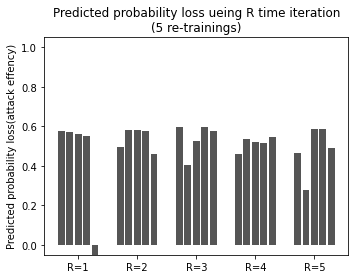

In [26]:
figure = plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
center_ixs_clean = []
for ix, block in enumerate(hit_prob):
    x_ixs= np.arange(len(block)) + ix*(len(block)+2)
    center_ixs_clean.append(np.mean(x_ixs))
    color = '#555555'
    plt.bar(x_ixs, block, color=color)
ax=plt.gca()
plt.ylim((-.05, 1.05))
plt.ylabel("Predicted probability loss(attack effency)")
ax.set_xticks(center_ixs_clean)
ax.set_xticklabels([make_xlabel_R(k+1) for k in range(5)])
ax.set_title("Predicted probability loss ueing R time iteration\n({} re-trainings)".format(retrain_iters))


<BarContainer object of 5 artists>

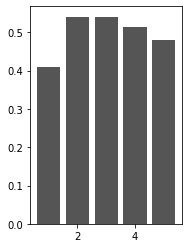

In [27]:
hit_prob_sum = np.zeros(5)
for i in range(5):
    hit_prob_sum[i] = hit_prob[i].sum()/5
n = [1,2,3,4,5]
plt.subplot(1,2,2)
plt.bar(n,hit_prob_sum,color='#555555')

In [28]:
hit_prob_influ = np.zeros((5,5))
target

array([2267, 1494, 1728, 1976,  962, 1302, 1198, 1225, 2391,  128,  771,
        237, 1146, 1992, 1011, 1016, 1347,  958, 1869,  861, 2438, 1409,
         11, 1400,   21, 1286, 2117, 1228, 2205,   20,  327,  791,  643,
       1829, 1857, 1373,  858, 2048, 1050,  501])

In [29]:
for i in range(5):#分别计算5次间接的攻击效果差异
    R = i+1
    for idx,u in enumerate(target):#计算筛选出来40个节点的攻击效果
        ### Setup Nettack

        nettack = ntk.Nettack( R,_A_obs, _X_obs, _z_obs, W1, W2, u, verbose=True)

        direct_attack = False
        n_influencers = 1 if direct_attack else 5
        n_perturbations = int(degrees[u]) # How many perturbations to perform. Default: Degree of the node
        perturb_features = True
        perturb_structure = True

        ### Poison the data

        nettack.reset()
        nettack.attack_surrogate(n_perturbations, perturb_structure=perturb_structure, perturb_features=perturb_features, direct=direct_attack, n_influencers=n_influencers)

        print(nettack.structure_perturbations)

        print(nettack.feature_perturbations)

        ### Train GCN without perturbations

        retrain_iters=5

        classification_margins_clean = []
        class_distrs_clean = []
        gcn_before = GCN.GCN(sizes, _An, _X_obs, "gcn_orig", gpu_id=gpu_id)
        for _ in range(retrain_iters):
            print("... {}/{} ".format(_+1, retrain_iters))
            gcn_before.train(split_train, split_val, _Z_obs)
            probs_before_attack = gcn_before.predictions.eval(session=gcn_before.session, feed_dict={gcn_before.node_ids: [nettack.u]})[0]
            class_distrs_clean.append(probs_before_attack)
            best_second_class_before = (probs_before_attack - 1000 * _Z_obs[nettack.u]).argmax()
            margin_before = probs_before_attack[_z_obs[nettack.u]] - probs_before_attack[best_second_class_before]
            classification_margins_clean.append(margin_before)
        class_distrs_clean = np.array(class_distrs_clean)

        ### Train GCN with perturbations
        classification_margins_corrupted = []
        class_distrs_retrain = []
        gcn_retrain = GCN.GCN(sizes, nettack.adj_preprocessed_copy, nettack.X_obs_copy.tocsr(), "gcn_retrain", gpu_id=gpu_id)
        for _ in range(retrain_iters):
            print("... {}/{} ".format(_+1, retrain_iters))
            gcn_retrain.train(split_train, split_val, _Z_obs)
            probs_after_attack = gcn_retrain.predictions.eval(session=gcn_retrain.session, feed_dict={gcn_retrain.node_ids: [nettack.u]})[0]
            best_second_class_after = (probs_after_attack - 1000 * _Z_obs[nettack.u]).argmax()
            margin_after = probs_after_attack[_z_obs[nettack.u]] - probs_after_attack[best_second_class_after]
            class_distrs_retrain.append(probs_after_attack)
            classification_margins_corrupted.append(margin_after)
        class_distrs_retrain = np.array(class_distrs_retrain)
        
        attack_effect = (class_distrs_clean.T[nettack.label_u]-class_distrs_retrain.T[nettack.label_u])/class_distrs_clean.T[nettack.label_u]
        attack_effect = attack_effect/len(target)
        if idx==0:
            hit_prob_influ[i] = attack_effect
        else:
            hit_prob_influ[i] = (hit_prob_influ[i] + attack_effect)
        
        

##### Starting attack #####
####score function will update every 1-th time####
##### Attack node with ID 2267 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 1 perturbations #####


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/numba/core/ir_utils.py:2119: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected set' found for argument 'edges_set' of function 'compute_new_a_hat_uv'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "nettack_0/nettack.py", line 598:
@jit(nopython=True)
def compute_new_a_hat_uv(edge_ixs, node_nb_ixs, edges_set, twohop_ixs, values_before, degs, potential_edges, u):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


Influencer nodes: [647   0   0   0   0]
##### ...1/1 perturbations ... #####
Edge perturbation: [ 647 1050]
random select perturbation is:
(647, 1050)
likelyhood between random selected graph and real graph is:  5.586648330790922e-05
[(647, 1050)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 78 iterations
... 2/5 
converged after 51 iterations
... 3/5 
converged after 47 iterations
... 4/5 
converged after 56 iterations
... 5/5 
converged after 64 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 60 iterations
... 2/5 
converged after 48 iterations
... 3/5 
converged after 54 iterations
... 4/5 
converged after 64 iterations
... 5/5 
converged after 52 iterations
##### Starting attack #####
####score function will update every 1-th time####
##### Attack node with ID 1494 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 4 perturbations #####
Influencer nodes: [1151 1219 1493 1513    0]
##### ...1/4 perturbations ... #####
Edge perturbation: [1219 2116]
random select perturbation is:
(1219, 2116)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/4 perturbations ... #####
Edge perturbation: [1219 1181]
random select perturbation is:
(1219, 2116)
(1219, 1181)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/4 perturbations ... #####
Edge perturbation: [1219  563]
random select perturbation is:
(1219, 563)
(1219, 2116)
likelyhood betwe

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 69 iterations
... 2/5 
converged after 54 iterations
... 3/5 
converged after 49 iterations
... 4/5 
converged after 69 iterations
... 5/5 
converged after 69 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 52 iterations
... 2/5 
converged after 100 iterations
... 3/5 
converged after 62 iterations
... 4/5 
converged after 67 iterations
... 5/5 
converged after 63 iterations
##### Starting attack #####
####score function will update every 1-th time####
##### Attack node with ID 1728 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 1 perturbations #####
Influencer nodes: [123   0   0   0   0]
##### ...1/1 perturbations ... #####
Edge perturbation: [123 668]
random select perturbation is:
(123, 668)
likelyhood between random selected graph and real graph is:  0.00012100163439754397
[(123, 668)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 63 iterations
... 2/5 
converged after 63 iterations
... 3/5 
converged after 77 iterations
... 4/5 
converged after 51 iterations
... 5/5 
converged after 57 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 75 iterations
... 2/5 
converged after 90 iterations
... 3/5 
converged after 86 iterations
... 4/5 
converged after 56 iterations
... 5/5 
converged after 72 iterations
##### Starting attack #####
####score function will update every 1-th time####
##### Attack node with ID 1976 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 8 perturbations #####
Influencer nodes: [1304 1353  702  717  797]
##### ...1/8 perturbations ... #####
Edge perturbation: [702 839]
random select perturbation is:
(702, 839)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/8 perturbations ... #####
Edge perturbation: [717 322]
random select perturbation is:
(702, 839)
(717, 322)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/8 perturbations ... #####
Edge perturbation: [797 839]
random select perturbation is:
(797, 839)
(717, 322)
likelyhood between ran

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 92 iterations
... 2/5 
converged after 51 iterations
... 3/5 
converged after 80 iterations
... 4/5 
converged after 46 iterations
... 5/5 
converged after 53 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 81 iterations
... 2/5 
converged after 69 iterations
... 3/5 
converged after 74 iterations
... 4/5 
converged after 51 iterations
... 5/5 
converged after 56 iterations
##### Starting attack #####
####score function will update every 1-th time####
##### Attack node with ID 962 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 5 perturbations #####
Influencer nodes: [ 853  210  910  583 2410]
##### ...1/5 perturbations ... #####
Edge perturbation: [ 583 1050]
random select perturbation is:
(583, 1050)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/5 perturbations ... #####
Edge perturbation: [ 583 1397]
random select perturbation is:
(583, 1397)
(583, 1050)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/5 perturbations ... #####
Edge perturbation: [2410 1050]
random select perturbation is:
(583, 1397)
(583, 1050)
likelyhood b

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 47 iterations
... 2/5 
converged after 55 iterations
... 3/5 
converged after 64 iterations
... 4/5 
converged after 61 iterations
... 5/5 
converged after 60 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 63 iterations
... 2/5 
converged after 66 iterations
... 3/5 
converged after 48 iterations
... 4/5 
converged after 61 iterations
... 5/5 
converged after 68 iterations
##### Starting attack #####
####score function will update every 1-th time####
##### Attack node with ID 1302 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 1 perturbations #####
Influencer nodes: [268   0   0   0   0]
##### ...1/1 perturbations ... #####
Edge perturbation: [ 268 1505]
random select perturbation is:
(268, 1505)
likelyhood between random selected graph and real graph is:  0.0
[(268, 1505)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 61 iterations
... 2/5 
converged after 63 iterations
... 3/5 
converged after 49 iterations
... 4/5 
converged after 67 iterations
... 5/5 
converged after 81 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 76 iterations
... 2/5 
converged after 47 iterations
... 3/5 
converged after 68 iterations
... 4/5 
converged after 64 iterations
... 5/5 
converged after 64 iterations
##### Starting attack #####
####score function will update every 1-th time####
##### Attack node with ID 1198 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 2 perturbations #####
Influencer nodes: [ 461 1590    0    0    0]
##### ...1/2 perturbations ... #####
Edge perturbation: [1590 1664]
random select perturbation is:
(1590, 1664)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [1590  322]
random select perturbation is:
(1590, 1664)
(1590, 322)
likelyhood between random selected graph and real graph is:  0.0
[(1590, 1664), (1590, 322)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 48 iterations
... 2/5 
converged after 46 iterations
... 3/5 
converged after 47 iterations
... 4/5 
converged after 69 iterations
... 5/5 
converged after 67 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 75 iterations
... 2/5 
converged after 46 iterations
... 3/5 
converged after 51 iterations
... 4/5 
converged after 61 iterations
... 5/5 
converged after 74 iterations
##### Starting attack #####
####score function will update every 1-th time####
##### Attack node with ID 1225 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 2 perturbations #####
Influencer nodes: [ 245 1758    0    0    0]
##### ...1/2 perturbations ... #####
Edge perturbation: [ 245 2116]
random select perturbation is:
(245, 2116)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [ 245 1181]
random select perturbation is:
(245, 2116)
(245, 1181)
likelyhood between random selected graph and real graph is:  -0.0003584732548915781
[(245, 2116), (245, 1181)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 52 iterations
... 2/5 
converged after 55 iterations
... 3/5 
converged after 63 iterations
... 4/5 
converged after 82 iterations
... 5/5 
converged after 59 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 51 iterations
... 2/5 
converged after 50 iterations
... 3/5 
converged after 50 iterations
... 4/5 
converged after 75 iterations
... 5/5 
converged after 45 iterations
##### Starting attack #####
####score function will update every 1-th time####
##### Attack node with ID 2391 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 30 perturbations #####
Influencer nodes: [2382 1133  253 1554 1209]
##### ...1/30 perturbations ... #####
Edge perturbation: [2382 2414]
random select perturbation is:
(2382, 2414)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/30 perturbations ... #####
Edge perturbation: [2382  830]
random select perturbation is:
(2382, 2414)
(2382, 830)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/30 perturbations ... #####
Edge perturbation: [253 158]
random select perturbation is:
(2382, 2414)
(2382, 830)
likely

Edge perturbation: [1133  125]
random select perturbation is:
(2382, 2414)
(253, 1323)
(253, 1234)
(253, 372)
(1133, 1949)
(1209, 2407)
(2382, 1133)
(1133, 1318)
(2382, 595)
(2382, 2414)
(253, 199)
(253, 564)
(2382, 830)
(253, 1554)
(1133, 1751)
(1133, 1944)
likelyhood between random selected graph and real graph is:  0.0
[(2382, 2414), (2382, 830), (253, 158), (1133, 2169), (2382, 897), (253, 564), (1133, 848), (2382, 1133), (2382, 2116), (2382, 1948), (2382, 1949), (1133, 2335), (253, 199), (2382, 2414), (2382, 2414), (1133, 1751), (253, 978), (253, 1234), (253, 372), (253, 1554), (1133, 1060), (1133, 1949), (1133, 1318), (253, 1323), (1133, 1944), (1209, 649), (1133, 1161), (2382, 595), (1209, 2407), (1133, 125)]
[(), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 51 iterations
... 2/5 
converged after 64 iterations
... 3/5 
converged after 76 iterations
... 4/5 
converged after 55 iterations
... 5/5 
converged after 84 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 57 iterations
... 2/5 
converged after 53 iterations
... 3/5 
converged after 82 iterations
... 4/5 
converged after 67 iterations
... 5/5 
converged after 95 iterations
##### Starting attack #####
####score function will update every 1-th time####
##### Attack node with ID 128 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 2 perturbations #####
Influencer nodes: [1037 1042    0    0    0]
##### ...1/2 perturbations ... #####
Edge perturbation: [1037 1050]
random select perturbation is:
(1037, 1050)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [1037 1397]
random select perturbation is:
(1037, 1050)
(1037, 1397)
likelyhood between random selected graph and real graph is:  0.0
[(1037, 1050), (1037, 1397)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 57 iterations
... 2/5 
converged after 60 iterations
... 3/5 
converged after 57 iterations
... 4/5 
converged after 67 iterations
... 5/5 
converged after 55 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 69 iterations
... 2/5 
converged after 49 iterations
... 3/5 
converged after 62 iterations
... 4/5 
converged after 61 iterations
... 5/5 
converged after 46 iterations
##### Starting attack #####
####score function will update every 1-th time####
##### Attack node with ID 771 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 1 perturbations #####
Influencer nodes: [1179    0    0    0    0]
##### ...1/1 perturbations ... #####
Edge perturbation: [1179  389]
random select perturbation is:
(1179, 389)
likelyhood between random selected graph and real graph is:  0.0
[(1179, 389)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 62 iterations
... 2/5 
converged after 116 iterations
... 3/5 
converged after 62 iterations
... 4/5 
converged after 68 iterations
... 5/5 
converged after 80 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 63 iterations
... 2/5 
converged after 47 iterations
... 3/5 
converged after 74 iterations
... 4/5 
converged after 44 iterations
... 5/5 
converged after 66 iterations
##### Starting attack #####
####score function will update every 1-th time####
##### Attack node with ID 237 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 1 perturbations #####
Influencer nodes: [2427    0    0    0    0]
##### ...1/1 perturbations ... #####
Edge perturbation: [2427  839]
random select perturbation is:
(2427, 839)
likelyhood between random selected graph and real graph is:  5.586648330790922e-05
[(2427, 839)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 65 iterations
... 2/5 
converged after 64 iterations
... 3/5 
converged after 70 iterations
... 4/5 
converged after 85 iterations
... 5/5 
converged after 48 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 56 iterations
... 2/5 
converged after 68 iterations
... 3/5 
converged after 111 iterations
... 4/5 
converged after 65 iterations
... 5/5 
converged after 64 iterations
##### Starting attack #####
####score function will update every 1-th time####
##### Attack node with ID 1146 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 1 perturbations #####
Influencer nodes: [233   0   0   0   0]
##### ...1/1 perturbations ... #####
Edge perturbation: [ 233 2116]
random select perturbation is:
(233, 2116)
likelyhood between random selected graph and real graph is:  0.0
[(233, 2116)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 89 iterations
... 2/5 
converged after 79 iterations
... 3/5 
converged after 68 iterations
... 4/5 
converged after 52 iterations
... 5/5 
converged after 48 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 75 iterations
... 2/5 
converged after 75 iterations
... 3/5 
converged after 99 iterations
... 4/5 
converged after 67 iterations
... 5/5 
converged after 81 iterations
##### Starting attack #####
####score function will update every 1-th time####
##### Attack node with ID 1992 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 10 perturbations #####
Influencer nodes: [1972 1373  180  861  852]
##### ...1/10 perturbations ... #####
Edge perturbation: [180 668]
random select perturbation is:
(180, 668)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/10 perturbations ... #####
Edge perturbation: [ 180 2259]
random select perturbation is:
(180, 2259)
(180, 668)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/10 perturbations ... #####
Edge perturbation: [1373  389]
random select perturbation is:
(180, 668)
(1373, 389)
likelyhood b

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 60 iterations
... 2/5 
converged after 51 iterations
... 3/5 
converged after 56 iterations
... 4/5 
converged after 52 iterations
... 5/5 
converged after 64 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 84 iterations
... 2/5 
converged after 80 iterations
... 3/5 
converged after 66 iterations
... 4/5 
converged after 47 iterations
... 5/5 
converged after 70 iterations
##### Starting attack #####
####score function will update every 1-th time####
##### Attack node with ID 1011 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 2 perturbations #####
Influencer nodes: [ 865 1554    0    0    0]
##### ...1/2 perturbations ... #####
Edge perturbation: [ 865 2414]
random select perturbation is:
(865, 2414)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [865 830]
random select perturbation is:
(865, 2414)
(865, 830)
likelyhood between random selected graph and real graph is:  0.0
[(865, 2414), (865, 830)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 85 iterations
... 2/5 
converged after 47 iterations
... 3/5 
converged after 50 iterations
... 4/5 
converged after 70 iterations
... 5/5 
converged after 67 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 66 iterations
... 2/5 
converged after 86 iterations
... 3/5 
converged after 65 iterations
... 4/5 
converged after 76 iterations
... 5/5 
converged after 50 iterations
##### Starting attack #####
####score function will update every 1-th time####
##### Attack node with ID 1016 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 3 perturbations #####
Influencer nodes: [ 852  877 2137    0    0]
##### ...1/3 perturbations ... #####
Edge perturbation: [2137  668]
random select perturbation is:
(2137, 668)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/3 perturbations ... #####
Edge perturbation: [2137 2259]
random select perturbation is:
(2137, 668)
(2137, 2259)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/3 perturbations ... #####
Edge perturbation: [2137  389]
random select perturbation is:
(2137, 389)
(2137, 668)
likelyhood

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 50 iterations
... 2/5 
converged after 59 iterations
... 3/5 
converged after 65 iterations
... 4/5 
converged after 45 iterations
... 5/5 
converged after 61 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 90 iterations
... 2/5 
converged after 56 iterations
... 3/5 
converged after 56 iterations
... 4/5 
converged after 66 iterations
... 5/5 
converged after 47 iterations
##### Starting attack #####
####score function will update every 1-th time####
##### Attack node with ID 1347 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 17 perturbations #####
Influencer nodes: [1740  628  340 1027 1920]
##### ...1/17 perturbations ... #####
Edge perturbation: [ 628 2116]
random select perturbation is:
(628, 2116)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/17 perturbations ... #####
Edge perturbation: [ 628 1181]
random select perturbation is:
(628, 2116)
(628, 1181)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/17 perturbations ... #####
Edge perturbation: [1740  563]
random select perturbation is:
(1740, 563)
(628, 2116)
likelyh

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 65 iterations
... 2/5 
converged after 68 iterations
... 3/5 
converged after 66 iterations
... 4/5 
converged after 71 iterations
... 5/5 
converged after 53 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 76 iterations
... 2/5 
converged after 55 iterations
... 3/5 
converged after 51 iterations
... 4/5 
converged after 51 iterations
... 5/5 
converged after 62 iterations
##### Starting attack #####
####score function will update every 1-th time####
##### Attack node with ID 958 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 2 perturbations #####
Influencer nodes: [ 909 1802    0    0    0]
##### ...1/2 perturbations ... #####
Edge perturbation: [1802 1050]
random select perturbation is:
(1802, 1050)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [1802 1397]
random select perturbation is:
(1802, 1397)
(1802, 1050)
likelyhood between random selected graph and real graph is:  0.0
[(1802, 1050), (1802, 1397)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 100 iterations
... 2/5 
converged after 58 iterations
... 3/5 
converged after 63 iterations
... 4/5 
converged after 63 iterations
... 5/5 
converged after 62 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 59 iterations
... 2/5 
converged after 55 iterations
... 3/5 
converged after 57 iterations
... 4/5 
converged after 65 iterations
... 5/5 
converged after 60 iterations
##### Starting attack #####
####score function will update every 1-th time####
##### Attack node with ID 1869 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 2 perturbations #####
Influencer nodes: [2154 2217    0    0    0]
##### ...1/2 perturbations ... #####
Edge perturbation: [2217 1937]
random select perturbation is:
(2217, 1937)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [2217 1081]
random select perturbation is:
(2217, 1937)
(2217, 1081)
likelyhood between random selected graph and real graph is:  0.0
[(2217, 1937), (2217, 1081)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 50 iterations
... 2/5 
converged after 93 iterations
... 3/5 
converged after 61 iterations
... 4/5 
converged after 52 iterations
... 5/5 
converged after 59 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 53 iterations
... 2/5 
converged after 68 iterations
... 3/5 
converged after 75 iterations
... 4/5 
converged after 78 iterations
... 5/5 
converged after 69 iterations
##### Starting attack #####
####score function will update every 1-th time####
##### Attack node with ID 861 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 5 perturbations #####
Influencer nodes: [  71 1891 1670 1992   95]
##### ...1/5 perturbations ... #####
Edge perturbation: [  71 1664]
random select perturbation is:
(71, 1664)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/5 perturbations ... #####
Edge perturbation: [ 71 839]
random select perturbation is:
(71, 839)
(71, 1664)
likelyhood between random selected graph and real graph is:  5.586648330790922e-05
##### ...3/5 perturbations ... #####
Edge perturbation: [ 71 322]
random select perturbation is:
(71, 839)
(71, 1664)
likel

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 64 iterations
... 2/5 
converged after 55 iterations
... 3/5 
converged after 46 iterations
... 4/5 
converged after 102 iterations
... 5/5 
converged after 66 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 51 iterations
... 2/5 
converged after 62 iterations
... 3/5 
converged after 54 iterations
... 4/5 
converged after 45 iterations
... 5/5 
converged after 76 iterations
##### Starting attack #####
####score function will update every 1-th time####
##### Attack node with ID 2438 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 1 perturbations #####
Influencer nodes: [929   0   0   0   0]
##### ...1/1 perturbations ... #####
Edge perturbation: [929 839]
random select perturbation is:
(929, 839)
likelyhood between random selected graph and real graph is:  0.0
[(929, 839)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 88 iterations
... 2/5 
converged after 90 iterations
... 3/5 
converged after 48 iterations
... 4/5 
converged after 57 iterations
... 5/5 
converged after 50 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 70 iterations
... 2/5 
converged after 70 iterations
... 3/5 
converged after 58 iterations
... 4/5 
converged after 60 iterations
... 5/5 
converged after 48 iterations
##### Starting attack #####
####score function will update every 1-th time####
##### Attack node with ID 1409 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 5 perturbations #####
Influencer nodes: [2005  683 2007 1051 1260]
##### ...1/5 perturbations ... #####
Edge perturbation: [1051  786]
random select perturbation is:
(1051, 786)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/5 perturbations ... #####
Edge perturbation: [1051 2404]
random select perturbation is:
(1051, 786)
(1051, 2404)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/5 perturbations ... #####
Edge perturbation: [1051  389]
random select perturbation is:
(1051, 786)
(1051, 389)
likelyhood

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 59 iterations
... 2/5 
converged after 71 iterations
... 3/5 
converged after 77 iterations
... 4/5 
converged after 79 iterations
... 5/5 
converged after 55 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 124 iterations
... 2/5 
converged after 56 iterations
... 3/5 
converged after 54 iterations
... 4/5 
converged after 58 iterations
... 5/5 
converged after 58 iterations
##### Starting attack #####
####score function will update every 1-th time####
##### Attack node with ID 11 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 21 perturbations #####
Influencer nodes: [  13 1005  691  423 1830]
##### ...1/21 perturbations ... #####
Edge perturbation: [423 465]
random select perturbation is:
(423, 465)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/21 perturbations ... #####
Edge perturbation: [1830  465]
random select perturbation is:
(423, 465)
(1830, 465)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/21 perturbations ... #####
Edge perturbation: [423 336]
random select perturbation is:
(423, 465)
(1830, 465)
likelyhood betw

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 47 iterations
... 2/5 
converged after 62 iterations
... 3/5 
converged after 54 iterations
... 4/5 
converged after 68 iterations
... 5/5 
converged after 61 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 59 iterations
... 2/5 
converged after 98 iterations
... 3/5 
converged after 61 iterations
... 4/5 
converged after 74 iterations
... 5/5 
converged after 74 iterations
##### Starting attack #####
####score function will update every 1-th time####
##### Attack node with ID 1400 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 1 perturbations #####
Influencer nodes: [1562    0    0    0    0]
##### ...1/1 perturbations ... #####
Edge perturbation: [1562  336]
random select perturbation is:
(1562, 336)
likelyhood between random selected graph and real graph is:  0.0
[(1562, 336)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 70 iterations
... 2/5 
converged after 63 iterations
... 3/5 
converged after 63 iterations
... 4/5 
converged after 119 iterations
... 5/5 
converged after 53 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 96 iterations
... 2/5 
converged after 51 iterations
... 3/5 
converged after 62 iterations
... 4/5 
converged after 79 iterations
... 5/5 
converged after 55 iterations
##### Starting attack #####
####score function will update every 1-th time####
##### Attack node with ID 21 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 2 perturbations #####
Influencer nodes: [2444 2445    0    0    0]
##### ...1/2 perturbations ... #####
Edge perturbation: [2445  668]
random select perturbation is:
(2445, 668)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [2445 2259]
random select perturbation is:
(2445, 668)
(2445, 2259)
likelyhood between random selected graph and real graph is:  0.0
[(2445, 668), (2445, 2259)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 58 iterations
... 2/5 
converged after 73 iterations
... 3/5 
converged after 59 iterations
... 4/5 
converged after 70 iterations
... 5/5 
converged after 73 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 76 iterations
... 2/5 
converged after 45 iterations
... 3/5 
converged after 70 iterations
... 4/5 
converged after 57 iterations
... 5/5 
converged after 60 iterations
##### Starting attack #####
####score function will update every 1-th time####
##### Attack node with ID 1286 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 1 perturbations #####
Influencer nodes: [878   0   0   0   0]
##### ...1/1 perturbations ... #####
Edge perturbation: [ 878 2122]
random select perturbation is:
(878, 2122)
likelyhood between random selected graph and real graph is:  0.0
[(878, 2122)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 129 iterations
... 2/5 
converged after 78 iterations
... 3/5 
converged after 106 iterations
... 4/5 
converged after 59 iterations
... 5/5 
converged after 59 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 67 iterations
... 2/5 
converged after 58 iterations
... 3/5 
converged after 56 iterations
... 4/5 
converged after 64 iterations
... 5/5 
converged after 71 iterations
##### Starting attack #####
####score function will update every 1-th time####
##### Attack node with ID 2117 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 6 perturbations #####
Influencer nodes: [ 787  587 2393 2121 1773]
##### ...1/6 perturbations ... #####
Edge perturbation: [587 839]
random select perturbation is:
(587, 839)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/6 perturbations ... #####
Edge perturbation: [ 587 1270]
random select perturbation is:
(587, 839)
(587, 1270)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/6 perturbations ... #####
Edge perturbation: [ 787 1557]
random select perturbation is:
(587, 1270)
(587, 839)
likelyhood betwe

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 87 iterations
... 2/5 
converged after 69 iterations
... 3/5 
converged after 105 iterations
... 4/5 
converged after 104 iterations
... 5/5 
converged after 52 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 55 iterations
... 2/5 
converged after 55 iterations
... 3/5 
converged after 43 iterations
... 4/5 
converged after 65 iterations
... 5/5 
converged after 67 iterations
##### Starting attack #####
####score function will update every 1-th time####
##### Attack node with ID 1228 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 3 perturbations #####
Influencer nodes: [1246 1464 2347    0    0]
##### ...1/3 perturbations ... #####
Edge perturbation: [1246 2116]
random select perturbation is:
(1246, 2116)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/3 perturbations ... #####
Edge perturbation: [1246  563]
random select perturbation is:
(1246, 2116)
(1246, 563)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/3 perturbations ... #####
Edge perturbation: [2347 2116]
random select perturbation is:
(1246, 2116)
(1246, 563)
likelyhood betwee

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 58 iterations
... 2/5 
converged after 66 iterations
... 3/5 
converged after 74 iterations
... 4/5 
converged after 71 iterations
... 5/5 
converged after 148 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 55 iterations
... 2/5 
converged after 48 iterations
... 3/5 
converged after 117 iterations
... 4/5 
converged after 74 iterations
... 5/5 
converged after 60 iterations
##### Starting attack #####
####score function will update every 1-th time####
##### Attack node with ID 2205 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 2 perturbations #####
Influencer nodes: [   1 1495    0    0    0]
##### ...1/2 perturbations ... #####
Edge perturbation: [   1 2122]
random select perturbation is:
(1, 2122)
likelyhood between random selected graph and real graph is:  0.00012100163439754397
##### ...2/2 perturbations ... #####
Edge perturbation: [  1 163]
random select perturbation is:
(1, 163)
(1, 2122)
likelyhood between random selected graph and real graph is:  -0.00019676098600029945
[(1, 2122), (1, 163)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 106 iterations
... 2/5 
converged after 58 iterations
... 3/5 
converged after 55 iterations
... 4/5 
converged after 52 iterations
... 5/5 
converged after 64 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 62 iterations
... 2/5 
converged after 79 iterations
... 3/5 
converged after 59 iterations
... 4/5 
converged after 93 iterations
... 5/5 
converged after 73 iterations
##### Starting attack #####
####score function will update every 1-th time####
##### Attack node with ID 20 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 5 perturbations #####
Influencer nodes: [782  27 529  74 117]
##### ...1/5 perturbations ... #####
Edge perturbation: [ 529 2414]
random select perturbation is:
(529, 2414)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/5 perturbations ... #####
Edge perturbation: [529 830]
random select perturbation is:
(529, 830)
(529, 2414)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/5 perturbations ... #####
Edge perturbation: [782 158]
random select perturbation is:
(782, 158)
(529, 830)
likelyhood between random selected

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 50 iterations
... 2/5 
converged after 50 iterations
... 3/5 
converged after 65 iterations
... 4/5 
converged after 54 iterations
... 5/5 
converged after 53 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 53 iterations
... 2/5 
converged after 60 iterations
... 3/5 
converged after 54 iterations
... 4/5 
converged after 88 iterations
... 5/5 
converged after 57 iterations
##### Starting attack #####
####score function will update every 1-th time####
##### Attack node with ID 327 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 2 perturbations #####
Influencer nodes: [1334 2209    0    0    0]
##### ...1/2 perturbations ... #####
Edge perturbation: [1334 2116]
random select perturbation is:
(1334, 2116)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [1334 1181]
random select perturbation is:
(1334, 1181)
(1334, 2116)
likelyhood between random selected graph and real graph is:  0.00012100163439754397
[(1334, 2116), (1334, 1181)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 78 iterations
... 2/5 
converged after 67 iterations
... 3/5 
converged after 53 iterations
... 4/5 
converged after 53 iterations
... 5/5 
converged after 87 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 57 iterations
... 2/5 
converged after 65 iterations
... 3/5 
converged after 57 iterations
... 4/5 
converged after 55 iterations
... 5/5 
converged after 75 iterations
##### Starting attack #####
####score function will update every 1-th time####
##### Attack node with ID 791 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 2 perturbations #####
Influencer nodes: [ 929 1504    0    0    0]
##### ...1/2 perturbations ... #####
Edge perturbation: [1504 2116]
random select perturbation is:
(1504, 2116)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [1504 1181]
random select perturbation is:
(1504, 2116)
(1504, 1181)
likelyhood between random selected graph and real graph is:  0.0
[(1504, 2116), (1504, 1181)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 67 iterations
... 2/5 
converged after 83 iterations
... 3/5 
converged after 60 iterations
... 4/5 
converged after 48 iterations
... 5/5 
converged after 72 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 50 iterations
... 2/5 
converged after 50 iterations
... 3/5 
converged after 65 iterations
... 4/5 
converged after 64 iterations
... 5/5 
converged after 56 iterations
##### Starting attack #####
####score function will update every 1-th time####
##### Attack node with ID 643 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 2 perturbations #####
Influencer nodes: [1788 2262    0    0    0]
##### ...1/2 perturbations ... #####
Edge perturbation: [1788  459]
random select perturbation is:
(1788, 459)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [1788  786]
random select perturbation is:
(1788, 786)
(1788, 459)
likelyhood between random selected graph and real graph is:  0.0001304695542785339
[(1788, 459), (1788, 786)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 50 iterations
... 2/5 
converged after 70 iterations
... 3/5 
converged after 47 iterations
... 4/5 
converged after 63 iterations
... 5/5 
converged after 64 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 121 iterations
... 2/5 
converged after 81 iterations
... 3/5 
converged after 63 iterations
... 4/5 
converged after 67 iterations
... 5/5 
converged after 66 iterations
##### Starting attack #####
####score function will update every 1-th time####
##### Attack node with ID 1829 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 2 perturbations #####
Influencer nodes: [ 109 2237    0    0    0]
##### ...1/2 perturbations ... #####
Edge perturbation: [109 115]
random select perturbation is:
(109, 115)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [ 109 2456]
random select perturbation is:
(109, 115)
(109, 2456)
likelyhood between random selected graph and real graph is:  0.0
[(109, 115), (109, 2456)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 104 iterations
... 2/5 
converged after 60 iterations
... 3/5 
converged after 48 iterations
... 4/5 
converged after 65 iterations
... 5/5 
converged after 65 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 50 iterations
... 2/5 
converged after 64 iterations
... 3/5 
converged after 68 iterations
... 4/5 
converged after 79 iterations
... 5/5 
converged after 91 iterations
##### Starting attack #####
####score function will update every 1-th time####
##### Attack node with ID 1857 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 2 perturbations #####
Influencer nodes: [ 457 1996    0    0    0]
##### ...1/2 perturbations ... #####
Edge perturbation: [ 457 1288]
random select perturbation is:
(457, 1288)
likelyhood between random selected graph and real graph is:  0.00019362680177437142
##### ...2/2 perturbations ... #####
Edge perturbation: [1996 1664]
random select perturbation is:
(457, 1288)
(1996, 1664)
likelyhood between random selected graph and real graph is:  0.0
[(457, 1288), (1996, 1664)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 52 iterations
... 2/5 
converged after 49 iterations
... 3/5 
converged after 69 iterations
... 4/5 
converged after 73 iterations
... 5/5 
converged after 69 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 63 iterations
... 2/5 
converged after 64 iterations
... 3/5 
converged after 103 iterations
... 4/5 
converged after 88 iterations
... 5/5 
converged after 57 iterations
##### Starting attack #####
####score function will update every 1-th time####
##### Attack node with ID 1373 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 4 perturbations #####
Influencer nodes: [ 343  842  852 1992    0]
##### ...1/4 perturbations ... #####
Edge perturbation: [ 343 1599]
random select perturbation is:
(343, 1599)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/4 perturbations ... #####
Edge perturbation: [343 668]
random select perturbation is:
(343, 668)
(343, 1599)
likelyhood between random selected graph and real graph is:  5.586648330790922e-05
##### ...3/4 perturbations ... #####
Edge perturbation: [ 343 2259]
random select perturbation is:
(343, 1599)
(343, 668)
likel

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 55 iterations
... 2/5 
converged after 68 iterations
... 3/5 
converged after 54 iterations
... 4/5 
converged after 75 iterations
... 5/5 
converged after 57 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 70 iterations
... 2/5 
converged after 69 iterations
... 3/5 
converged after 68 iterations
... 4/5 
converged after 49 iterations
... 5/5 
converged after 80 iterations
##### Starting attack #####
####score function will update every 1-th time####
##### Attack node with ID 858 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 2 perturbations #####
Influencer nodes: [1055 2208    0    0    0]
##### ...1/2 perturbations ... #####
Edge perturbation: [1055 2116]
random select perturbation is:
(1055, 2116)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [1055 1181]
random select perturbation is:
(1055, 2116)
(1055, 1181)
likelyhood between random selected graph and real graph is:  0.0
[(1055, 2116), (1055, 1181)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 61 iterations
... 2/5 
converged after 98 iterations
... 3/5 
converged after 48 iterations
... 4/5 
converged after 69 iterations
... 5/5 
converged after 46 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 114 iterations
... 2/5 
converged after 58 iterations
... 3/5 
converged after 57 iterations
... 4/5 
converged after 59 iterations
... 5/5 
converged after 69 iterations
##### Starting attack #####
####score function will update every 1-th time####
##### Attack node with ID 2048 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 2 perturbations #####
Influencer nodes: [ 249 1174    0    0    0]
##### ...1/2 perturbations ... #####
Edge perturbation: [249 389]
random select perturbation is:
(249, 389)
likelyhood between random selected graph and real graph is:  0.0012461178848752752
##### ...2/2 perturbations ... #####
Edge perturbation: [ 249 1323]
random select perturbation is:
(249, 1323)
(249, 389)
likelyhood between random selected graph and real graph is:  0.0013987761849421076
[(249, 389), (249, 1323)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 64 iterations
... 2/5 
converged after 88 iterations
... 3/5 
converged after 51 iterations
... 4/5 
converged after 93 iterations
... 5/5 
converged after 64 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 57 iterations
... 2/5 
converged after 47 iterations
... 3/5 
converged after 77 iterations
... 4/5 
converged after 44 iterations
... 5/5 
converged after 55 iterations
##### Starting attack #####
####score function will update every 1-th time####
##### Attack node with ID 1050 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 1 perturbations #####
Influencer nodes: [2375    0    0    0    0]
##### ...1/1 perturbations ... #####
Edge perturbation: [2375  786]
random select perturbation is:
(2375, 786)
likelyhood between random selected graph and real graph is:  9.255457553081214e-05
[(2375, 786)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 86 iterations
... 2/5 
converged after 65 iterations
... 3/5 
converged after 60 iterations
... 4/5 
converged after 62 iterations
... 5/5 
converged after 55 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 65 iterations
... 2/5 
converged after 56 iterations
... 3/5 
converged after 50 iterations
... 4/5 
converged after 59 iterations
... 5/5 
converged after 105 iterations
##### Starting attack #####
####score function will update every 1-th time####
##### Attack node with ID 501 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 4 perturbations #####
Influencer nodes: [1901 1905 1933 1934    0]
##### ...1/4 perturbations ... #####
Edge perturbation: [1934  839]
random select perturbation is:
(1934, 839)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/4 perturbations ... #####
Edge perturbation: [1934 1270]
random select perturbation is:
(1934, 1270)
(1934, 839)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/4 perturbations ... #####
Edge perturbation: [1901 1557]
random select perturbation is:
(1934, 839)
(1901, 1557)
likelyhood between

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 58 iterations
... 2/5 
converged after 98 iterations
... 3/5 
converged after 51 iterations
... 4/5 
converged after 86 iterations
... 5/5 
converged after 59 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 93 iterations
... 2/5 
converged after 71 iterations
... 3/5 
converged after 47 iterations
... 4/5 
converged after 143 iterations
... 5/5 
converged after 47 iterations
##### Starting attack #####
####score function will update every 2-th time####
##### Attack node with ID 2267 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 1 perturbations #####
Influencer nodes: [647   0   0   0   0]
##### ...1/1 perturbations ... #####
Edge perturbation: [ 647 1050]
random select perturbation is:
(647, 1050)
likelyhood between random selected graph and real graph is:  5.586648330790922e-05
[(647, 1050)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 64 iterations
... 2/5 
converged after 69 iterations
... 3/5 
converged after 72 iterations
... 4/5 
converged after 95 iterations
... 5/5 
converged after 68 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 179 iterations
... 2/5 
converged after 67 iterations
... 3/5 
converged after 53 iterations
... 4/5 
converged after 69 iterations
... 5/5 
converged after 87 iterations
##### Starting attack #####
####score function will update every 2-th time####
##### Attack node with ID 1494 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 4 perturbations #####
Influencer nodes: [1151 1219 1493 1513    0]
##### ...1/4 perturbations ... #####
Edge perturbation: [1219 2116]
random select perturbation is:
(1219, 2116)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/4 perturbations ... #####
Edge perturbation: [1219 1181]
random select perturbation is:
(1219, 2116)
(1219, 1181)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/4 perturbations ... #####
Edge perturbation: [1219  563]
random select perturbation is:
(1219, 563)
(1219, 2116)
likelyhood betw

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 70 iterations
... 2/5 
converged after 65 iterations
... 3/5 
converged after 61 iterations
... 4/5 
converged after 68 iterations
... 5/5 
converged after 64 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 118 iterations
... 2/5 
converged after 45 iterations
... 3/5 
converged after 80 iterations
... 4/5 
converged after 51 iterations
... 5/5 
converged after 76 iterations
##### Starting attack #####
####score function will update every 2-th time####
##### Attack node with ID 1728 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 1 perturbations #####
Influencer nodes: [123   0   0   0   0]
##### ...1/1 perturbations ... #####
Edge perturbation: [123 668]
random select perturbation is:
(123, 668)
likelyhood between random selected graph and real graph is:  0.00012100163439754397
[(123, 668)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 52 iterations
... 2/5 
converged after 65 iterations
... 3/5 
converged after 66 iterations
... 4/5 
converged after 97 iterations
... 5/5 
converged after 64 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 65 iterations
... 2/5 
converged after 67 iterations
... 3/5 
converged after 60 iterations
... 4/5 
converged after 68 iterations
... 5/5 
converged after 89 iterations
##### Starting attack #####
####score function will update every 2-th time####
##### Attack node with ID 1976 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 8 perturbations #####
Influencer nodes: [1304 1353  702  717  797]
##### ...1/8 perturbations ... #####
Edge perturbation: [702 839]
random select perturbation is:
(702, 839)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/8 perturbations ... #####
Edge perturbation: [717 322]
random select perturbation is:
(717, 322)
(702, 839)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/8 perturbations ... #####
Edge perturbation: [797 839]
random select perturbation is:
(702, 839)
(797, 839)
likelyhood between ran

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 69 iterations
... 2/5 
converged after 65 iterations
... 3/5 
converged after 80 iterations
... 4/5 
converged after 49 iterations
... 5/5 
converged after 81 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 46 iterations
... 2/5 
converged after 47 iterations
... 3/5 
converged after 56 iterations
... 4/5 
converged after 69 iterations
... 5/5 
converged after 51 iterations
##### Starting attack #####
####score function will update every 2-th time####
##### Attack node with ID 962 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 5 perturbations #####
Influencer nodes: [ 853  210  910  583 2410]
##### ...1/5 perturbations ... #####
Edge perturbation: [ 583 1050]
random select perturbation is:
(583, 1050)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/5 perturbations ... #####
Edge perturbation: [ 583 1397]
random select perturbation is:
(583, 1397)
(583, 1050)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/5 perturbations ... #####
Edge perturbation: [2410 1050]
random select perturbation is:
(583, 1397)
(2410, 1050)
likelyhood between r

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 79 iterations
... 2/5 
converged after 63 iterations
... 3/5 
converged after 50 iterations
... 4/5 
converged after 59 iterations
... 5/5 
converged after 60 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 69 iterations
... 2/5 
converged after 97 iterations
... 3/5 
converged after 84 iterations
... 4/5 
converged after 118 iterations
... 5/5 
converged after 52 iterations
##### Starting attack #####
####score function will update every 2-th time####
##### Attack node with ID 1302 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 1 perturbations #####
Influencer nodes: [268   0   0   0   0]
##### ...1/1 perturbations ... #####
Edge perturbation: [ 268 1505]
random select perturbation is:
(268, 1505)
likelyhood between random selected graph and real graph is:  0.0
[(268, 1505)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 51 iterations
... 2/5 
converged after 111 iterations
... 3/5 
converged after 67 iterations
... 4/5 
converged after 70 iterations
... 5/5 
converged after 67 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 74 iterations
... 2/5 
converged after 53 iterations
... 3/5 
converged after 59 iterations
... 4/5 
converged after 67 iterations
... 5/5 
converged after 59 iterations
##### Starting attack #####
####score function will update every 2-th time####
##### Attack node with ID 1198 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 2 perturbations #####
Influencer nodes: [ 461 1590    0    0    0]
##### ...1/2 perturbations ... #####
Edge perturbation: [1590 1664]
random select perturbation is:
(1590, 1664)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [1590  322]
random select perturbation is:
(1590, 322)
(1590, 1664)
likelyhood between random selected graph and real graph is:  0.0
[(1590, 1664), (1590, 322)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 66 iterations
... 2/5 
converged after 63 iterations
... 3/5 
converged after 46 iterations
... 4/5 
converged after 61 iterations
... 5/5 
converged after 60 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 54 iterations
... 2/5 
converged after 61 iterations
... 3/5 
converged after 54 iterations
... 4/5 
converged after 70 iterations
... 5/5 
converged after 72 iterations
##### Starting attack #####
####score function will update every 2-th time####
##### Attack node with ID 1225 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 2 perturbations #####
Influencer nodes: [ 245 1758    0    0    0]
##### ...1/2 perturbations ... #####
Edge perturbation: [ 245 2116]
random select perturbation is:
(245, 2116)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [ 245 1181]
random select perturbation is:
(245, 1181)
(245, 2116)
likelyhood between random selected graph and real graph is:  -0.0003584732548915781
[(245, 2116), (245, 1181)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 87 iterations
... 2/5 
converged after 52 iterations
... 3/5 
converged after 67 iterations
... 4/5 
converged after 74 iterations
... 5/5 
converged after 71 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 60 iterations
... 2/5 
converged after 51 iterations
... 3/5 
converged after 69 iterations
... 4/5 
converged after 48 iterations
... 5/5 
converged after 82 iterations
##### Starting attack #####
####score function will update every 2-th time####
##### Attack node with ID 2391 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 30 perturbations #####
Influencer nodes: [2382 1133  253 1554 1209]
##### ...1/30 perturbations ... #####
Edge perturbation: [2382 2414]
random select perturbation is:
(2382, 2414)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/30 perturbations ... #####
Edge perturbation: [2382  830]
random select perturbation is:
(2382, 830)
(2382, 2414)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/30 perturbations ... #####
Edge perturbation: [253 158]
random select perturbation is:
(253, 158)
(2382, 2414)
likelyhood betwe

Edge perturbation: [1209  125]
random select perturbation is:
(253, 1234)
(1133, 2414)
(253, 1323)
(1209, 2407)
(1133, 1318)
(1133, 2335)
(253, 199)
(253, 158)
(2382, 830)
(253, 1554)
(253, 564)
(2382, 372)
(1209, 649)
(1133, 1161)
(1133, 1944)
(2382, 897)
likelyhood between random selected graph and real graph is:  0.0
[(2382, 2414), (2382, 830), (253, 158), (1133, 2169), (2382, 897), (253, 564), (1133, 848), (2382, 1133), (2382, 2116), (2382, 1948), (2382, 1949), (1133, 2335), (253, 199), (2382, 2414), (1133, 2414), (253, 1751), (253, 978), (253, 1234), (2382, 372), (253, 1554), (1133, 1060), (1133, 1949), (1133, 1318), (253, 1323), (1133, 1944), (1209, 649), (1133, 1161), (2382, 595), (1209, 2407), (1209, 125)]
[(), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 50 iterations
... 2/5 
converged after 52 iterations
... 3/5 
converged after 67 iterations
... 4/5 
converged after 67 iterations
... 5/5 
converged after 65 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 73 iterations
... 2/5 
converged after 50 iterations
... 3/5 
converged after 59 iterations
... 4/5 
converged after 76 iterations
... 5/5 
converged after 70 iterations
##### Starting attack #####
####score function will update every 2-th time####
##### Attack node with ID 128 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 2 perturbations #####
Influencer nodes: [1037 1042    0    0    0]
##### ...1/2 perturbations ... #####
Edge perturbation: [1037 1050]
random select perturbation is:
(1037, 1050)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [1037 1397]
random select perturbation is:
(1037, 1397)
(1037, 1050)
likelyhood between random selected graph and real graph is:  0.0
[(1037, 1050), (1037, 1397)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 53 iterations
... 2/5 
converged after 68 iterations
... 3/5 
converged after 66 iterations
... 4/5 
converged after 74 iterations
... 5/5 
converged after 50 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 58 iterations
... 2/5 
converged after 49 iterations
... 3/5 
converged after 45 iterations
... 4/5 
converged after 82 iterations
... 5/5 
converged after 76 iterations
##### Starting attack #####
####score function will update every 2-th time####
##### Attack node with ID 771 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 1 perturbations #####
Influencer nodes: [1179    0    0    0    0]
##### ...1/1 perturbations ... #####
Edge perturbation: [1179  389]
random select perturbation is:
(1179, 389)
likelyhood between random selected graph and real graph is:  0.0
[(1179, 389)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 50 iterations
... 2/5 
converged after 62 iterations
... 3/5 
converged after 79 iterations
... 4/5 
converged after 90 iterations
... 5/5 
converged after 52 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 80 iterations
... 2/5 
converged after 97 iterations
... 3/5 
converged after 118 iterations
... 4/5 
converged after 59 iterations
... 5/5 
converged after 47 iterations
##### Starting attack #####
####score function will update every 2-th time####
##### Attack node with ID 237 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 1 perturbations #####
Influencer nodes: [2427    0    0    0    0]
##### ...1/1 perturbations ... #####
Edge perturbation: [2427  839]
random select perturbation is:
(2427, 839)
likelyhood between random selected graph and real graph is:  5.586648330790922e-05
[(2427, 839)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 63 iterations
... 2/5 
converged after 72 iterations
... 3/5 
converged after 64 iterations
... 4/5 
converged after 51 iterations
... 5/5 
converged after 64 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 67 iterations
... 2/5 
converged after 84 iterations
... 3/5 
converged after 56 iterations
... 4/5 
converged after 96 iterations
... 5/5 
converged after 62 iterations
##### Starting attack #####
####score function will update every 2-th time####
##### Attack node with ID 1146 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 1 perturbations #####
Influencer nodes: [233   0   0   0   0]
##### ...1/1 perturbations ... #####
Edge perturbation: [ 233 2116]
random select perturbation is:
(233, 2116)
likelyhood between random selected graph and real graph is:  0.0
[(233, 2116)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 47 iterations
... 2/5 
converged after 50 iterations
... 3/5 
converged after 53 iterations
... 4/5 
converged after 52 iterations
... 5/5 
converged after 50 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 76 iterations
... 2/5 
converged after 50 iterations
... 3/5 
converged after 64 iterations
... 4/5 
converged after 81 iterations
... 5/5 
converged after 69 iterations
##### Starting attack #####
####score function will update every 2-th time####
##### Attack node with ID 1992 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 10 perturbations #####
Influencer nodes: [1972 1373  180  861  852]
##### ...1/10 perturbations ... #####
Edge perturbation: [180 668]
random select perturbation is:
(180, 668)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/10 perturbations ... #####
Edge perturbation: [ 180 2259]
random select perturbation is:
(180, 668)
(180, 2259)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/10 perturbations ... #####
Edge perturbation: [1373  389]
random select perturbation is:
(180, 2259)
(1373, 389)
likelyhood 

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 60 iterations
... 2/5 
converged after 56 iterations
... 3/5 
converged after 50 iterations
... 4/5 
converged after 58 iterations
... 5/5 
converged after 61 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 60 iterations
... 2/5 
converged after 48 iterations
... 3/5 
converged after 82 iterations
... 4/5 
converged after 68 iterations
... 5/5 
converged after 67 iterations
##### Starting attack #####
####score function will update every 2-th time####
##### Attack node with ID 1011 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 2 perturbations #####
Influencer nodes: [ 865 1554    0    0    0]
##### ...1/2 perturbations ... #####
Edge perturbation: [ 865 2414]
random select perturbation is:
(865, 2414)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [865 830]
random select perturbation is:
(865, 2414)
(865, 830)
likelyhood between random selected graph and real graph is:  0.0
[(865, 2414), (865, 830)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 47 iterations
... 2/5 
converged after 77 iterations
... 3/5 
converged after 62 iterations
... 4/5 
converged after 63 iterations
... 5/5 
converged after 78 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 54 iterations
... 2/5 
converged after 86 iterations
... 3/5 
converged after 62 iterations
... 4/5 
converged after 60 iterations
... 5/5 
converged after 49 iterations
##### Starting attack #####
####score function will update every 2-th time####
##### Attack node with ID 1016 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 3 perturbations #####
Influencer nodes: [ 852  877 2137    0    0]
##### ...1/3 perturbations ... #####
Edge perturbation: [2137  668]
random select perturbation is:
(2137, 668)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/3 perturbations ... #####
Edge perturbation: [2137 2259]
random select perturbation is:
(2137, 668)
(2137, 2259)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/3 perturbations ... #####
Edge perturbation: [2137  389]
random select perturbation is:
(2137, 668)
(2137, 2259)
likelyhoo

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 50 iterations
... 2/5 
converged after 48 iterations
... 3/5 
converged after 50 iterations
... 4/5 
converged after 111 iterations
... 5/5 
converged after 127 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 51 iterations
... 2/5 
converged after 59 iterations
... 3/5 
converged after 47 iterations
... 4/5 
converged after 57 iterations
... 5/5 
converged after 55 iterations
##### Starting attack #####
####score function will update every 2-th time####
##### Attack node with ID 1347 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 17 perturbations #####
Influencer nodes: [1740  628  340 1027 1920]
##### ...1/17 perturbations ... #####
Edge perturbation: [ 628 2116]
random select perturbation is:
(628, 2116)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/17 perturbations ... #####
Edge perturbation: [ 628 1181]
random select perturbation is:
(628, 2116)
(628, 1181)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/17 perturbations ... #####
Edge perturbation: [1740  563]
random select perturbation is:
(628, 1181)
(1740, 563)
likelyhood betwe

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 47 iterations
... 2/5 
converged after 67 iterations
... 3/5 
converged after 103 iterations
... 4/5 
converged after 75 iterations
... 5/5 
converged after 46 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 77 iterations
... 2/5 
converged after 61 iterations
... 3/5 
converged after 82 iterations
... 4/5 
converged after 72 iterations
... 5/5 
converged after 63 iterations
##### Starting attack #####
####score function will update every 2-th time####
##### Attack node with ID 958 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 2 perturbations #####
Influencer nodes: [ 909 1802    0    0    0]
##### ...1/2 perturbations ... #####
Edge perturbation: [1802 1050]
random select perturbation is:
(1802, 1050)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [1802 1397]
random select perturbation is:
(1802, 1397)
(1802, 1050)
likelyhood between random selected graph and real graph is:  0.0
[(1802, 1050), (1802, 1397)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 72 iterations
... 2/5 
converged after 59 iterations
... 3/5 
converged after 59 iterations
... 4/5 
converged after 71 iterations
... 5/5 
converged after 78 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 77 iterations
... 2/5 
converged after 85 iterations
... 3/5 
converged after 44 iterations
... 4/5 
converged after 50 iterations
... 5/5 
converged after 60 iterations
##### Starting attack #####
####score function will update every 2-th time####
##### Attack node with ID 1869 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 2 perturbations #####
Influencer nodes: [2154 2217    0    0    0]
##### ...1/2 perturbations ... #####
Edge perturbation: [2217 1937]
random select perturbation is:
(2217, 1937)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [2217 1081]
random select perturbation is:
(2217, 1937)
(2217, 1081)
likelyhood between random selected graph and real graph is:  0.0
[(2217, 1937), (2217, 1081)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 46 iterations
... 2/5 
converged after 81 iterations
... 3/5 
converged after 56 iterations
... 4/5 
converged after 45 iterations
... 5/5 
converged after 49 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 52 iterations
... 2/5 
converged after 59 iterations
... 3/5 
converged after 61 iterations
... 4/5 
converged after 64 iterations
... 5/5 
converged after 49 iterations
##### Starting attack #####
####score function will update every 2-th time####
##### Attack node with ID 861 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 5 perturbations #####
Influencer nodes: [  71 1891 1670 1992   95]
##### ...1/5 perturbations ... #####
Edge perturbation: [  71 1664]
random select perturbation is:
(71, 1664)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/5 perturbations ... #####
Edge perturbation: [ 71 839]
random select perturbation is:
(71, 839)
(71, 1664)
likelyhood between random selected graph and real graph is:  5.586648330790922e-05
##### ...3/5 perturbations ... #####
Edge perturbation: [ 71 322]
random select perturbation is:
(71, 1664)
(71, 322)
likel

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 88 iterations
... 2/5 
converged after 50 iterations
... 3/5 
converged after 65 iterations
... 4/5 
converged after 79 iterations
... 5/5 
converged after 115 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 92 iterations
... 2/5 
converged after 43 iterations
... 3/5 
converged after 74 iterations
... 4/5 
converged after 73 iterations
... 5/5 
converged after 63 iterations
##### Starting attack #####
####score function will update every 2-th time####
##### Attack node with ID 2438 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 1 perturbations #####
Influencer nodes: [929   0   0   0   0]
##### ...1/1 perturbations ... #####
Edge perturbation: [929 839]
random select perturbation is:
(929, 839)
likelyhood between random selected graph and real graph is:  0.0
[(929, 839)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 52 iterations
... 2/5 
converged after 56 iterations
... 3/5 
converged after 46 iterations
... 4/5 
converged after 47 iterations
... 5/5 
converged after 57 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 59 iterations
... 2/5 
converged after 53 iterations
... 3/5 
converged after 91 iterations
... 4/5 
converged after 50 iterations
... 5/5 
converged after 56 iterations
##### Starting attack #####
####score function will update every 2-th time####
##### Attack node with ID 1409 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 5 perturbations #####
Influencer nodes: [2005  683 2007 1051 1260]
##### ...1/5 perturbations ... #####
Edge perturbation: [1051  786]
random select perturbation is:
(1051, 786)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/5 perturbations ... #####
Edge perturbation: [1051 2404]
random select perturbation is:
(1051, 786)
(1051, 2404)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/5 perturbations ... #####
Edge perturbation: [1051  389]
random select perturbation is:
(1051, 389)
(1051, 2404)
likelyhoo

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 87 iterations
... 2/5 
converged after 59 iterations
... 3/5 
converged after 51 iterations
... 4/5 
converged after 64 iterations
... 5/5 
converged after 80 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 60 iterations
... 2/5 
converged after 73 iterations
... 3/5 
converged after 46 iterations
... 4/5 
converged after 64 iterations
... 5/5 
converged after 54 iterations
##### Starting attack #####
####score function will update every 2-th time####
##### Attack node with ID 11 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 21 perturbations #####
Influencer nodes: [  13 1005  691  423 1830]
##### ...1/21 perturbations ... #####
Edge perturbation: [423 465]
random select perturbation is:
(423, 465)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/21 perturbations ... #####
Edge perturbation: [1830  465]
random select perturbation is:
(423, 465)
(1830, 465)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/21 perturbations ... #####
Edge perturbation: [423 336]
random select perturbation is:
(423, 465)
(423, 336)
likelyhood betwee

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 62 iterations
... 2/5 
converged after 55 iterations
... 3/5 
converged after 59 iterations
... 4/5 
converged after 70 iterations
... 5/5 
converged after 70 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 56 iterations
... 2/5 
converged after 75 iterations
... 3/5 
converged after 105 iterations
... 4/5 
converged after 44 iterations
... 5/5 
converged after 68 iterations
##### Starting attack #####
####score function will update every 2-th time####
##### Attack node with ID 1400 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 1 perturbations #####
Influencer nodes: [1562    0    0    0    0]
##### ...1/1 perturbations ... #####
Edge perturbation: [1562  336]
random select perturbation is:
(1562, 336)
likelyhood between random selected graph and real graph is:  0.0
[(1562, 336)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 71 iterations
... 2/5 
converged after 68 iterations
... 3/5 
converged after 92 iterations
... 4/5 
converged after 66 iterations
... 5/5 
converged after 73 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 74 iterations
... 2/5 
converged after 57 iterations
... 3/5 
converged after 69 iterations
... 4/5 
converged after 56 iterations
... 5/5 
converged after 65 iterations
##### Starting attack #####
####score function will update every 2-th time####
##### Attack node with ID 21 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 2 perturbations #####
Influencer nodes: [2444 2445    0    0    0]
##### ...1/2 perturbations ... #####
Edge perturbation: [2445  668]
random select perturbation is:
(2445, 668)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [2445 2259]
random select perturbation is:
(2445, 668)
(2445, 2259)
likelyhood between random selected graph and real graph is:  0.0
[(2445, 668), (2445, 2259)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 66 iterations
... 2/5 
converged after 70 iterations
... 3/5 
converged after 65 iterations
... 4/5 
converged after 69 iterations
... 5/5 
converged after 59 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 59 iterations
... 2/5 
converged after 67 iterations
... 3/5 
converged after 66 iterations
... 4/5 
converged after 72 iterations
... 5/5 
converged after 61 iterations
##### Starting attack #####
####score function will update every 2-th time####
##### Attack node with ID 1286 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 1 perturbations #####
Influencer nodes: [878   0   0   0   0]
##### ...1/1 perturbations ... #####
Edge perturbation: [ 878 2122]
random select perturbation is:
(878, 2122)
likelyhood between random selected graph and real graph is:  0.0
[(878, 2122)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 72 iterations
... 2/5 
converged after 81 iterations
... 3/5 
converged after 60 iterations
... 4/5 
converged after 69 iterations
... 5/5 
converged after 45 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 62 iterations
... 2/5 
converged after 67 iterations
... 3/5 
converged after 64 iterations
... 4/5 
converged after 64 iterations
... 5/5 
converged after 75 iterations
##### Starting attack #####
####score function will update every 2-th time####
##### Attack node with ID 2117 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 6 perturbations #####
Influencer nodes: [ 787  587 2393 2121 1773]
##### ...1/6 perturbations ... #####
Edge perturbation: [587 839]
random select perturbation is:
(587, 839)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/6 perturbations ... #####
Edge perturbation: [ 587 1270]
random select perturbation is:
(587, 839)
(587, 1270)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/6 perturbations ... #####
Edge perturbation: [ 787 1557]
random select perturbation is:
(787, 1557)
(587, 839)
likelyhood betwe

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 81 iterations
... 2/5 
converged after 80 iterations
... 3/5 
converged after 43 iterations
... 4/5 
converged after 44 iterations
... 5/5 
converged after 61 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 48 iterations
... 2/5 
converged after 69 iterations
... 3/5 
converged after 95 iterations
... 4/5 
converged after 52 iterations
... 5/5 
converged after 63 iterations
##### Starting attack #####
####score function will update every 2-th time####
##### Attack node with ID 1228 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 3 perturbations #####
Influencer nodes: [1246 1464 2347    0    0]
##### ...1/3 perturbations ... #####
Edge perturbation: [1246 2116]
random select perturbation is:
(1246, 2116)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/3 perturbations ... #####
Edge perturbation: [1246  563]
random select perturbation is:
(1246, 2116)
(1246, 563)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/3 perturbations ... #####
Edge perturbation: [2347 2116]
random select perturbation is:
(1246, 563)
(1246, 2116)
likelyhood betwee

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 74 iterations
... 2/5 
converged after 62 iterations
... 3/5 
converged after 60 iterations
... 4/5 
converged after 76 iterations
... 5/5 
converged after 79 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 64 iterations
... 2/5 
converged after 56 iterations
... 3/5 
converged after 47 iterations
... 4/5 
converged after 82 iterations
... 5/5 
converged after 68 iterations
##### Starting attack #####
####score function will update every 2-th time####
##### Attack node with ID 2205 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 2 perturbations #####
Influencer nodes: [   1 1495    0    0    0]
##### ...1/2 perturbations ... #####
Edge perturbation: [   1 2122]
random select perturbation is:
(1, 2122)
likelyhood between random selected graph and real graph is:  0.00012100163439754397
##### ...2/2 perturbations ... #####
Edge perturbation: [  1 163]
random select perturbation is:
(1, 163)
(1, 2122)
likelyhood between random selected graph and real graph is:  -0.00019676098600029945
[(1, 2122), (1, 163)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 77 iterations
... 2/5 
converged after 51 iterations
... 3/5 
converged after 62 iterations
... 4/5 
converged after 90 iterations
... 5/5 
converged after 65 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 60 iterations
... 2/5 
converged after 49 iterations
... 3/5 
converged after 95 iterations
... 4/5 
converged after 60 iterations
... 5/5 
converged after 54 iterations
##### Starting attack #####
####score function will update every 2-th time####
##### Attack node with ID 20 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 5 perturbations #####
Influencer nodes: [782  27 529  74 117]
##### ...1/5 perturbations ... #####
Edge perturbation: [ 529 2414]
random select perturbation is:
(529, 2414)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/5 perturbations ... #####
Edge perturbation: [529 830]
random select perturbation is:
(529, 830)
(529, 2414)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/5 perturbations ... #####
Edge perturbation: [782 158]
random select perturbation is:
(529, 830)
(782, 158)
likelyhood between random

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 49 iterations
... 2/5 
converged after 65 iterations
... 3/5 
converged after 48 iterations
... 4/5 
converged after 45 iterations
... 5/5 
converged after 50 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 74 iterations
... 2/5 
converged after 70 iterations
... 3/5 
converged after 74 iterations
... 4/5 
converged after 74 iterations
... 5/5 
converged after 60 iterations
##### Starting attack #####
####score function will update every 2-th time####
##### Attack node with ID 327 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 2 perturbations #####
Influencer nodes: [1334 2209    0    0    0]
##### ...1/2 perturbations ... #####
Edge perturbation: [1334 2116]
random select perturbation is:
(1334, 2116)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [1334 1181]
random select perturbation is:
(1334, 1181)
(1334, 2116)
likelyhood between random selected graph and real graph is:  0.00012100163439754397
[(1334, 2116), (1334, 1181)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 72 iterations
... 2/5 
converged after 66 iterations
... 3/5 
converged after 49 iterations
... 4/5 
converged after 76 iterations
... 5/5 
converged after 47 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 64 iterations
... 2/5 
converged after 87 iterations
... 3/5 
converged after 64 iterations
... 4/5 
converged after 56 iterations
... 5/5 
converged after 52 iterations
##### Starting attack #####
####score function will update every 2-th time####
##### Attack node with ID 791 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 2 perturbations #####
Influencer nodes: [ 929 1504    0    0    0]
##### ...1/2 perturbations ... #####
Edge perturbation: [1504 2116]
random select perturbation is:
(1504, 2116)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [1504 1181]
random select perturbation is:
(1504, 2116)
(1504, 1181)
likelyhood between random selected graph and real graph is:  0.0
[(1504, 2116), (1504, 1181)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 59 iterations
... 2/5 
converged after 92 iterations
... 3/5 
converged after 70 iterations
... 4/5 
converged after 42 iterations
... 5/5 
converged after 51 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 54 iterations
... 2/5 
converged after 50 iterations
... 3/5 
converged after 59 iterations
... 4/5 
converged after 76 iterations
... 5/5 
converged after 53 iterations
##### Starting attack #####
####score function will update every 2-th time####
##### Attack node with ID 643 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 2 perturbations #####
Influencer nodes: [1788 2262    0    0    0]
##### ...1/2 perturbations ... #####
Edge perturbation: [1788  459]
random select perturbation is:
(1788, 459)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [1788  786]
random select perturbation is:
(1788, 459)
(1788, 786)
likelyhood between random selected graph and real graph is:  0.0001304695542785339
[(1788, 459), (1788, 786)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 85 iterations
... 2/5 
converged after 137 iterations
... 3/5 
converged after 76 iterations
... 4/5 
converged after 70 iterations
... 5/5 
converged after 60 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 67 iterations
... 2/5 
converged after 160 iterations
... 3/5 
converged after 51 iterations
... 4/5 
converged after 59 iterations
... 5/5 
converged after 64 iterations
##### Starting attack #####
####score function will update every 2-th time####
##### Attack node with ID 1829 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 2 perturbations #####
Influencer nodes: [ 109 2237    0    0    0]
##### ...1/2 perturbations ... #####
Edge perturbation: [109 115]
random select perturbation is:
(109, 115)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [ 109 2456]
random select perturbation is:
(109, 115)
(109, 2456)
likelyhood between random selected graph and real graph is:  0.0
[(109, 115), (109, 2456)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 110 iterations
... 2/5 
converged after 54 iterations
... 3/5 
converged after 70 iterations
... 4/5 
converged after 61 iterations
... 5/5 
converged after 55 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 47 iterations
... 2/5 
converged after 92 iterations
... 3/5 
converged after 47 iterations
... 4/5 
converged after 59 iterations
... 5/5 
converged after 72 iterations
##### Starting attack #####
####score function will update every 2-th time####
##### Attack node with ID 1857 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 2 perturbations #####
Influencer nodes: [ 457 1996    0    0    0]
##### ...1/2 perturbations ... #####
Edge perturbation: [ 457 1288]
random select perturbation is:
(457, 1288)
likelyhood between random selected graph and real graph is:  0.00019362680177437142
##### ...2/2 perturbations ... #####
Edge perturbation: [1996 1664]
random select perturbation is:
(457, 1288)
(1996, 1664)
likelyhood between random selected graph and real graph is:  0.0
[(457, 1288), (1996, 1664)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 60 iterations
... 2/5 
converged after 61 iterations
... 3/5 
converged after 49 iterations
... 4/5 
converged after 80 iterations
... 5/5 
converged after 49 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 64 iterations
... 2/5 
converged after 52 iterations
... 3/5 
converged after 64 iterations
... 4/5 
converged after 51 iterations
... 5/5 
converged after 54 iterations
##### Starting attack #####
####score function will update every 2-th time####
##### Attack node with ID 1373 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 4 perturbations #####
Influencer nodes: [ 343  842  852 1992    0]
##### ...1/4 perturbations ... #####
Edge perturbation: [ 343 1599]
random select perturbation is:
(343, 1599)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/4 perturbations ... #####
Edge perturbation: [343 668]
random select perturbation is:
(343, 1599)
(343, 668)
likelyhood between random selected graph and real graph is:  5.586648330790922e-05
##### ...3/4 perturbations ... #####
Edge perturbation: [343 489]
random select perturbation is:
(343, 1599)
(343, 489)

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 97 iterations
... 2/5 
converged after 54 iterations
... 3/5 
converged after 47 iterations
... 4/5 
converged after 55 iterations
... 5/5 
converged after 50 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 50 iterations
... 2/5 
converged after 59 iterations
... 3/5 
converged after 50 iterations
... 4/5 
converged after 74 iterations
... 5/5 
converged after 68 iterations
##### Starting attack #####
####score function will update every 2-th time####
##### Attack node with ID 858 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 2 perturbations #####
Influencer nodes: [1055 2208    0    0    0]
##### ...1/2 perturbations ... #####
Edge perturbation: [1055 2116]
random select perturbation is:
(1055, 2116)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [1055 1181]
random select perturbation is:
(1055, 2116)
(1055, 1181)
likelyhood between random selected graph and real graph is:  0.0
[(1055, 2116), (1055, 1181)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 54 iterations
... 2/5 
converged after 131 iterations
... 3/5 
converged after 62 iterations
... 4/5 
converged after 73 iterations
... 5/5 
converged after 72 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 51 iterations
... 2/5 
converged after 46 iterations
... 3/5 
converged after 55 iterations
... 4/5 
converged after 95 iterations
... 5/5 
converged after 70 iterations
##### Starting attack #####
####score function will update every 2-th time####
##### Attack node with ID 2048 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 2 perturbations #####
Influencer nodes: [ 249 1174    0    0    0]
##### ...1/2 perturbations ... #####
Edge perturbation: [249 389]
random select perturbation is:
(249, 389)
likelyhood between random selected graph and real graph is:  0.0012461178848752752
##### ...2/2 perturbations ... #####
Edge perturbation: [ 249 1323]
random select perturbation is:
(249, 1323)
(249, 389)
likelyhood between random selected graph and real graph is:  0.0013987761849421076
[(249, 389), (249, 1323)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 76 iterations
... 2/5 
converged after 48 iterations
... 3/5 
converged after 61 iterations
... 4/5 
converged after 65 iterations
... 5/5 
converged after 100 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 55 iterations
... 2/5 
converged after 62 iterations
... 3/5 
converged after 60 iterations
... 4/5 
converged after 81 iterations
... 5/5 
converged after 73 iterations
##### Starting attack #####
####score function will update every 2-th time####
##### Attack node with ID 1050 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 1 perturbations #####
Influencer nodes: [2375    0    0    0    0]
##### ...1/1 perturbations ... #####
Edge perturbation: [2375  786]
random select perturbation is:
(2375, 786)
likelyhood between random selected graph and real graph is:  9.255457553081214e-05
[(2375, 786)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 60 iterations
... 2/5 
converged after 87 iterations
... 3/5 
converged after 80 iterations
... 4/5 
converged after 69 iterations
... 5/5 
converged after 73 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 126 iterations
... 2/5 
converged after 72 iterations
... 3/5 
converged after 110 iterations
... 4/5 
converged after 46 iterations
... 5/5 
converged after 46 iterations
##### Starting attack #####
####score function will update every 2-th time####
##### Attack node with ID 501 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 4 perturbations #####
Influencer nodes: [1901 1905 1933 1934    0]
##### ...1/4 perturbations ... #####
Edge perturbation: [1934  839]
random select perturbation is:
(1934, 839)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/4 perturbations ... #####
Edge perturbation: [1934 1270]
random select perturbation is:
(1934, 839)
(1934, 1270)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/4 perturbations ... #####
Edge perturbation: [1901 1557]
random select perturbation is:
(1901, 1557)
(1934, 1270)
likelyh

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 58 iterations
... 2/5 
converged after 69 iterations
... 3/5 
converged after 51 iterations
... 4/5 
converged after 61 iterations
... 5/5 
converged after 56 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 61 iterations
... 2/5 
converged after 59 iterations
... 3/5 
converged after 50 iterations
... 4/5 
converged after 56 iterations
... 5/5 
converged after 53 iterations
##### Starting attack #####
####score function will update every 3-th time####
##### Attack node with ID 2267 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 1 perturbations #####
Influencer nodes: [647   0   0   0   0]
##### ...1/1 perturbations ... #####
Edge perturbation: [ 647 1050]
random select perturbation is:
(647, 1050)
likelyhood between random selected graph and real graph is:  5.586648330790922e-05
[(647, 1050)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 66 iterations
... 2/5 
converged after 82 iterations
... 3/5 
converged after 86 iterations
... 4/5 
converged after 45 iterations
... 5/5 
converged after 76 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 74 iterations
... 2/5 
converged after 48 iterations
... 3/5 
converged after 65 iterations
... 4/5 
converged after 63 iterations
... 5/5 
converged after 61 iterations
##### Starting attack #####
####score function will update every 3-th time####
##### Attack node with ID 1494 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 4 perturbations #####
Influencer nodes: [1151 1219 1493 1513    0]
##### ...1/4 perturbations ... #####
Edge perturbation: [1219 2116]
random select perturbation is:
(1219, 2116)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/4 perturbations ... #####
Edge perturbation: [1219 1181]
random select perturbation is:
(1219, 1181)
(1219, 2116)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/4 perturbations ... #####
Edge perturbation: [1219  563]
random select perturbation is:
(1219, 2116)
(1219, 563)
likelyh

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 56 iterations
... 2/5 
converged after 66 iterations
... 3/5 
converged after 45 iterations
... 4/5 
converged after 86 iterations
... 5/5 
converged after 62 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 49 iterations
... 2/5 
converged after 60 iterations
... 3/5 
converged after 53 iterations
... 4/5 
converged after 57 iterations
... 5/5 
converged after 48 iterations
##### Starting attack #####
####score function will update every 3-th time####
##### Attack node with ID 1728 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 1 perturbations #####
Influencer nodes: [123   0   0   0   0]
##### ...1/1 perturbations ... #####
Edge perturbation: [123 668]
random select perturbation is:
(123, 668)
likelyhood between random selected graph and real graph is:  0.00012100163439754397
[(123, 668)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 53 iterations
... 2/5 
converged after 47 iterations
... 3/5 
converged after 64 iterations
... 4/5 
converged after 108 iterations
... 5/5 
converged after 91 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 50 iterations
... 2/5 
converged after 81 iterations
... 3/5 
converged after 61 iterations
... 4/5 
converged after 45 iterations
... 5/5 
converged after 56 iterations
##### Starting attack #####
####score function will update every 3-th time####
##### Attack node with ID 1976 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 8 perturbations #####
Influencer nodes: [1304 1353  702  717  797]
##### ...1/8 perturbations ... #####
Edge perturbation: [702 839]
random select perturbation is:
(702, 839)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/8 perturbations ... #####
Edge perturbation: [717 322]
random select perturbation is:
(702, 839)
(717, 322)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/8 perturbations ... #####
Edge perturbation: [797 839]
random select perturbation is:
(717, 322)
(797, 839)
likelyhood between random selec

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 83 iterations
... 2/5 
converged after 92 iterations
... 3/5 
converged after 55 iterations
... 4/5 
converged after 96 iterations
... 5/5 
converged after 54 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 51 iterations
... 2/5 
converged after 68 iterations
... 3/5 
converged after 50 iterations
... 4/5 
converged after 49 iterations
... 5/5 
converged after 71 iterations
##### Starting attack #####
####score function will update every 3-th time####
##### Attack node with ID 962 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 5 perturbations #####
Influencer nodes: [ 853  210  910  583 2410]
##### ...1/5 perturbations ... #####
Edge perturbation: [ 583 1050]
random select perturbation is:
(583, 1050)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/5 perturbations ... #####
Edge perturbation: [ 583 1397]
random select perturbation is:
(583, 1050)
(583, 1397)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/5 perturbations ... #####
Edge perturbation: [2410 1050]
random select perturbation is:
(583, 1050)
(583, 1397)
likelyhood b

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 51 iterations
... 2/5 
converged after 52 iterations
... 3/5 
converged after 69 iterations
... 4/5 
converged after 52 iterations
... 5/5 
converged after 48 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 66 iterations
... 2/5 
converged after 49 iterations
... 3/5 
converged after 50 iterations
... 4/5 
converged after 142 iterations
... 5/5 
converged after 65 iterations
##### Starting attack #####
####score function will update every 3-th time####
##### Attack node with ID 1302 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 1 perturbations #####
Influencer nodes: [268   0   0   0   0]
##### ...1/1 perturbations ... #####
Edge perturbation: [ 268 1505]
random select perturbation is:
(268, 1505)
likelyhood between random selected graph and real graph is:  0.0
[(268, 1505)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 61 iterations
... 2/5 
converged after 64 iterations
... 3/5 
converged after 52 iterations
... 4/5 
converged after 77 iterations
... 5/5 
converged after 63 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 68 iterations
... 2/5 
converged after 65 iterations
... 3/5 
converged after 52 iterations
... 4/5 
converged after 70 iterations
... 5/5 
converged after 75 iterations
##### Starting attack #####
####score function will update every 3-th time####
##### Attack node with ID 1198 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 2 perturbations #####
Influencer nodes: [ 461 1590    0    0    0]
##### ...1/2 perturbations ... #####
Edge perturbation: [1590 1664]
random select perturbation is:
(1590, 1664)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [1590  322]
random select perturbation is:
(1590, 1664)
(1590, 322)
likelyhood between random selected graph and real graph is:  0.0
[(1590, 1664), (1590, 322)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 58 iterations
... 2/5 
converged after 70 iterations
... 3/5 
converged after 79 iterations
... 4/5 
converged after 55 iterations
... 5/5 
converged after 51 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 66 iterations
... 2/5 
converged after 65 iterations
... 3/5 
converged after 51 iterations
... 4/5 
converged after 69 iterations
... 5/5 
converged after 83 iterations
##### Starting attack #####
####score function will update every 3-th time####
##### Attack node with ID 1225 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 2 perturbations #####
Influencer nodes: [ 245 1758    0    0    0]
##### ...1/2 perturbations ... #####
Edge perturbation: [ 245 2116]
random select perturbation is:
(245, 2116)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [ 245 1181]
random select perturbation is:
(245, 1181)
(245, 2116)
likelyhood between random selected graph and real graph is:  -0.0003584732548915781
[(245, 2116), (245, 1181)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 81 iterations
... 2/5 
converged after 58 iterations
... 3/5 
converged after 65 iterations
... 4/5 
converged after 74 iterations
... 5/5 
converged after 57 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 85 iterations
... 2/5 
converged after 63 iterations
... 3/5 
converged after 49 iterations
... 4/5 
converged after 64 iterations
... 5/5 
converged after 57 iterations
##### Starting attack #####
####score function will update every 3-th time####
##### Attack node with ID 2391 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 30 perturbations #####
Influencer nodes: [2382 1133  253 1554 1209]
##### ...1/30 perturbations ... #####
Edge perturbation: [2382 2414]
random select perturbation is:
(2382, 2414)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/30 perturbations ... #####
Edge perturbation: [2382  830]
random select perturbation is:
(2382, 2414)
(2382, 830)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/30 perturbations ... #####
Edge perturbation: [253 158]
random select perturbation is:
(2382, 830)
(253, 158)
likelyho

Edge perturbation: [1209  125]
random select perturbation is:
(1133, 1944)
(2382, 2407)
(1133, 1949)
(2382, 830)
(1133, 2414)
(1209, 595)
(1133, 1318)
(253, 1751)
(1133, 848)
(253, 158)
(1133, 1060)
(253, 1554)
(253, 564)
(253, 1323)
(2382, 897)
(2382, 2414)
likelyhood between random selected graph and real graph is:  0.0
[(2382, 2414), (2382, 830), (253, 158), (1133, 2169), (2382, 897), (253, 564), (1133, 848), (2382, 1133), (2382, 2116), (2382, 1948), (2382, 1949), (1133, 2335), (253, 199), (2382, 2414), (1133, 2414), (253, 1751), (253, 978), (253, 1234), (2382, 372), (253, 1554), (1133, 1060), (1133, 1949), (1133, 1318), (253, 1323), (2382, 2407), (1209, 649), (1133, 1944), (1209, 595), (1133, 1161), (1209, 125)]
[(), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 45 iterations
... 2/5 
converged after 67 iterations
... 3/5 
converged after 49 iterations
... 4/5 
converged after 50 iterations
... 5/5 
converged after 85 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 73 iterations
... 2/5 
converged after 49 iterations
... 3/5 
converged after 82 iterations
... 4/5 
converged after 56 iterations
... 5/5 
converged after 59 iterations
##### Starting attack #####
####score function will update every 3-th time####
##### Attack node with ID 128 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 2 perturbations #####
Influencer nodes: [1037 1042    0    0    0]
##### ...1/2 perturbations ... #####
Edge perturbation: [1037 1050]
random select perturbation is:
(1037, 1050)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [1037 1397]
random select perturbation is:
(1037, 1397)
(1037, 1050)
likelyhood between random selected graph and real graph is:  0.0
[(1037, 1050), (1037, 1397)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 52 iterations
... 2/5 
converged after 56 iterations
... 3/5 
converged after 62 iterations
... 4/5 
converged after 46 iterations
... 5/5 
converged after 45 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 61 iterations
... 2/5 
converged after 60 iterations
... 3/5 
converged after 56 iterations
... 4/5 
converged after 52 iterations
... 5/5 
converged after 73 iterations
##### Starting attack #####
####score function will update every 3-th time####
##### Attack node with ID 771 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 1 perturbations #####
Influencer nodes: [1179    0    0    0    0]
##### ...1/1 perturbations ... #####
Edge perturbation: [1179  389]
random select perturbation is:
(1179, 389)
likelyhood between random selected graph and real graph is:  0.0
[(1179, 389)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 171 iterations
... 2/5 
converged after 45 iterations
... 3/5 
converged after 56 iterations
... 4/5 
converged after 64 iterations
... 5/5 
converged after 47 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 53 iterations
... 2/5 
converged after 67 iterations
... 3/5 
converged after 50 iterations
... 4/5 
converged after 59 iterations
... 5/5 
converged after 92 iterations
##### Starting attack #####
####score function will update every 3-th time####
##### Attack node with ID 237 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 1 perturbations #####
Influencer nodes: [2427    0    0    0    0]
##### ...1/1 perturbations ... #####
Edge perturbation: [2427  839]
random select perturbation is:
(2427, 839)
likelyhood between random selected graph and real graph is:  5.586648330790922e-05
[(2427, 839)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 59 iterations
... 2/5 
converged after 70 iterations
... 3/5 
converged after 75 iterations
... 4/5 
converged after 57 iterations
... 5/5 
converged after 68 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 75 iterations
... 2/5 
converged after 108 iterations
... 3/5 
converged after 46 iterations
... 4/5 
converged after 47 iterations
... 5/5 
converged after 65 iterations
##### Starting attack #####
####score function will update every 3-th time####
##### Attack node with ID 1146 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 1 perturbations #####
Influencer nodes: [233   0   0   0   0]
##### ...1/1 perturbations ... #####
Edge perturbation: [ 233 2116]
random select perturbation is:
(233, 2116)
likelyhood between random selected graph and real graph is:  0.0
[(233, 2116)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 52 iterations
... 2/5 
converged after 66 iterations
... 3/5 
converged after 70 iterations
... 4/5 
converged after 62 iterations
... 5/5 
converged after 64 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 72 iterations
... 2/5 
converged after 58 iterations
... 3/5 
converged after 54 iterations
... 4/5 
converged after 67 iterations
... 5/5 
converged after 121 iterations
##### Starting attack #####
####score function will update every 3-th time####
##### Attack node with ID 1992 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 10 perturbations #####
Influencer nodes: [1972 1373  180  861  852]
##### ...1/10 perturbations ... #####
Edge perturbation: [180 668]
random select perturbation is:
(180, 668)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/10 perturbations ... #####
Edge perturbation: [ 180 2259]
random select perturbation is:
(180, 668)
(180, 2259)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/10 perturbations ... #####
Edge perturbation: [1373  389]
random select perturbation is:
(1373, 389)
(180, 2259)
likelyhood between 

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 68 iterations
... 2/5 
converged after 48 iterations
... 3/5 
converged after 68 iterations
... 4/5 
converged after 62 iterations
... 5/5 
converged after 55 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 77 iterations
... 2/5 
converged after 89 iterations
... 3/5 
converged after 73 iterations
... 4/5 
converged after 69 iterations
... 5/5 
converged after 80 iterations
##### Starting attack #####
####score function will update every 3-th time####
##### Attack node with ID 1011 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 2 perturbations #####
Influencer nodes: [ 865 1554    0    0    0]
##### ...1/2 perturbations ... #####
Edge perturbation: [ 865 2414]
random select perturbation is:
(865, 2414)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [865 830]
random select perturbation is:
(865, 830)
(865, 2414)
likelyhood between random selected graph and real graph is:  0.0
[(865, 2414), (865, 830)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 82 iterations
... 2/5 
converged after 66 iterations
... 3/5 
converged after 78 iterations
... 4/5 
converged after 70 iterations
... 5/5 
converged after 62 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 61 iterations
... 2/5 
converged after 53 iterations
... 3/5 
converged after 69 iterations
... 4/5 
converged after 52 iterations
... 5/5 
converged after 90 iterations
##### Starting attack #####
####score function will update every 3-th time####
##### Attack node with ID 1016 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 3 perturbations #####
Influencer nodes: [ 852  877 2137    0    0]
##### ...1/3 perturbations ... #####
Edge perturbation: [2137  668]
random select perturbation is:
(2137, 668)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/3 perturbations ... #####
Edge perturbation: [2137 2259]
random select perturbation is:
(2137, 668)
(2137, 2259)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/3 perturbations ... #####
Edge perturbation: [2137  389]
random select perturbation is:
(2137, 389)
(2137, 668)
likelyhood between 

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 63 iterations
... 2/5 
converged after 70 iterations
... 3/5 
converged after 85 iterations
... 4/5 
converged after 48 iterations
... 5/5 
converged after 46 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 68 iterations
... 2/5 
converged after 63 iterations
... 3/5 
converged after 77 iterations
... 4/5 
converged after 68 iterations
... 5/5 
converged after 52 iterations
##### Starting attack #####
####score function will update every 3-th time####
##### Attack node with ID 1347 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 17 perturbations #####
Influencer nodes: [1740  628  340 1027 1920]
##### ...1/17 perturbations ... #####
Edge perturbation: [ 628 2116]
random select perturbation is:
(628, 2116)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/17 perturbations ... #####
Edge perturbation: [ 628 1181]
random select perturbation is:
(628, 1181)
(628, 2116)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/17 perturbations ... #####
Edge perturbation: [1740  563]
random select perturbation is:
(628, 2116)
(628, 1181)
likelyhood betwe

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 57 iterations
... 2/5 
converged after 58 iterations
... 3/5 
converged after 46 iterations
... 4/5 
converged after 46 iterations
... 5/5 
converged after 48 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 61 iterations
... 2/5 
converged after 68 iterations
... 3/5 
converged after 140 iterations
... 4/5 
converged after 60 iterations
... 5/5 
converged after 79 iterations
##### Starting attack #####
####score function will update every 3-th time####
##### Attack node with ID 958 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 2 perturbations #####
Influencer nodes: [ 909 1802    0    0    0]
##### ...1/2 perturbations ... #####
Edge perturbation: [1802 1050]
random select perturbation is:
(1802, 1050)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [1802 1397]
random select perturbation is:
(1802, 1050)
(1802, 1397)
likelyhood between random selected graph and real graph is:  0.0
[(1802, 1050), (1802, 1397)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 83 iterations
... 2/5 
converged after 58 iterations
... 3/5 
converged after 73 iterations
... 4/5 
converged after 70 iterations
... 5/5 
converged after 64 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 77 iterations
... 2/5 
converged after 57 iterations
... 3/5 
converged after 55 iterations
... 4/5 
converged after 55 iterations
... 5/5 
converged after 61 iterations
##### Starting attack #####
####score function will update every 3-th time####
##### Attack node with ID 1869 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 2 perturbations #####
Influencer nodes: [2154 2217    0    0    0]
##### ...1/2 perturbations ... #####
Edge perturbation: [2217 1937]
random select perturbation is:
(2217, 1937)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [2217 1081]
random select perturbation is:
(2217, 1081)
(2217, 1937)
likelyhood between random selected graph and real graph is:  0.0
[(2217, 1937), (2217, 1081)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 47 iterations
... 2/5 
converged after 59 iterations
... 3/5 
converged after 62 iterations
... 4/5 
converged after 63 iterations
... 5/5 
converged after 78 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 65 iterations
... 2/5 
converged after 73 iterations
... 3/5 
converged after 64 iterations
... 4/5 
converged after 57 iterations
... 5/5 
converged after 67 iterations
##### Starting attack #####
####score function will update every 3-th time####
##### Attack node with ID 861 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 5 perturbations #####
Influencer nodes: [  71 1891 1670 1992   95]
##### ...1/5 perturbations ... #####
Edge perturbation: [  71 1664]
random select perturbation is:
(71, 1664)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/5 perturbations ... #####
Edge perturbation: [ 71 839]
random select perturbation is:
(71, 1664)
(71, 839)
likelyhood between random selected graph and real graph is:  5.586648330790922e-05
##### ...3/5 perturbations ... #####
Edge perturbation: [ 71 322]
random select perturbation is:
(71, 322)
(71, 839)
likelyhood betw

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 63 iterations
... 2/5 
converged after 67 iterations
... 3/5 
converged after 46 iterations
... 4/5 
converged after 58 iterations
... 5/5 
converged after 67 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 96 iterations
... 2/5 
converged after 67 iterations
... 3/5 
converged after 63 iterations
... 4/5 
converged after 53 iterations
... 5/5 
converged after 47 iterations
##### Starting attack #####
####score function will update every 3-th time####
##### Attack node with ID 2438 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 1 perturbations #####
Influencer nodes: [929   0   0   0   0]
##### ...1/1 perturbations ... #####
Edge perturbation: [929 839]
random select perturbation is:
(929, 839)
likelyhood between random selected graph and real graph is:  0.0
[(929, 839)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 66 iterations
... 2/5 
converged after 54 iterations
... 3/5 
converged after 69 iterations
... 4/5 
converged after 44 iterations
... 5/5 
converged after 56 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 45 iterations
... 2/5 
converged after 56 iterations
... 3/5 
converged after 60 iterations
... 4/5 
converged after 47 iterations
... 5/5 
converged after 64 iterations
##### Starting attack #####
####score function will update every 3-th time####
##### Attack node with ID 1409 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 5 perturbations #####
Influencer nodes: [2005  683 2007 1051 1260]
##### ...1/5 perturbations ... #####
Edge perturbation: [1051  786]
random select perturbation is:
(1051, 786)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/5 perturbations ... #####
Edge perturbation: [1051 2404]
random select perturbation is:
(1051, 786)
(1051, 2404)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/5 perturbations ... #####
Edge perturbation: [1051  389]
random select perturbation is:
(1051, 389)
(1051, 2404)
likelyhood between

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 70 iterations
... 2/5 
converged after 53 iterations
... 3/5 
converged after 67 iterations
... 4/5 
converged after 59 iterations
... 5/5 
converged after 48 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 47 iterations
... 2/5 
converged after 57 iterations
... 3/5 
converged after 70 iterations
... 4/5 
converged after 60 iterations
... 5/5 
converged after 67 iterations
##### Starting attack #####
####score function will update every 3-th time####
##### Attack node with ID 11 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 21 perturbations #####
Influencer nodes: [  13 1005  691  423 1830]
##### ...1/21 perturbations ... #####
Edge perturbation: [423 465]
random select perturbation is:
(423, 465)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/21 perturbations ... #####
Edge perturbation: [1830  465]
random select perturbation is:
(423, 465)
(1830, 465)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/21 perturbations ... #####
Edge perturbation: [423 336]
random select perturbation is:
(1830, 465)
(423, 336)
likelyhood between random

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 60 iterations
... 2/5 
converged after 52 iterations
... 3/5 
converged after 66 iterations
... 4/5 
converged after 55 iterations
... 5/5 
converged after 52 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 58 iterations
... 2/5 
converged after 60 iterations
... 3/5 
converged after 67 iterations
... 4/5 
converged after 117 iterations
... 5/5 
converged after 101 iterations
##### Starting attack #####
####score function will update every 3-th time####
##### Attack node with ID 1400 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 1 perturbations #####
Influencer nodes: [1562    0    0    0    0]
##### ...1/1 perturbations ... #####
Edge perturbation: [1562  336]
random select perturbation is:
(1562, 336)
likelyhood between random selected graph and real graph is:  0.0
[(1562, 336)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 76 iterations
... 2/5 
converged after 65 iterations
... 3/5 
converged after 68 iterations
... 4/5 
converged after 45 iterations
... 5/5 
converged after 67 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 52 iterations
... 2/5 
converged after 47 iterations
... 3/5 
converged after 62 iterations
... 4/5 
converged after 66 iterations
... 5/5 
converged after 60 iterations
##### Starting attack #####
####score function will update every 3-th time####
##### Attack node with ID 21 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 2 perturbations #####
Influencer nodes: [2444 2445    0    0    0]
##### ...1/2 perturbations ... #####
Edge perturbation: [2445  668]
random select perturbation is:
(2445, 668)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [2445 2259]
random select perturbation is:
(2445, 668)
(2445, 2259)
likelyhood between random selected graph and real graph is:  0.0
[(2445, 668), (2445, 2259)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 47 iterations
... 2/5 
converged after 52 iterations
... 3/5 
converged after 66 iterations
... 4/5 
converged after 66 iterations
... 5/5 
converged after 70 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 87 iterations
... 2/5 
converged after 56 iterations
... 3/5 
converged after 64 iterations
... 4/5 
converged after 74 iterations
... 5/5 
converged after 100 iterations
##### Starting attack #####
####score function will update every 3-th time####
##### Attack node with ID 1286 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 1 perturbations #####
Influencer nodes: [878   0   0   0   0]
##### ...1/1 perturbations ... #####
Edge perturbation: [ 878 2122]
random select perturbation is:
(878, 2122)
likelyhood between random selected graph and real graph is:  0.0
[(878, 2122)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 54 iterations
... 2/5 
converged after 86 iterations
... 3/5 
converged after 52 iterations
... 4/5 
converged after 56 iterations
... 5/5 
converged after 75 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 50 iterations
... 2/5 
converged after 62 iterations
... 3/5 
converged after 54 iterations
... 4/5 
converged after 69 iterations
... 5/5 
converged after 56 iterations
##### Starting attack #####
####score function will update every 3-th time####
##### Attack node with ID 2117 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 6 perturbations #####
Influencer nodes: [ 787  587 2393 2121 1773]
##### ...1/6 perturbations ... #####
Edge perturbation: [587 839]
random select perturbation is:
(587, 839)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/6 perturbations ... #####
Edge perturbation: [ 587 1270]
random select perturbation is:
(587, 839)
(587, 1270)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/6 perturbations ... #####
Edge perturbation: [ 787 1557]
random select perturbation is:
(587, 839)
(787, 1557)
likelyhood between random

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 44 iterations
... 2/5 
converged after 111 iterations
... 3/5 
converged after 57 iterations
... 4/5 
converged after 87 iterations
... 5/5 
converged after 60 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 61 iterations
... 2/5 
converged after 51 iterations
... 3/5 
converged after 82 iterations
... 4/5 
converged after 65 iterations
... 5/5 
converged after 58 iterations
##### Starting attack #####
####score function will update every 3-th time####
##### Attack node with ID 1228 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 3 perturbations #####
Influencer nodes: [1246 1464 2347    0    0]
##### ...1/3 perturbations ... #####
Edge perturbation: [1246 2116]
random select perturbation is:
(1246, 2116)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/3 perturbations ... #####
Edge perturbation: [1246  563]
random select perturbation is:
(1246, 2116)
(1246, 563)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/3 perturbations ... #####
Edge perturbation: [2347 2116]
random select perturbation is:
(2347, 2116)
(1246, 2116)
likelyh

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 46 iterations
... 2/5 
converged after 71 iterations
... 3/5 
converged after 51 iterations
... 4/5 
converged after 49 iterations
... 5/5 
converged after 74 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 50 iterations
... 2/5 
converged after 57 iterations
... 3/5 
converged after 73 iterations
... 4/5 
converged after 60 iterations
... 5/5 
converged after 68 iterations
##### Starting attack #####
####score function will update every 3-th time####
##### Attack node with ID 2205 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 2 perturbations #####
Influencer nodes: [   1 1495    0    0    0]
##### ...1/2 perturbations ... #####
Edge perturbation: [   1 2122]
random select perturbation is:
(1, 2122)
likelyhood between random selected graph and real graph is:  0.00012100163439754397
##### ...2/2 perturbations ... #####
Edge perturbation: [  1 163]
random select perturbation is:
(1, 2122)
(1, 163)
likelyhood between random selected graph and real graph is:  -0.00019676098600029945
[(1, 2122), (1, 163)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 74 iterations
... 2/5 
converged after 62 iterations
... 3/5 
converged after 58 iterations
... 4/5 
converged after 57 iterations
... 5/5 
converged after 91 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 66 iterations
... 2/5 
converged after 70 iterations
... 3/5 
converged after 60 iterations
... 4/5 
converged after 59 iterations
... 5/5 
converged after 68 iterations
##### Starting attack #####
####score function will update every 3-th time####
##### Attack node with ID 20 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 5 perturbations #####
Influencer nodes: [782  27 529  74 117]
##### ...1/5 perturbations ... #####
Edge perturbation: [ 529 2414]
random select perturbation is:
(529, 2414)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/5 perturbations ... #####
Edge perturbation: [529 830]
random select perturbation is:
(529, 2414)
(529, 830)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/5 perturbations ... #####
Edge perturbation: [782 158]
random select perturbation is:
(782, 158)
(529, 830)
likelyhood between random selected

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 49 iterations
... 2/5 
converged after 61 iterations
... 3/5 
converged after 65 iterations
... 4/5 
converged after 61 iterations
... 5/5 
converged after 55 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 55 iterations
... 2/5 
converged after 59 iterations
... 3/5 
converged after 72 iterations
... 4/5 
converged after 107 iterations
... 5/5 
converged after 62 iterations
##### Starting attack #####
####score function will update every 3-th time####
##### Attack node with ID 327 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 2 perturbations #####
Influencer nodes: [1334 2209    0    0    0]
##### ...1/2 perturbations ... #####
Edge perturbation: [1334 2116]
random select perturbation is:
(1334, 2116)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [1334 1181]
random select perturbation is:
(1334, 1181)
(1334, 2116)
likelyhood between random selected graph and real graph is:  0.00012100163439754397
[(1334, 2116), (1334, 1181)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 79 iterations
... 2/5 
converged after 65 iterations
... 3/5 
converged after 68 iterations
... 4/5 
converged after 48 iterations
... 5/5 
converged after 59 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 75 iterations
... 2/5 
converged after 87 iterations
... 3/5 
converged after 97 iterations
... 4/5 
converged after 54 iterations
... 5/5 
converged after 62 iterations
##### Starting attack #####
####score function will update every 3-th time####
##### Attack node with ID 791 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 2 perturbations #####
Influencer nodes: [ 929 1504    0    0    0]
##### ...1/2 perturbations ... #####
Edge perturbation: [1504 2116]
random select perturbation is:
(1504, 2116)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [1504 1181]
random select perturbation is:
(1504, 2116)
(1504, 1181)
likelyhood between random selected graph and real graph is:  0.0
[(1504, 2116), (1504, 1181)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 73 iterations
... 2/5 
converged after 73 iterations
... 3/5 
converged after 58 iterations
... 4/5 
converged after 56 iterations
... 5/5 
converged after 72 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 52 iterations
... 2/5 
converged after 94 iterations
... 3/5 
converged after 56 iterations
... 4/5 
converged after 121 iterations
... 5/5 
converged after 73 iterations
##### Starting attack #####
####score function will update every 3-th time####
##### Attack node with ID 643 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 2 perturbations #####
Influencer nodes: [1788 2262    0    0    0]
##### ...1/2 perturbations ... #####
Edge perturbation: [1788  459]
random select perturbation is:
(1788, 459)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [1788  786]
random select perturbation is:
(1788, 459)
(1788, 786)
likelyhood between random selected graph and real graph is:  0.0001304695542785339
[(1788, 459), (1788, 786)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 69 iterations
... 2/5 
converged after 50 iterations
... 3/5 
converged after 59 iterations
... 4/5 
converged after 78 iterations
... 5/5 
converged after 69 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 60 iterations
... 2/5 
converged after 54 iterations
... 3/5 
converged after 84 iterations
... 4/5 
converged after 55 iterations
... 5/5 
converged after 65 iterations
##### Starting attack #####
####score function will update every 3-th time####
##### Attack node with ID 1829 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 2 perturbations #####
Influencer nodes: [ 109 2237    0    0    0]
##### ...1/2 perturbations ... #####
Edge perturbation: [109 115]
random select perturbation is:
(109, 115)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [ 109 2456]
random select perturbation is:
(109, 2456)
(109, 115)
likelyhood between random selected graph and real graph is:  0.0
[(109, 115), (109, 2456)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 46 iterations
... 2/5 
converged after 50 iterations
... 3/5 
converged after 58 iterations
... 4/5 
converged after 55 iterations
... 5/5 
converged after 80 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 55 iterations
... 2/5 
converged after 73 iterations
... 3/5 
converged after 62 iterations
... 4/5 
converged after 72 iterations
... 5/5 
converged after 54 iterations
##### Starting attack #####
####score function will update every 3-th time####
##### Attack node with ID 1857 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 2 perturbations #####
Influencer nodes: [ 457 1996    0    0    0]
##### ...1/2 perturbations ... #####
Edge perturbation: [ 457 1288]
random select perturbation is:
(457, 1288)
likelyhood between random selected graph and real graph is:  0.00019362680177437142
##### ...2/2 perturbations ... #####
Edge perturbation: [1996 1664]
random select perturbation is:
(1996, 1664)
(457, 1288)
likelyhood between random selected graph and real graph is:  0.0
[(457, 1288), (1996, 1664)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 82 iterations
... 2/5 
converged after 51 iterations
... 3/5 
converged after 58 iterations
... 4/5 
converged after 61 iterations
... 5/5 
converged after 60 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 56 iterations
... 2/5 
converged after 62 iterations
... 3/5 
converged after 49 iterations
... 4/5 
converged after 54 iterations
... 5/5 
converged after 67 iterations
##### Starting attack #####
####score function will update every 3-th time####
##### Attack node with ID 1373 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 4 perturbations #####
Influencer nodes: [ 343  842  852 1992    0]
##### ...1/4 perturbations ... #####
Edge perturbation: [ 343 1599]
random select perturbation is:
(343, 1599)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/4 perturbations ... #####
Edge perturbation: [343 668]
random select perturbation is:
(343, 668)
(343, 1599)
likelyhood between random selected graph and real graph is:  5.586648330790922e-05
##### ...3/4 perturbations ... #####
Edge perturbation: [343 489]
random select perturbation is:
(343, 668)
(343, 489)
likelyhoo

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 87 iterations
... 2/5 
converged after 74 iterations
... 3/5 
converged after 70 iterations
... 4/5 
converged after 68 iterations
... 5/5 
converged after 57 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 65 iterations
... 2/5 
converged after 56 iterations
... 3/5 
converged after 71 iterations
... 4/5 
converged after 76 iterations
... 5/5 
converged after 67 iterations
##### Starting attack #####
####score function will update every 3-th time####
##### Attack node with ID 858 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 2 perturbations #####
Influencer nodes: [1055 2208    0    0    0]
##### ...1/2 perturbations ... #####
Edge perturbation: [1055 2116]
random select perturbation is:
(1055, 2116)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [1055 1181]
random select perturbation is:
(1055, 1181)
(1055, 2116)
likelyhood between random selected graph and real graph is:  0.0
[(1055, 2116), (1055, 1181)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 58 iterations
... 2/5 
converged after 46 iterations
... 3/5 
converged after 44 iterations
... 4/5 
converged after 59 iterations
... 5/5 
converged after 45 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 70 iterations
... 2/5 
converged after 47 iterations
... 3/5 
converged after 67 iterations
... 4/5 
converged after 52 iterations
... 5/5 
converged after 51 iterations
##### Starting attack #####
####score function will update every 3-th time####
##### Attack node with ID 2048 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 2 perturbations #####
Influencer nodes: [ 249 1174    0    0    0]
##### ...1/2 perturbations ... #####
Edge perturbation: [249 389]
random select perturbation is:
(249, 389)
likelyhood between random selected graph and real graph is:  0.0012461178848752752
##### ...2/2 perturbations ... #####
Edge perturbation: [ 249 1323]
random select perturbation is:
(249, 389)
(249, 1323)
likelyhood between random selected graph and real graph is:  0.0013987761849421076
[(249, 389), (249, 1323)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 76 iterations
... 2/5 
converged after 45 iterations
... 3/5 
converged after 45 iterations
... 4/5 
converged after 53 iterations
... 5/5 
converged after 61 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 64 iterations
... 2/5 
converged after 53 iterations
... 3/5 
converged after 63 iterations
... 4/5 
converged after 66 iterations
... 5/5 
converged after 54 iterations
##### Starting attack #####
####score function will update every 3-th time####
##### Attack node with ID 1050 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 1 perturbations #####
Influencer nodes: [2375    0    0    0    0]
##### ...1/1 perturbations ... #####
Edge perturbation: [2375  786]
random select perturbation is:
(2375, 786)
likelyhood between random selected graph and real graph is:  9.255457553081214e-05
[(2375, 786)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 59 iterations
... 2/5 
converged after 54 iterations
... 3/5 
converged after 56 iterations
... 4/5 
converged after 53 iterations
... 5/5 
converged after 64 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 93 iterations
... 2/5 
converged after 63 iterations
... 3/5 
converged after 70 iterations
... 4/5 
converged after 50 iterations
... 5/5 
converged after 66 iterations
##### Starting attack #####
####score function will update every 3-th time####
##### Attack node with ID 501 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 4 perturbations #####
Influencer nodes: [1901 1905 1933 1934    0]
##### ...1/4 perturbations ... #####
Edge perturbation: [1934  839]
random select perturbation is:
(1934, 839)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/4 perturbations ... #####
Edge perturbation: [1934 1270]
random select perturbation is:
(1934, 1270)
(1934, 839)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/4 perturbations ... #####
Edge perturbation: [1901 1557]
random select perturbation is:
(1934, 839)
(1901, 1557)
likelyhood

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 59 iterations
... 2/5 
converged after 59 iterations
... 3/5 
converged after 61 iterations
... 4/5 
converged after 62 iterations
... 5/5 
converged after 72 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 57 iterations
... 2/5 
converged after 76 iterations
... 3/5 
converged after 62 iterations
... 4/5 
converged after 70 iterations
... 5/5 
converged after 60 iterations
##### Starting attack #####
####score function will update every 4-th time####
##### Attack node with ID 2267 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 1 perturbations #####
Influencer nodes: [647   0   0   0   0]
##### ...1/1 perturbations ... #####
Edge perturbation: [ 647 1050]
random select perturbation is:
(647, 1050)
likelyhood between random selected graph and real graph is:  5.586648330790922e-05
[(647, 1050)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 68 iterations
... 2/5 
converged after 73 iterations
... 3/5 
converged after 60 iterations
... 4/5 
converged after 52 iterations
... 5/5 
converged after 62 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 61 iterations
... 2/5 
converged after 61 iterations
... 3/5 
converged after 48 iterations
... 4/5 
converged after 71 iterations
... 5/5 
converged after 50 iterations
##### Starting attack #####
####score function will update every 4-th time####
##### Attack node with ID 1494 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 4 perturbations #####
Influencer nodes: [1151 1219 1493 1513    0]
##### ...1/4 perturbations ... #####
Edge perturbation: [1219 2116]
random select perturbation is:
(1219, 2116)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/4 perturbations ... #####
Edge perturbation: [1219 1181]
random select perturbation is:
(1219, 1181)
(1219, 2116)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/4 perturbations ... #####
Edge perturbation: [1219  563]
random select perturbation is:
(1219, 1181)
(1219, 2116)
likelyhood betw

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 71 iterations
... 2/5 
converged after 67 iterations
... 3/5 
converged after 72 iterations
... 4/5 
converged after 55 iterations
... 5/5 
converged after 52 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 62 iterations
... 2/5 
converged after 58 iterations
... 3/5 
converged after 65 iterations
... 4/5 
converged after 55 iterations
... 5/5 
converged after 62 iterations
##### Starting attack #####
####score function will update every 4-th time####
##### Attack node with ID 1728 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 1 perturbations #####
Influencer nodes: [123   0   0   0   0]
##### ...1/1 perturbations ... #####
Edge perturbation: [123 668]
random select perturbation is:
(123, 668)
likelyhood between random selected graph and real graph is:  0.00012100163439754397
[(123, 668)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 49 iterations
... 2/5 
converged after 61 iterations
... 3/5 
converged after 49 iterations
... 4/5 
converged after 55 iterations
... 5/5 
converged after 81 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 54 iterations
... 2/5 
converged after 81 iterations
... 3/5 
converged after 69 iterations
... 4/5 
converged after 56 iterations
... 5/5 
converged after 58 iterations
##### Starting attack #####
####score function will update every 4-th time####
##### Attack node with ID 1976 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 8 perturbations #####
Influencer nodes: [1304 1353  702  717  797]
##### ...1/8 perturbations ... #####
Edge perturbation: [702 839]
random select perturbation is:
(702, 839)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/8 perturbations ... #####
Edge perturbation: [717 322]
random select perturbation is:
(717, 322)
(702, 839)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/8 perturbations ... #####
Edge perturbation: [797 839]
random select perturbation is:
(717, 322)
(702, 839)
likelyhood between ran

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 52 iterations
... 2/5 
converged after 70 iterations
... 3/5 
converged after 58 iterations
... 4/5 
converged after 50 iterations
... 5/5 
converged after 49 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 53 iterations
... 2/5 
converged after 63 iterations
... 3/5 
converged after 83 iterations
... 4/5 
converged after 58 iterations
... 5/5 
converged after 64 iterations
##### Starting attack #####
####score function will update every 4-th time####
##### Attack node with ID 962 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 5 perturbations #####
Influencer nodes: [ 853  210  910  583 2410]
##### ...1/5 perturbations ... #####
Edge perturbation: [ 583 1050]
random select perturbation is:
(583, 1050)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/5 perturbations ... #####
Edge perturbation: [ 583 1397]
random select perturbation is:
(583, 1397)
(583, 1050)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/5 perturbations ... #####
Edge perturbation: [2410 1050]
random select perturbation is:
(2410, 1050)
(583, 1397)
likelyhood between r

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 84 iterations
... 2/5 
converged after 59 iterations
... 3/5 
converged after 72 iterations
... 4/5 
converged after 63 iterations
... 5/5 
converged after 73 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 62 iterations
... 2/5 
converged after 65 iterations
... 3/5 
converged after 67 iterations
... 4/5 
converged after 57 iterations
... 5/5 
converged after 51 iterations
##### Starting attack #####
####score function will update every 4-th time####
##### Attack node with ID 1302 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 1 perturbations #####
Influencer nodes: [268   0   0   0   0]
##### ...1/1 perturbations ... #####
Edge perturbation: [ 268 1505]
random select perturbation is:
(268, 1505)
likelyhood between random selected graph and real graph is:  0.0
[(268, 1505)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 63 iterations
... 2/5 
converged after 63 iterations
... 3/5 
converged after 57 iterations
... 4/5 
converged after 55 iterations
... 5/5 
converged after 48 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 68 iterations
... 2/5 
converged after 59 iterations
... 3/5 
converged after 65 iterations
... 4/5 
converged after 97 iterations
... 5/5 
converged after 66 iterations
##### Starting attack #####
####score function will update every 4-th time####
##### Attack node with ID 1198 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 2 perturbations #####
Influencer nodes: [ 461 1590    0    0    0]
##### ...1/2 perturbations ... #####
Edge perturbation: [1590 1664]
random select perturbation is:
(1590, 1664)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [1590  322]
random select perturbation is:
(1590, 322)
(1590, 1664)
likelyhood between random selected graph and real graph is:  0.0
[(1590, 1664), (1590, 322)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 61 iterations
... 2/5 
converged after 61 iterations
... 3/5 
converged after 67 iterations
... 4/5 
converged after 43 iterations
... 5/5 
converged after 54 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 86 iterations
... 2/5 
converged after 86 iterations
... 3/5 
converged after 50 iterations
... 4/5 
converged after 64 iterations
... 5/5 
converged after 66 iterations
##### Starting attack #####
####score function will update every 4-th time####
##### Attack node with ID 1225 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 2 perturbations #####
Influencer nodes: [ 245 1758    0    0    0]
##### ...1/2 perturbations ... #####
Edge perturbation: [ 245 2116]
random select perturbation is:
(245, 2116)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [ 245 1181]
random select perturbation is:
(245, 1181)
(245, 2116)
likelyhood between random selected graph and real graph is:  -0.0003584732548915781
[(245, 2116), (245, 1181)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 66 iterations
... 2/5 
converged after 51 iterations
... 3/5 
converged after 60 iterations
... 4/5 
converged after 81 iterations
... 5/5 
converged after 71 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 47 iterations
... 2/5 
converged after 71 iterations
... 3/5 
converged after 50 iterations
... 4/5 
converged after 69 iterations
... 5/5 
converged after 64 iterations
##### Starting attack #####
####score function will update every 4-th time####
##### Attack node with ID 2391 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 30 perturbations #####
Influencer nodes: [2382 1133  253 1554 1209]
##### ...1/30 perturbations ... #####
Edge perturbation: [2382 2414]
random select perturbation is:
(2382, 2414)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/30 perturbations ... #####
Edge perturbation: [2382  830]
random select perturbation is:
(2382, 2414)
(2382, 830)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/30 perturbations ... #####
Edge perturbation: [253 158]
random select perturbation is:
(2382, 830)
(253, 158)
likelyhood betwee

Edge perturbation: [1209  125]
random select perturbation is:
(2382, 1949)
(1133, 1161)
(2382, 2414)
(1209, 2407)
(1133, 1949)
(1133, 1944)
(1209, 649)
(1209, 125)
(253, 1234)
(2382, 830)
(253, 1751)
(253, 978)
(1133, 1318)
(1133, 2414)
(253, 1323)
(2382, 372)
likelyhood between random selected graph and real graph is:  0.0
[(2382, 2414), (2382, 830), (253, 158), (1133, 2169), (2382, 897), (253, 564), (1133, 848), (2382, 1133), (2382, 2116), (2382, 1948), (2382, 1949), (1133, 2335), (253, 199), (2382, 2414), (1133, 2414), (253, 1751), (253, 978), (253, 1234), (2382, 372), (253, 1554), (1133, 1060), (1133, 1949), (1133, 1318), (253, 1323), (1133, 1944), (1209, 649), (1133, 1161), (2382, 595), (1209, 2407), (1209, 125)]
[(), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 57 iterations
... 2/5 
converged after 62 iterations
... 3/5 
converged after 67 iterations
... 4/5 
converged after 48 iterations
... 5/5 
converged after 60 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 67 iterations
... 2/5 
converged after 82 iterations
... 3/5 
converged after 53 iterations
... 4/5 
converged after 97 iterations
... 5/5 
converged after 60 iterations
##### Starting attack #####
####score function will update every 4-th time####
##### Attack node with ID 128 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 2 perturbations #####
Influencer nodes: [1037 1042    0    0    0]
##### ...1/2 perturbations ... #####
Edge perturbation: [1037 1050]
random select perturbation is:
(1037, 1050)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [1037 1397]
random select perturbation is:
(1037, 1050)
(1037, 1397)
likelyhood between random selected graph and real graph is:  0.0
[(1037, 1050), (1037, 1397)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 53 iterations
... 2/5 
converged after 58 iterations
... 3/5 
converged after 54 iterations
... 4/5 
converged after 101 iterations
... 5/5 
converged after 71 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 78 iterations
... 2/5 
converged after 75 iterations
... 3/5 
converged after 59 iterations
... 4/5 
converged after 63 iterations
... 5/5 
converged after 58 iterations
##### Starting attack #####
####score function will update every 4-th time####
##### Attack node with ID 771 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 1 perturbations #####
Influencer nodes: [1179    0    0    0    0]
##### ...1/1 perturbations ... #####
Edge perturbation: [1179  389]
random select perturbation is:
(1179, 389)
likelyhood between random selected graph and real graph is:  0.0
[(1179, 389)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 67 iterations
... 2/5 
converged after 49 iterations
... 3/5 
converged after 55 iterations
... 4/5 
converged after 61 iterations
... 5/5 
converged after 72 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 86 iterations
... 2/5 
converged after 70 iterations
... 3/5 
converged after 92 iterations
... 4/5 
converged after 53 iterations
... 5/5 
converged after 51 iterations
##### Starting attack #####
####score function will update every 4-th time####
##### Attack node with ID 237 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 1 perturbations #####
Influencer nodes: [2427    0    0    0    0]
##### ...1/1 perturbations ... #####
Edge perturbation: [2427  839]
random select perturbation is:
(2427, 839)
likelyhood between random selected graph and real graph is:  5.586648330790922e-05
[(2427, 839)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 56 iterations
... 2/5 
converged after 128 iterations
... 3/5 
converged after 74 iterations
... 4/5 
converged after 48 iterations
... 5/5 
converged after 63 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 54 iterations
... 2/5 
converged after 50 iterations
... 3/5 
converged after 59 iterations
... 4/5 
converged after 56 iterations
... 5/5 
converged after 76 iterations
##### Starting attack #####
####score function will update every 4-th time####
##### Attack node with ID 1146 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 1 perturbations #####
Influencer nodes: [233   0   0   0   0]
##### ...1/1 perturbations ... #####
Edge perturbation: [ 233 2116]
random select perturbation is:
(233, 2116)
likelyhood between random selected graph and real graph is:  0.0
[(233, 2116)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 51 iterations
... 2/5 
converged after 60 iterations
... 3/5 
converged after 51 iterations
... 4/5 
converged after 62 iterations
... 5/5 
converged after 118 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 59 iterations
... 2/5 
converged after 66 iterations
... 3/5 
converged after 58 iterations
... 4/5 
converged after 47 iterations
... 5/5 
converged after 48 iterations
##### Starting attack #####
####score function will update every 4-th time####
##### Attack node with ID 1992 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 10 perturbations #####
Influencer nodes: [1972 1373  180  861  852]
##### ...1/10 perturbations ... #####
Edge perturbation: [180 668]
random select perturbation is:
(180, 668)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/10 perturbations ... #####
Edge perturbation: [ 180 2259]
random select perturbation is:
(180, 2259)
(180, 668)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/10 perturbations ... #####
Edge perturbation: [1373  389]
random select perturbation is:
(180, 668)
(1373, 389)
likelyhood between ra

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 112 iterations
... 2/5 
converged after 76 iterations
... 3/5 
converged after 47 iterations
... 4/5 
converged after 55 iterations
... 5/5 
converged after 52 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 50 iterations
... 2/5 
converged after 44 iterations
... 3/5 
converged after 56 iterations
... 4/5 
converged after 61 iterations
... 5/5 
converged after 47 iterations
##### Starting attack #####
####score function will update every 4-th time####
##### Attack node with ID 1011 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 2 perturbations #####
Influencer nodes: [ 865 1554    0    0    0]
##### ...1/2 perturbations ... #####
Edge perturbation: [ 865 2414]
random select perturbation is:
(865, 2414)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [865 830]
random select perturbation is:
(865, 2414)
(865, 830)
likelyhood between random selected graph and real graph is:  0.0
[(865, 2414), (865, 830)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 66 iterations
... 2/5 
converged after 62 iterations
... 3/5 
converged after 58 iterations
... 4/5 
converged after 65 iterations
... 5/5 
converged after 58 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 65 iterations
... 2/5 
converged after 75 iterations
... 3/5 
converged after 52 iterations
... 4/5 
converged after 57 iterations
... 5/5 
converged after 59 iterations
##### Starting attack #####
####score function will update every 4-th time####
##### Attack node with ID 1016 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 3 perturbations #####
Influencer nodes: [ 852  877 2137    0    0]
##### ...1/3 perturbations ... #####
Edge perturbation: [2137  668]
random select perturbation is:
(2137, 668)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/3 perturbations ... #####
Edge perturbation: [2137 2259]
random select perturbation is:
(2137, 668)
(2137, 2259)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/3 perturbations ... #####
Edge perturbation: [2137  389]
random select perturbation is:
(2137, 389)
(2137, 668)
likelyhood

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 59 iterations
... 2/5 
converged after 85 iterations
... 3/5 
converged after 72 iterations
... 4/5 
converged after 47 iterations
... 5/5 
converged after 77 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 74 iterations
... 2/5 
converged after 46 iterations
... 3/5 
converged after 62 iterations
... 4/5 
converged after 83 iterations
... 5/5 
converged after 52 iterations
##### Starting attack #####
####score function will update every 4-th time####
##### Attack node with ID 1347 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 17 perturbations #####
Influencer nodes: [1740  628  340 1027 1920]
##### ...1/17 perturbations ... #####
Edge perturbation: [ 628 2116]
random select perturbation is:
(628, 2116)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/17 perturbations ... #####
Edge perturbation: [ 628 1181]
random select perturbation is:
(628, 1181)
(628, 2116)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/17 perturbations ... #####
Edge perturbation: [1740  563]
random select perturbation is:
(628, 1181)
(1740, 563)
likelyh

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 62 iterations
... 2/5 
converged after 49 iterations
... 3/5 
converged after 59 iterations
... 4/5 
converged after 56 iterations
... 5/5 
converged after 51 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 57 iterations
... 2/5 
converged after 93 iterations
... 3/5 
converged after 53 iterations
... 4/5 
converged after 79 iterations
... 5/5 
converged after 64 iterations
##### Starting attack #####
####score function will update every 4-th time####
##### Attack node with ID 958 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 2 perturbations #####
Influencer nodes: [ 909 1802    0    0    0]
##### ...1/2 perturbations ... #####
Edge perturbation: [1802 1050]
random select perturbation is:
(1802, 1050)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [1802 1397]
random select perturbation is:
(1802, 1397)
(1802, 1050)
likelyhood between random selected graph and real graph is:  0.0
[(1802, 1050), (1802, 1397)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 59 iterations
... 2/5 
converged after 60 iterations
... 3/5 
converged after 62 iterations
... 4/5 
converged after 47 iterations
... 5/5 
converged after 51 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 79 iterations
... 2/5 
converged after 75 iterations
... 3/5 
converged after 64 iterations
... 4/5 
converged after 75 iterations
... 5/5 
converged after 92 iterations
##### Starting attack #####
####score function will update every 4-th time####
##### Attack node with ID 1869 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 2 perturbations #####
Influencer nodes: [2154 2217    0    0    0]
##### ...1/2 perturbations ... #####
Edge perturbation: [2217 1937]
random select perturbation is:
(2217, 1937)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [2217 1081]
random select perturbation is:
(2217, 1081)
(2217, 1937)
likelyhood between random selected graph and real graph is:  0.0
[(2217, 1937), (2217, 1081)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 65 iterations
... 2/5 
converged after 70 iterations
... 3/5 
converged after 49 iterations
... 4/5 
converged after 44 iterations
... 5/5 
converged after 67 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 50 iterations
... 2/5 
converged after 75 iterations
... 3/5 
converged after 60 iterations
... 4/5 
converged after 58 iterations
... 5/5 
converged after 43 iterations
##### Starting attack #####
####score function will update every 4-th time####
##### Attack node with ID 861 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 5 perturbations #####
Influencer nodes: [  71 1891 1670 1992   95]
##### ...1/5 perturbations ... #####
Edge perturbation: [  71 1664]
random select perturbation is:
(71, 1664)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/5 perturbations ... #####
Edge perturbation: [ 71 839]
random select perturbation is:
(71, 839)
(71, 1664)
likelyhood between random selected graph and real graph is:  5.586648330790922e-05
##### ...3/5 perturbations ... #####
Edge perturbation: [ 71 322]
random select perturbation is:
(71, 839)
(71, 322)
likelyhood betw

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 49 iterations
... 2/5 
converged after 53 iterations
... 3/5 
converged after 67 iterations
... 4/5 
converged after 59 iterations
... 5/5 
converged after 79 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 78 iterations
... 2/5 
converged after 86 iterations
... 3/5 
converged after 88 iterations
... 4/5 
converged after 66 iterations
... 5/5 
converged after 49 iterations
##### Starting attack #####
####score function will update every 4-th time####
##### Attack node with ID 2438 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 1 perturbations #####
Influencer nodes: [929   0   0   0   0]
##### ...1/1 perturbations ... #####
Edge perturbation: [929 839]
random select perturbation is:
(929, 839)
likelyhood between random selected graph and real graph is:  0.0
[(929, 839)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 61 iterations
... 2/5 
converged after 82 iterations
... 3/5 
converged after 65 iterations
... 4/5 
converged after 83 iterations
... 5/5 
converged after 58 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 48 iterations
... 2/5 
converged after 85 iterations
... 3/5 
converged after 75 iterations
... 4/5 
converged after 54 iterations
... 5/5 
converged after 55 iterations
##### Starting attack #####
####score function will update every 4-th time####
##### Attack node with ID 1409 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 5 perturbations #####
Influencer nodes: [2005  683 2007 1051 1260]
##### ...1/5 perturbations ... #####
Edge perturbation: [1051  786]
random select perturbation is:
(1051, 786)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/5 perturbations ... #####
Edge perturbation: [1051 2404]
random select perturbation is:
(1051, 2404)
(1051, 786)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/5 perturbations ... #####
Edge perturbation: [1051  389]
random select perturbation is:
(1051, 389)
(1051, 2404)
likelyhood between

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 87 iterations
... 2/5 
converged after 68 iterations
... 3/5 
converged after 75 iterations
... 4/5 
converged after 55 iterations
... 5/5 
converged after 93 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 60 iterations
... 2/5 
converged after 74 iterations
... 3/5 
converged after 47 iterations
... 4/5 
converged after 63 iterations
... 5/5 
converged after 70 iterations
##### Starting attack #####
####score function will update every 4-th time####
##### Attack node with ID 11 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 21 perturbations #####
Influencer nodes: [  13 1005  691  423 1830]
##### ...1/21 perturbations ... #####
Edge perturbation: [423 465]
random select perturbation is:
(423, 465)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/21 perturbations ... #####
Edge perturbation: [1830  465]
random select perturbation is:
(423, 465)
(1830, 465)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/21 perturbations ... #####
Edge perturbation: [423 336]
random select perturbation is:
(423, 465)
(423, 336)
likelyhood betwee

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 57 iterations
... 2/5 
converged after 65 iterations
... 3/5 
converged after 56 iterations
... 4/5 
converged after 48 iterations
... 5/5 
converged after 64 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 57 iterations
... 2/5 
converged after 55 iterations
... 3/5 
converged after 62 iterations
... 4/5 
converged after 69 iterations
... 5/5 
converged after 61 iterations
##### Starting attack #####
####score function will update every 4-th time####
##### Attack node with ID 1400 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 1 perturbations #####
Influencer nodes: [1562    0    0    0    0]
##### ...1/1 perturbations ... #####
Edge perturbation: [1562  336]
random select perturbation is:
(1562, 336)
likelyhood between random selected graph and real graph is:  0.0
[(1562, 336)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 69 iterations
... 2/5 
converged after 46 iterations
... 3/5 
converged after 91 iterations
... 4/5 
converged after 60 iterations
... 5/5 
converged after 61 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 55 iterations
... 2/5 
converged after 46 iterations
... 3/5 
converged after 60 iterations
... 4/5 
converged after 77 iterations
... 5/5 
converged after 84 iterations
##### Starting attack #####
####score function will update every 4-th time####
##### Attack node with ID 21 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 2 perturbations #####
Influencer nodes: [2444 2445    0    0    0]
##### ...1/2 perturbations ... #####
Edge perturbation: [2445  668]
random select perturbation is:
(2445, 668)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [2445 2259]
random select perturbation is:
(2445, 668)
(2445, 2259)
likelyhood between random selected graph and real graph is:  0.0
[(2445, 668), (2445, 2259)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 68 iterations
... 2/5 
converged after 71 iterations
... 3/5 
converged after 66 iterations
... 4/5 
converged after 88 iterations
... 5/5 
converged after 57 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 60 iterations
... 2/5 
converged after 57 iterations
... 3/5 
converged after 57 iterations
... 4/5 
converged after 61 iterations
... 5/5 
converged after 70 iterations
##### Starting attack #####
####score function will update every 4-th time####
##### Attack node with ID 1286 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 1 perturbations #####
Influencer nodes: [878   0   0   0   0]
##### ...1/1 perturbations ... #####
Edge perturbation: [ 878 2122]
random select perturbation is:
(878, 2122)
likelyhood between random selected graph and real graph is:  0.0
[(878, 2122)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 67 iterations
... 2/5 
converged after 67 iterations
... 3/5 
converged after 63 iterations
... 4/5 
converged after 57 iterations
... 5/5 
converged after 70 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 45 iterations
... 2/5 
converged after 74 iterations
... 3/5 
converged after 53 iterations
... 4/5 
converged after 65 iterations
... 5/5 
converged after 45 iterations
##### Starting attack #####
####score function will update every 4-th time####
##### Attack node with ID 2117 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 6 perturbations #####
Influencer nodes: [ 787  587 2393 2121 1773]
##### ...1/6 perturbations ... #####
Edge perturbation: [587 839]
random select perturbation is:
(587, 839)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/6 perturbations ... #####
Edge perturbation: [ 587 1270]
random select perturbation is:
(587, 1270)
(587, 839)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/6 perturbations ... #####
Edge perturbation: [ 787 1557]
random select perturbation is:
(587, 1270)
(787, 1557)
likelyhood between rando

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 53 iterations
... 2/5 
converged after 49 iterations
... 3/5 
converged after 57 iterations
... 4/5 
converged after 63 iterations
... 5/5 
converged after 56 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 75 iterations
... 2/5 
converged after 66 iterations
... 3/5 
converged after 56 iterations
... 4/5 
converged after 67 iterations
... 5/5 
converged after 69 iterations
##### Starting attack #####
####score function will update every 4-th time####
##### Attack node with ID 1228 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 3 perturbations #####
Influencer nodes: [1246 1464 2347    0    0]
##### ...1/3 perturbations ... #####
Edge perturbation: [1246 2116]
random select perturbation is:
(1246, 2116)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/3 perturbations ... #####
Edge perturbation: [1246  563]
random select perturbation is:
(1246, 563)
(1246, 2116)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/3 perturbations ... #####
Edge perturbation: [2347 2116]
random select perturbation is:
(2347, 2116)
(1246, 2116)
likelyh

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 47 iterations
... 2/5 
converged after 52 iterations
... 3/5 
converged after 80 iterations
... 4/5 
converged after 87 iterations
... 5/5 
converged after 57 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 48 iterations
... 2/5 
converged after 53 iterations
... 3/5 
converged after 54 iterations
... 4/5 
converged after 56 iterations
... 5/5 
converged after 75 iterations
##### Starting attack #####
####score function will update every 4-th time####
##### Attack node with ID 2205 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 2 perturbations #####
Influencer nodes: [   1 1495    0    0    0]
##### ...1/2 perturbations ... #####
Edge perturbation: [   1 2122]
random select perturbation is:
(1, 2122)
likelyhood between random selected graph and real graph is:  0.00012100163439754397
##### ...2/2 perturbations ... #####
Edge perturbation: [  1 163]
random select perturbation is:
(1, 163)
(1, 2122)
likelyhood between random selected graph and real graph is:  -0.00019676098600029945
[(1, 2122), (1, 163)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 53 iterations
... 2/5 
converged after 64 iterations
... 3/5 
converged after 65 iterations
... 4/5 
converged after 46 iterations
... 5/5 
converged after 61 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 51 iterations
... 2/5 
converged after 63 iterations
... 3/5 
converged after 72 iterations
... 4/5 
converged after 51 iterations
... 5/5 
converged after 52 iterations
##### Starting attack #####
####score function will update every 4-th time####
##### Attack node with ID 20 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 5 perturbations #####
Influencer nodes: [782  27 529  74 117]
##### ...1/5 perturbations ... #####
Edge perturbation: [ 529 2414]
random select perturbation is:
(529, 2414)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/5 perturbations ... #####
Edge perturbation: [529 830]
random select perturbation is:
(529, 830)
(529, 2414)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/5 perturbations ... #####
Edge perturbation: [782 158]
random select perturbation is:
(529, 830)
(529, 2414)
likelyhood between random selecte

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 69 iterations
... 2/5 
converged after 58 iterations
... 3/5 
converged after 57 iterations
... 4/5 
converged after 68 iterations
... 5/5 
converged after 54 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 51 iterations
... 2/5 
converged after 73 iterations
... 3/5 
converged after 55 iterations
... 4/5 
converged after 103 iterations
... 5/5 
converged after 60 iterations
##### Starting attack #####
####score function will update every 4-th time####
##### Attack node with ID 327 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 2 perturbations #####
Influencer nodes: [1334 2209    0    0    0]
##### ...1/2 perturbations ... #####
Edge perturbation: [1334 2116]
random select perturbation is:
(1334, 2116)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [1334 1181]
random select perturbation is:
(1334, 2116)
(1334, 1181)
likelyhood between random selected graph and real graph is:  0.00012100163439754397
[(1334, 2116), (1334, 1181)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 71 iterations
... 2/5 
converged after 54 iterations
... 3/5 
converged after 76 iterations
... 4/5 
converged after 67 iterations
... 5/5 
converged after 64 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 54 iterations
... 2/5 
converged after 56 iterations
... 3/5 
converged after 97 iterations
... 4/5 
converged after 75 iterations
... 5/5 
converged after 72 iterations
##### Starting attack #####
####score function will update every 4-th time####
##### Attack node with ID 791 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 2 perturbations #####
Influencer nodes: [ 929 1504    0    0    0]
##### ...1/2 perturbations ... #####
Edge perturbation: [1504 2116]
random select perturbation is:
(1504, 2116)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [1504 1181]
random select perturbation is:
(1504, 2116)
(1504, 1181)
likelyhood between random selected graph and real graph is:  0.0
[(1504, 2116), (1504, 1181)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 55 iterations
... 2/5 
converged after 53 iterations
... 3/5 
converged after 65 iterations
... 4/5 
converged after 62 iterations
... 5/5 
converged after 76 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 61 iterations
... 2/5 
converged after 57 iterations
... 3/5 
converged after 93 iterations
... 4/5 
converged after 58 iterations
... 5/5 
converged after 59 iterations
##### Starting attack #####
####score function will update every 4-th time####
##### Attack node with ID 643 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 2 perturbations #####
Influencer nodes: [1788 2262    0    0    0]
##### ...1/2 perturbations ... #####
Edge perturbation: [1788  459]
random select perturbation is:
(1788, 459)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [1788  786]
random select perturbation is:
(1788, 786)
(1788, 459)
likelyhood between random selected graph and real graph is:  0.0001304695542785339
[(1788, 459), (1788, 786)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 78 iterations
... 2/5 
converged after 72 iterations
... 3/5 
converged after 62 iterations
... 4/5 
converged after 53 iterations
... 5/5 
converged after 48 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 69 iterations
... 2/5 
converged after 48 iterations
... 3/5 
converged after 72 iterations
... 4/5 
converged after 61 iterations
... 5/5 
converged after 63 iterations
##### Starting attack #####
####score function will update every 4-th time####
##### Attack node with ID 1829 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 2 perturbations #####
Influencer nodes: [ 109 2237    0    0    0]
##### ...1/2 perturbations ... #####
Edge perturbation: [109 115]
random select perturbation is:
(109, 115)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [ 109 2456]
random select perturbation is:
(109, 2456)
(109, 115)
likelyhood between random selected graph and real graph is:  0.0
[(109, 115), (109, 2456)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 90 iterations
... 2/5 
converged after 69 iterations
... 3/5 
converged after 52 iterations
... 4/5 
converged after 64 iterations
... 5/5 
converged after 62 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 65 iterations
... 2/5 
converged after 67 iterations
... 3/5 
converged after 61 iterations
... 4/5 
converged after 63 iterations
... 5/5 
converged after 66 iterations
##### Starting attack #####
####score function will update every 4-th time####
##### Attack node with ID 1857 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 2 perturbations #####
Influencer nodes: [ 457 1996    0    0    0]
##### ...1/2 perturbations ... #####
Edge perturbation: [ 457 1288]
random select perturbation is:
(457, 1288)
likelyhood between random selected graph and real graph is:  0.00019362680177437142
##### ...2/2 perturbations ... #####
Edge perturbation: [1996 1664]
random select perturbation is:
(1996, 1664)
(457, 1288)
likelyhood between random selected graph and real graph is:  0.0
[(457, 1288), (1996, 1664)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 49 iterations
... 2/5 
converged after 80 iterations
... 3/5 
converged after 66 iterations
... 4/5 
converged after 63 iterations
... 5/5 
converged after 70 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 59 iterations
... 2/5 
converged after 73 iterations
... 3/5 
converged after 57 iterations
... 4/5 
converged after 61 iterations
... 5/5 
converged after 50 iterations
##### Starting attack #####
####score function will update every 4-th time####
##### Attack node with ID 1373 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 4 perturbations #####
Influencer nodes: [ 343  842  852 1992    0]
##### ...1/4 perturbations ... #####
Edge perturbation: [ 343 1599]
random select perturbation is:
(343, 1599)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/4 perturbations ... #####
Edge perturbation: [343 668]
random select perturbation is:
(343, 668)
(343, 1599)
likelyhood between random selected graph and real graph is:  5.586648330790922e-05
##### ...3/4 perturbations ... #####
Edge perturbation: [343 489]
random select perturbation is:
(343, 489)
(343, 1599)
likelyho

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 83 iterations
... 2/5 
converged after 62 iterations
... 3/5 
converged after 69 iterations
... 4/5 
converged after 110 iterations
... 5/5 
converged after 84 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 50 iterations
... 2/5 
converged after 51 iterations
... 3/5 
converged after 62 iterations
... 4/5 
converged after 46 iterations
... 5/5 
converged after 58 iterations
##### Starting attack #####
####score function will update every 4-th time####
##### Attack node with ID 858 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 2 perturbations #####
Influencer nodes: [1055 2208    0    0    0]
##### ...1/2 perturbations ... #####
Edge perturbation: [1055 2116]
random select perturbation is:
(1055, 2116)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [1055 1181]
random select perturbation is:
(1055, 2116)
(1055, 1181)
likelyhood between random selected graph and real graph is:  0.0
[(1055, 2116), (1055, 1181)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 65 iterations
... 2/5 
converged after 60 iterations
... 3/5 
converged after 72 iterations
... 4/5 
converged after 99 iterations
... 5/5 
converged after 50 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 49 iterations
... 2/5 
converged after 52 iterations
... 3/5 
converged after 85 iterations
... 4/5 
converged after 109 iterations
... 5/5 
converged after 55 iterations
##### Starting attack #####
####score function will update every 4-th time####
##### Attack node with ID 2048 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 2 perturbations #####
Influencer nodes: [ 249 1174    0    0    0]
##### ...1/2 perturbations ... #####
Edge perturbation: [249 389]
random select perturbation is:
(249, 389)
likelyhood between random selected graph and real graph is:  0.0012461178848752752
##### ...2/2 perturbations ... #####
Edge perturbation: [ 249 1323]
random select perturbation is:
(249, 1323)
(249, 389)
likelyhood between random selected graph and real graph is:  0.0013987761849421076
[(249, 389), (249, 1323)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 70 iterations
... 2/5 
converged after 89 iterations
... 3/5 
converged after 69 iterations
... 4/5 
converged after 52 iterations
... 5/5 
converged after 54 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 44 iterations
... 2/5 
converged after 65 iterations
... 3/5 
converged after 68 iterations
... 4/5 
converged after 66 iterations
... 5/5 
converged after 64 iterations
##### Starting attack #####
####score function will update every 4-th time####
##### Attack node with ID 1050 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 1 perturbations #####
Influencer nodes: [2375    0    0    0    0]
##### ...1/1 perturbations ... #####
Edge perturbation: [2375  786]
random select perturbation is:
(2375, 786)
likelyhood between random selected graph and real graph is:  9.255457553081214e-05
[(2375, 786)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 50 iterations
... 2/5 
converged after 52 iterations
... 3/5 
converged after 59 iterations
... 4/5 
converged after 73 iterations
... 5/5 
converged after 75 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 112 iterations
... 2/5 
converged after 83 iterations
... 3/5 
converged after 71 iterations
... 4/5 
converged after 57 iterations
... 5/5 
converged after 45 iterations
##### Starting attack #####
####score function will update every 4-th time####
##### Attack node with ID 501 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 4 perturbations #####
Influencer nodes: [1901 1905 1933 1934    0]
##### ...1/4 perturbations ... #####
Edge perturbation: [1934  839]
random select perturbation is:
(1934, 839)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/4 perturbations ... #####
Edge perturbation: [1934 1270]
random select perturbation is:
(1934, 839)
(1934, 1270)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/4 perturbations ... #####
Edge perturbation: [1901 1557]
random select perturbation is:
(1934, 839)
(1934, 1270)
likelyhoo

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 77 iterations
... 2/5 
converged after 46 iterations
... 3/5 
converged after 55 iterations
... 4/5 
converged after 93 iterations
... 5/5 
converged after 83 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 48 iterations
... 2/5 
converged after 72 iterations
... 3/5 
converged after 52 iterations
... 4/5 
converged after 72 iterations
... 5/5 
converged after 70 iterations
##### Starting attack #####
####score function will update every 5-th time####
##### Attack node with ID 2267 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 1 perturbations #####
Influencer nodes: [647   0   0   0   0]
##### ...1/1 perturbations ... #####
Edge perturbation: [ 647 1050]
random select perturbation is:
(647, 1050)
likelyhood between random selected graph and real graph is:  5.586648330790922e-05
[(647, 1050)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 45 iterations
... 2/5 
converged after 64 iterations
... 3/5 
converged after 106 iterations
... 4/5 
converged after 61 iterations
... 5/5 
converged after 61 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 65 iterations
... 2/5 
converged after 87 iterations
... 3/5 
converged after 118 iterations
... 4/5 
converged after 48 iterations
... 5/5 
converged after 58 iterations
##### Starting attack #####
####score function will update every 5-th time####
##### Attack node with ID 1494 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 4 perturbations #####
Influencer nodes: [1151 1219 1493 1513    0]
##### ...1/4 perturbations ... #####
Edge perturbation: [1219 2116]
random select perturbation is:
(1219, 2116)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/4 perturbations ... #####
Edge perturbation: [1219 1181]
random select perturbation is:
(1219, 1181)
(1219, 2116)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/4 perturbations ... #####
Edge perturbation: [1219  563]
random select perturbation is:
(1219, 1181)
(1219, 563)
likelyhood betw

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 51 iterations
... 2/5 
converged after 80 iterations
... 3/5 
converged after 82 iterations
... 4/5 
converged after 44 iterations
... 5/5 
converged after 88 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 78 iterations
... 2/5 
converged after 56 iterations
... 3/5 
converged after 46 iterations
... 4/5 
converged after 60 iterations
... 5/5 
converged after 57 iterations
##### Starting attack #####
####score function will update every 5-th time####
##### Attack node with ID 1728 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 1 perturbations #####
Influencer nodes: [123   0   0   0   0]
##### ...1/1 perturbations ... #####
Edge perturbation: [123 668]
random select perturbation is:
(123, 668)
likelyhood between random selected graph and real graph is:  0.00012100163439754397
[(123, 668)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 93 iterations
... 2/5 
converged after 61 iterations
... 3/5 
converged after 55 iterations
... 4/5 
converged after 91 iterations
... 5/5 
converged after 65 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 83 iterations
... 2/5 
converged after 80 iterations
... 3/5 
converged after 54 iterations
... 4/5 
converged after 54 iterations
... 5/5 
converged after 66 iterations
##### Starting attack #####
####score function will update every 5-th time####
##### Attack node with ID 1976 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 8 perturbations #####
Influencer nodes: [1304 1353  702  717  797]
##### ...1/8 perturbations ... #####
Edge perturbation: [702 839]
random select perturbation is:
(702, 839)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/8 perturbations ... #####
Edge perturbation: [717 322]
random select perturbation is:
(702, 839)
(717, 322)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/8 perturbations ... #####
Edge perturbation: [797 839]
random select perturbation is:
(717, 322)
(702, 839)
likelyhood between random selec

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 66 iterations
... 2/5 
converged after 61 iterations
... 3/5 
converged after 63 iterations
... 4/5 
converged after 58 iterations
... 5/5 
converged after 51 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 44 iterations
... 2/5 
converged after 44 iterations
... 3/5 
converged after 51 iterations
... 4/5 
converged after 50 iterations
... 5/5 
converged after 65 iterations
##### Starting attack #####
####score function will update every 5-th time####
##### Attack node with ID 962 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 5 perturbations #####
Influencer nodes: [ 853  210  910  583 2410]
##### ...1/5 perturbations ... #####
Edge perturbation: [ 583 1050]
random select perturbation is:
(583, 1050)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/5 perturbations ... #####
Edge perturbation: [ 583 1397]
random select perturbation is:
(583, 1397)
(583, 1050)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/5 perturbations ... #####
Edge perturbation: [2410 1050]
random select perturbation is:
(2410, 1050)
(583, 1050)
likelyhood between r

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 65 iterations
... 2/5 
converged after 57 iterations
... 3/5 
converged after 100 iterations
... 4/5 
converged after 75 iterations
... 5/5 
converged after 60 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 47 iterations
... 2/5 
converged after 56 iterations
... 3/5 
converged after 83 iterations
... 4/5 
converged after 58 iterations
... 5/5 
converged after 60 iterations
##### Starting attack #####
####score function will update every 5-th time####
##### Attack node with ID 1302 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 1 perturbations #####
Influencer nodes: [268   0   0   0   0]
##### ...1/1 perturbations ... #####
Edge perturbation: [ 268 1505]
random select perturbation is:
(268, 1505)
likelyhood between random selected graph and real graph is:  0.0
[(268, 1505)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 82 iterations
... 2/5 
converged after 56 iterations
... 3/5 
converged after 68 iterations
... 4/5 
converged after 53 iterations
... 5/5 
converged after 57 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 49 iterations
... 2/5 
converged after 57 iterations
... 3/5 
converged after 64 iterations
... 4/5 
converged after 80 iterations
... 5/5 
converged after 55 iterations
##### Starting attack #####
####score function will update every 5-th time####
##### Attack node with ID 1198 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 2 perturbations #####
Influencer nodes: [ 461 1590    0    0    0]
##### ...1/2 perturbations ... #####
Edge perturbation: [1590 1664]
random select perturbation is:
(1590, 1664)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [1590  322]
random select perturbation is:
(1590, 1664)
(1590, 322)
likelyhood between random selected graph and real graph is:  0.0
[(1590, 1664), (1590, 322)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 73 iterations
... 2/5 
converged after 50 iterations
... 3/5 
converged after 57 iterations
... 4/5 
converged after 48 iterations
... 5/5 
converged after 51 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 61 iterations
... 2/5 
converged after 54 iterations
... 3/5 
converged after 54 iterations
... 4/5 
converged after 45 iterations
... 5/5 
converged after 54 iterations
##### Starting attack #####
####score function will update every 5-th time####
##### Attack node with ID 1225 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 2 perturbations #####
Influencer nodes: [ 245 1758    0    0    0]
##### ...1/2 perturbations ... #####
Edge perturbation: [ 245 2116]
random select perturbation is:
(245, 2116)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [ 245 1181]
random select perturbation is:
(245, 1181)
(245, 2116)
likelyhood between random selected graph and real graph is:  -0.0003584732548915781
[(245, 2116), (245, 1181)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 62 iterations
... 2/5 
converged after 48 iterations
... 3/5 
converged after 59 iterations
... 4/5 
converged after 49 iterations
... 5/5 
converged after 80 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 72 iterations
... 2/5 
converged after 58 iterations
... 3/5 
converged after 59 iterations
... 4/5 
converged after 92 iterations
... 5/5 
converged after 60 iterations
##### Starting attack #####
####score function will update every 5-th time####
##### Attack node with ID 2391 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 30 perturbations #####
Influencer nodes: [2382 1133  253 1554 1209]
##### ...1/30 perturbations ... #####
Edge perturbation: [2382 2414]
random select perturbation is:
(2382, 2414)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/30 perturbations ... #####
Edge perturbation: [2382  830]
random select perturbation is:
(2382, 2414)
(2382, 830)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/30 perturbations ... #####
Edge perturbation: [253 158]
random select perturbation is:
(253, 158)
(2382, 830)
likelyhood betwee

Edge perturbation: [1209  125]
random select perturbation is:
(2382, 595)
(253, 1234)
(2382, 2116)
(253, 199)
(1133, 1060)
(2382, 2414)
(1133, 1318)
(1133, 2414)
(253, 158)
(2382, 2414)
(2382, 897)
(2382, 830)
(1133, 2169)
(1209, 2407)
(253, 1751)
(1133, 848)
likelyhood between random selected graph and real graph is:  0.0
[(2382, 2414), (2382, 830), (253, 158), (1133, 2169), (2382, 897), (253, 564), (1133, 848), (2382, 1133), (2382, 2116), (2382, 1948), (2382, 1949), (1133, 2335), (253, 199), (2382, 2414), (1133, 2414), (253, 1751), (253, 978), (253, 1234), (2382, 372), (253, 1554), (1133, 1060), (1133, 1949), (1133, 1318), (253, 1323), (1133, 1944), (1209, 649), (1133, 1161), (2382, 595), (1209, 2407), (1209, 125)]
[(), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 52 iterations
... 2/5 
converged after 59 iterations
... 3/5 
converged after 52 iterations
... 4/5 
converged after 72 iterations
... 5/5 
converged after 60 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 58 iterations
... 2/5 
converged after 69 iterations
... 3/5 
converged after 62 iterations
... 4/5 
converged after 86 iterations
... 5/5 
converged after 54 iterations
##### Starting attack #####
####score function will update every 5-th time####
##### Attack node with ID 128 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 2 perturbations #####
Influencer nodes: [1037 1042    0    0    0]
##### ...1/2 perturbations ... #####
Edge perturbation: [1037 1050]
random select perturbation is:
(1037, 1050)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [1037 1397]
random select perturbation is:
(1037, 1050)
(1037, 1397)
likelyhood between random selected graph and real graph is:  0.0
[(1037, 1050), (1037, 1397)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 61 iterations
... 2/5 
converged after 50 iterations
... 3/5 
converged after 63 iterations
... 4/5 
converged after 66 iterations
... 5/5 
converged after 76 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 74 iterations
... 2/5 
converged after 59 iterations
... 3/5 
converged after 57 iterations
... 4/5 
converged after 71 iterations
... 5/5 
converged after 82 iterations
##### Starting attack #####
####score function will update every 5-th time####
##### Attack node with ID 771 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 1 perturbations #####
Influencer nodes: [1179    0    0    0    0]
##### ...1/1 perturbations ... #####
Edge perturbation: [1179  389]
random select perturbation is:
(1179, 389)
likelyhood between random selected graph and real graph is:  0.0
[(1179, 389)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 56 iterations
... 2/5 
converged after 50 iterations
... 3/5 
converged after 60 iterations
... 4/5 
converged after 74 iterations
... 5/5 
converged after 69 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 55 iterations
... 2/5 
converged after 54 iterations
... 3/5 
converged after 50 iterations
... 4/5 
converged after 50 iterations
... 5/5 
converged after 56 iterations
##### Starting attack #####
####score function will update every 5-th time####
##### Attack node with ID 237 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 1 perturbations #####
Influencer nodes: [2427    0    0    0    0]
##### ...1/1 perturbations ... #####
Edge perturbation: [2427  839]
random select perturbation is:
(2427, 839)
likelyhood between random selected graph and real graph is:  5.586648330790922e-05
[(2427, 839)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 50 iterations
... 2/5 
converged after 67 iterations
... 3/5 
converged after 47 iterations
... 4/5 
converged after 55 iterations
... 5/5 
converged after 74 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 51 iterations
... 2/5 
converged after 55 iterations
... 3/5 
converged after 48 iterations
... 4/5 
converged after 56 iterations
... 5/5 
converged after 53 iterations
##### Starting attack #####
####score function will update every 5-th time####
##### Attack node with ID 1146 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 1 perturbations #####
Influencer nodes: [233   0   0   0   0]
##### ...1/1 perturbations ... #####
Edge perturbation: [ 233 2116]
random select perturbation is:
(233, 2116)
likelyhood between random selected graph and real graph is:  0.0
[(233, 2116)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 74 iterations
... 2/5 
converged after 69 iterations
... 3/5 
converged after 52 iterations
... 4/5 
converged after 63 iterations
... 5/5 
converged after 61 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 66 iterations
... 2/5 
converged after 107 iterations
... 3/5 
converged after 58 iterations
... 4/5 
converged after 57 iterations
... 5/5 
converged after 69 iterations
##### Starting attack #####
####score function will update every 5-th time####
##### Attack node with ID 1992 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 10 perturbations #####
Influencer nodes: [1972 1373  180  861  852]
##### ...1/10 perturbations ... #####
Edge perturbation: [180 668]
random select perturbation is:
(180, 668)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/10 perturbations ... #####
Edge perturbation: [ 180 2259]
random select perturbation is:
(180, 2259)
(180, 668)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/10 perturbations ... #####
Edge perturbation: [1373  389]
random select perturbation is:
(1373, 389)
(180, 2259)
likelyhood between 

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 56 iterations
... 2/5 
converged after 59 iterations
... 3/5 
converged after 61 iterations
... 4/5 
converged after 69 iterations
... 5/5 
converged after 70 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 61 iterations
... 2/5 
converged after 62 iterations
... 3/5 
converged after 79 iterations
... 4/5 
converged after 53 iterations
... 5/5 
converged after 59 iterations
##### Starting attack #####
####score function will update every 5-th time####
##### Attack node with ID 1011 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 2 perturbations #####
Influencer nodes: [ 865 1554    0    0    0]
##### ...1/2 perturbations ... #####
Edge perturbation: [ 865 2414]
random select perturbation is:
(865, 2414)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [865 830]
random select perturbation is:
(865, 830)
(865, 2414)
likelyhood between random selected graph and real graph is:  0.0
[(865, 2414), (865, 830)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 62 iterations
... 2/5 
converged after 81 iterations
... 3/5 
converged after 62 iterations
... 4/5 
converged after 65 iterations
... 5/5 
converged after 89 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 70 iterations
... 2/5 
converged after 46 iterations
... 3/5 
converged after 63 iterations
... 4/5 
converged after 73 iterations
... 5/5 
converged after 60 iterations
##### Starting attack #####
####score function will update every 5-th time####
##### Attack node with ID 1016 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 3 perturbations #####
Influencer nodes: [ 852  877 2137    0    0]
##### ...1/3 perturbations ... #####
Edge perturbation: [2137  668]
random select perturbation is:
(2137, 668)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/3 perturbations ... #####
Edge perturbation: [2137 2259]
random select perturbation is:
(2137, 2259)
(2137, 668)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/3 perturbations ... #####
Edge perturbation: [2137  389]
random select perturbation is:
(2137, 2259)
(2137, 668)
likelyhoo

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 94 iterations
... 2/5 
converged after 47 iterations
... 3/5 
converged after 90 iterations
... 4/5 
converged after 65 iterations
... 5/5 
converged after 57 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 50 iterations
... 2/5 
converged after 66 iterations
... 3/5 
converged after 75 iterations
... 4/5 
converged after 48 iterations
... 5/5 
converged after 47 iterations
##### Starting attack #####
####score function will update every 5-th time####
##### Attack node with ID 1347 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 17 perturbations #####
Influencer nodes: [1740  628  340 1027 1920]
##### ...1/17 perturbations ... #####
Edge perturbation: [ 628 2116]
random select perturbation is:
(628, 2116)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/17 perturbations ... #####
Edge perturbation: [ 628 1181]
random select perturbation is:
(628, 1181)
(628, 2116)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/17 perturbations ... #####
Edge perturbation: [1740  563]
random select perturbation is:
(628, 1181)
(628, 2116)
likelyh

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 63 iterations
... 2/5 
converged after 82 iterations
... 3/5 
converged after 53 iterations
... 4/5 
converged after 94 iterations
... 5/5 
converged after 82 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 59 iterations
... 2/5 
converged after 82 iterations
... 3/5 
converged after 67 iterations
... 4/5 
converged after 50 iterations
... 5/5 
converged after 55 iterations
##### Starting attack #####
####score function will update every 5-th time####
##### Attack node with ID 958 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 2 perturbations #####
Influencer nodes: [ 909 1802    0    0    0]
##### ...1/2 perturbations ... #####
Edge perturbation: [1802 1050]
random select perturbation is:
(1802, 1050)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [1802 1397]
random select perturbation is:
(1802, 1397)
(1802, 1050)
likelyhood between random selected graph and real graph is:  0.0
[(1802, 1050), (1802, 1397)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 56 iterations
... 2/5 
converged after 55 iterations
... 3/5 
converged after 60 iterations
... 4/5 
converged after 55 iterations
... 5/5 
converged after 60 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 80 iterations
... 2/5 
converged after 45 iterations
... 3/5 
converged after 67 iterations
... 4/5 
converged after 52 iterations
... 5/5 
converged after 56 iterations
##### Starting attack #####
####score function will update every 5-th time####
##### Attack node with ID 1869 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 2 perturbations #####
Influencer nodes: [2154 2217    0    0    0]
##### ...1/2 perturbations ... #####
Edge perturbation: [2217 1937]
random select perturbation is:
(2217, 1937)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [2217 1081]
random select perturbation is:
(2217, 1937)
(2217, 1081)
likelyhood between random selected graph and real graph is:  0.0
[(2217, 1937), (2217, 1081)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 77 iterations
... 2/5 
converged after 56 iterations
... 3/5 
converged after 96 iterations
... 4/5 
converged after 57 iterations
... 5/5 
converged after 64 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 66 iterations
... 2/5 
converged after 64 iterations
... 3/5 
converged after 67 iterations
... 4/5 
converged after 56 iterations
... 5/5 
converged after 56 iterations
##### Starting attack #####
####score function will update every 5-th time####
##### Attack node with ID 861 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 5 perturbations #####
Influencer nodes: [  71 1891 1670 1992   95]
##### ...1/5 perturbations ... #####
Edge perturbation: [  71 1664]
random select perturbation is:
(71, 1664)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/5 perturbations ... #####
Edge perturbation: [ 71 839]
random select perturbation is:
(71, 839)
(71, 1664)
likelyhood between random selected graph and real graph is:  5.586648330790922e-05
##### ...3/5 perturbations ... #####
Edge perturbation: [ 71 322]
random select perturbation is:
(71, 322)
(71, 839)
likelyhood betw

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 44 iterations
... 2/5 
converged after 60 iterations
... 3/5 
converged after 56 iterations
... 4/5 
converged after 57 iterations
... 5/5 
converged after 61 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 77 iterations
... 2/5 
converged after 64 iterations
... 3/5 
converged after 95 iterations
... 4/5 
converged after 64 iterations
... 5/5 
converged after 61 iterations
##### Starting attack #####
####score function will update every 5-th time####
##### Attack node with ID 2438 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 1 perturbations #####
Influencer nodes: [929   0   0   0   0]
##### ...1/1 perturbations ... #####
Edge perturbation: [929 839]
random select perturbation is:
(929, 839)
likelyhood between random selected graph and real graph is:  0.0
[(929, 839)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 73 iterations
... 2/5 
converged after 114 iterations
... 3/5 
converged after 51 iterations
... 4/5 
converged after 56 iterations
... 5/5 
converged after 58 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 51 iterations
... 2/5 
converged after 52 iterations
... 3/5 
converged after 68 iterations
... 4/5 
converged after 47 iterations
... 5/5 
converged after 50 iterations
##### Starting attack #####
####score function will update every 5-th time####
##### Attack node with ID 1409 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 5 perturbations #####
Influencer nodes: [2005  683 2007 1051 1260]
##### ...1/5 perturbations ... #####
Edge perturbation: [1051  786]
random select perturbation is:
(1051, 786)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/5 perturbations ... #####
Edge perturbation: [1051 2404]
random select perturbation is:
(1051, 786)
(1051, 2404)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/5 perturbations ... #####
Edge perturbation: [1051  389]
random select perturbation is:
(1051, 786)
(1051, 389)
likelyhood

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 54 iterations
... 2/5 
converged after 57 iterations
... 3/5 
converged after 53 iterations
... 4/5 
converged after 57 iterations
... 5/5 
converged after 46 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 54 iterations
... 2/5 
converged after 77 iterations
... 3/5 
converged after 54 iterations
... 4/5 
converged after 47 iterations
... 5/5 
converged after 58 iterations
##### Starting attack #####
####score function will update every 5-th time####
##### Attack node with ID 11 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 21 perturbations #####
Influencer nodes: [  13 1005  691  423 1830]
##### ...1/21 perturbations ... #####
Edge perturbation: [423 465]
random select perturbation is:
(423, 465)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/21 perturbations ... #####
Edge perturbation: [1830  465]
random select perturbation is:
(423, 465)
(1830, 465)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/21 perturbations ... #####
Edge perturbation: [423 336]
random select perturbation is:
(423, 465)
(423, 336)
likelyhood betwee

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 131 iterations
... 2/5 
converged after 51 iterations
... 3/5 
converged after 63 iterations
... 4/5 
converged after 52 iterations
... 5/5 
converged after 51 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 67 iterations
... 2/5 
converged after 43 iterations
... 3/5 
converged after 60 iterations
... 4/5 
converged after 75 iterations
... 5/5 
converged after 55 iterations
##### Starting attack #####
####score function will update every 5-th time####
##### Attack node with ID 1400 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 1 perturbations #####
Influencer nodes: [1562    0    0    0    0]
##### ...1/1 perturbations ... #####
Edge perturbation: [1562  336]
random select perturbation is:
(1562, 336)
likelyhood between random selected graph and real graph is:  0.0
[(1562, 336)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 76 iterations
... 2/5 
converged after 63 iterations
... 3/5 
converged after 59 iterations
... 4/5 
converged after 61 iterations
... 5/5 
converged after 59 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 54 iterations
... 2/5 
converged after 52 iterations
... 3/5 
converged after 69 iterations
... 4/5 
converged after 87 iterations
... 5/5 
converged after 60 iterations
##### Starting attack #####
####score function will update every 5-th time####
##### Attack node with ID 21 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 2 perturbations #####
Influencer nodes: [2444 2445    0    0    0]
##### ...1/2 perturbations ... #####
Edge perturbation: [2445  668]
random select perturbation is:
(2445, 668)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [2445 2259]
random select perturbation is:
(2445, 2259)
(2445, 668)
likelyhood between random selected graph and real graph is:  0.0
[(2445, 668), (2445, 2259)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 74 iterations
... 2/5 
converged after 60 iterations
... 3/5 
converged after 46 iterations
... 4/5 
converged after 71 iterations
... 5/5 
converged after 58 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 48 iterations
... 2/5 
converged after 46 iterations
... 3/5 
converged after 58 iterations
... 4/5 
converged after 57 iterations
... 5/5 
converged after 49 iterations
##### Starting attack #####
####score function will update every 5-th time####
##### Attack node with ID 1286 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 1 perturbations #####
Influencer nodes: [878   0   0   0   0]
##### ...1/1 perturbations ... #####
Edge perturbation: [ 878 2122]
random select perturbation is:
(878, 2122)
likelyhood between random selected graph and real graph is:  0.0
[(878, 2122)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 59 iterations
... 2/5 
converged after 79 iterations
... 3/5 
converged after 70 iterations
... 4/5 
converged after 54 iterations
... 5/5 
converged after 55 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 52 iterations
... 2/5 
converged after 67 iterations
... 3/5 
converged after 56 iterations
... 4/5 
converged after 72 iterations
... 5/5 
converged after 62 iterations
##### Starting attack #####
####score function will update every 5-th time####
##### Attack node with ID 2117 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 6 perturbations #####
Influencer nodes: [ 787  587 2393 2121 1773]
##### ...1/6 perturbations ... #####
Edge perturbation: [587 839]
random select perturbation is:
(587, 839)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/6 perturbations ... #####
Edge perturbation: [ 587 1270]
random select perturbation is:
(587, 1270)
(587, 839)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/6 perturbations ... #####
Edge perturbation: [ 787 1557]
random select perturbation is:
(787, 1557)
(587, 1270)
likelyhood betw

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 65 iterations
... 2/5 
converged after 59 iterations
... 3/5 
converged after 48 iterations
... 4/5 
converged after 64 iterations
... 5/5 
converged after 48 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 77 iterations
... 2/5 
converged after 61 iterations
... 3/5 
converged after 62 iterations
... 4/5 
converged after 83 iterations
... 5/5 
converged after 66 iterations
##### Starting attack #####
####score function will update every 5-th time####
##### Attack node with ID 1228 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 3 perturbations #####
Influencer nodes: [1246 1464 2347    0    0]
##### ...1/3 perturbations ... #####
Edge perturbation: [1246 2116]
random select perturbation is:
(1246, 2116)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/3 perturbations ... #####
Edge perturbation: [1246  563]
random select perturbation is:
(1246, 2116)
(1246, 563)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/3 perturbations ... #####
Edge perturbation: [2347 2116]
random select perturbation is:
(1246, 2116)
(2347, 2116)
likelyhood betwe

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 73 iterations
... 2/5 
converged after 49 iterations
... 3/5 
converged after 46 iterations
... 4/5 
converged after 61 iterations
... 5/5 
converged after 75 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 46 iterations
... 2/5 
converged after 54 iterations
... 3/5 
converged after 47 iterations
... 4/5 
converged after 50 iterations
... 5/5 
converged after 95 iterations
##### Starting attack #####
####score function will update every 5-th time####
##### Attack node with ID 2205 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 2 perturbations #####
Influencer nodes: [   1 1495    0    0    0]
##### ...1/2 perturbations ... #####
Edge perturbation: [   1 2122]
random select perturbation is:
(1, 2122)
likelyhood between random selected graph and real graph is:  0.00012100163439754397
##### ...2/2 perturbations ... #####
Edge perturbation: [  1 163]
random select perturbation is:
(1, 2122)
(1, 163)
likelyhood between random selected graph and real graph is:  -0.00019676098600029945
[(1, 2122), (1, 163)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 55 iterations
... 2/5 
converged after 76 iterations
... 3/5 
converged after 64 iterations
... 4/5 
converged after 66 iterations
... 5/5 
converged after 62 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 60 iterations
... 2/5 
converged after 71 iterations
... 3/5 
converged after 86 iterations
... 4/5 
converged after 57 iterations
... 5/5 
converged after 61 iterations
##### Starting attack #####
####score function will update every 5-th time####
##### Attack node with ID 20 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 5 perturbations #####
Influencer nodes: [782  27 529  74 117]
##### ...1/5 perturbations ... #####
Edge perturbation: [ 529 2414]
random select perturbation is:
(529, 2414)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/5 perturbations ... #####
Edge perturbation: [529 830]
random select perturbation is:
(529, 2414)
(529, 830)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/5 perturbations ... #####
Edge perturbation: [782 158]
random select perturbation is:
(529, 2414)
(529, 830)
likelyhood between rando

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 95 iterations
... 2/5 
converged after 59 iterations
... 3/5 
converged after 60 iterations
... 4/5 
converged after 47 iterations
... 5/5 
converged after 57 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 124 iterations
... 2/5 
converged after 107 iterations
... 3/5 
converged after 56 iterations
... 4/5 
converged after 62 iterations
... 5/5 
converged after 64 iterations
##### Starting attack #####
####score function will update every 5-th time####
##### Attack node with ID 327 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 2 perturbations #####
Influencer nodes: [1334 2209    0    0    0]
##### ...1/2 perturbations ... #####
Edge perturbation: [1334 2116]
random select perturbation is:
(1334, 2116)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [1334 1181]
random select perturbation is:
(1334, 1181)
(1334, 2116)
likelyhood between random selected graph and real graph is:  0.00012100163439754397
[(1334, 2116), (1334, 1181)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 61 iterations
... 2/5 
converged after 53 iterations
... 3/5 
converged after 84 iterations
... 4/5 
converged after 75 iterations
... 5/5 
converged after 72 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 52 iterations
... 2/5 
converged after 62 iterations
... 3/5 
converged after 69 iterations
... 4/5 
converged after 61 iterations
... 5/5 
converged after 52 iterations
##### Starting attack #####
####score function will update every 5-th time####
##### Attack node with ID 791 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 2 perturbations #####
Influencer nodes: [ 929 1504    0    0    0]
##### ...1/2 perturbations ... #####
Edge perturbation: [1504 2116]
random select perturbation is:
(1504, 2116)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [1504 1181]
random select perturbation is:
(1504, 2116)
(1504, 1181)
likelyhood between random selected graph and real graph is:  0.0
[(1504, 2116), (1504, 1181)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 68 iterations
... 2/5 
converged after 99 iterations
... 3/5 
converged after 52 iterations
... 4/5 
converged after 67 iterations
... 5/5 
converged after 61 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 50 iterations
... 2/5 
converged after 76 iterations
... 3/5 
converged after 71 iterations
... 4/5 
converged after 68 iterations
... 5/5 
converged after 61 iterations
##### Starting attack #####
####score function will update every 5-th time####
##### Attack node with ID 643 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 2 perturbations #####
Influencer nodes: [1788 2262    0    0    0]
##### ...1/2 perturbations ... #####
Edge perturbation: [1788  459]
random select perturbation is:
(1788, 459)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [1788  786]
random select perturbation is:
(1788, 459)
(1788, 786)
likelyhood between random selected graph and real graph is:  0.0001304695542785339
[(1788, 459), (1788, 786)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 67 iterations
... 2/5 
converged after 74 iterations
... 3/5 
converged after 60 iterations
... 4/5 
converged after 50 iterations
... 5/5 
converged after 45 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 50 iterations
... 2/5 
converged after 110 iterations
... 3/5 
converged after 50 iterations
... 4/5 
converged after 71 iterations
... 5/5 
converged after 64 iterations
##### Starting attack #####
####score function will update every 5-th time####
##### Attack node with ID 1829 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 2 perturbations #####
Influencer nodes: [ 109 2237    0    0    0]
##### ...1/2 perturbations ... #####
Edge perturbation: [109 115]
random select perturbation is:
(109, 115)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [ 109 2456]
random select perturbation is:
(109, 115)
(109, 2456)
likelyhood between random selected graph and real graph is:  0.0
[(109, 115), (109, 2456)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 65 iterations
... 2/5 
converged after 84 iterations
... 3/5 
converged after 60 iterations
... 4/5 
converged after 65 iterations
... 5/5 
converged after 61 iterations


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 56 iterations
... 2/5 
converged after 68 iterations
... 3/5 
converged after 114 iterations
... 4/5 
converged after 67 iterations
... 5/5 
converged after 106 iterations
##### Starting attack #####
####score function will update every 5-th time####
##### Attack node with ID 1857 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 2 perturbations #####
Influencer nodes: [ 457 1996    0    0    0]
##### ...1/2 perturbations ... #####
Edge perturbation: [ 457 1288]
random select perturbation is:
(457, 1288)
likelyhood between random selected graph and real graph is:  0.00019362680177437142
##### ...2/2 perturbations ... #####
Edge perturbation: [1996 1664]
random select perturbation is:
(1996, 1664)
(457, 1288)
likelyhood between random selected graph and real graph is:  0.0
[(457, 1288), (1996, 1664)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 64 iterations
... 2/5 
converged after 60 iterations
... 3/5 
converged after 58 iterations
... 4/5 
converged after 59 iterations
... 5/5 
converged after 83 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 69 iterations
... 2/5 
converged after 83 iterations
... 3/5 
converged after 55 iterations
... 4/5 
converged after 76 iterations
... 5/5 
converged after 57 iterations
##### Starting attack #####
####score function will update every 5-th time####
##### Attack node with ID 1373 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 4 perturbations #####
Influencer nodes: [ 343  842  852 1992    0]
##### ...1/4 perturbations ... #####
Edge perturbation: [ 343 1599]
random select perturbation is:
(343, 1599)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/4 perturbations ... #####
Edge perturbation: [343 668]
random select perturbation is:
(343, 668)
(343, 1599)
likelyhood between random selected graph and real graph is:  5.586648330790922e-05
##### ...3/4 perturbations ... #####
Edge perturbation: [343 489]
random select perturbation is:
(343, 1599)
(343, 668)
likelyho

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 66 iterations
... 2/5 
converged after 65 iterations
... 3/5 
converged after 59 iterations
... 4/5 
converged after 67 iterations
... 5/5 
converged after 56 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 58 iterations
... 2/5 
converged after 68 iterations
... 3/5 
converged after 69 iterations
... 4/5 
converged after 79 iterations
... 5/5 
converged after 66 iterations
##### Starting attack #####
####score function will update every 5-th time####
##### Attack node with ID 858 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 2 perturbations #####
Influencer nodes: [1055 2208    0    0    0]
##### ...1/2 perturbations ... #####
Edge perturbation: [1055 2116]
random select perturbation is:
(1055, 2116)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/2 perturbations ... #####
Edge perturbation: [1055 1181]
random select perturbation is:
(1055, 2116)
(1055, 1181)
likelyhood between random selected graph and real graph is:  0.0
[(1055, 2116), (1055, 1181)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 100 iterations
... 2/5 
converged after 62 iterations
... 3/5 
converged after 67 iterations
... 4/5 
converged after 71 iterations
... 5/5 
converged after 48 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 52 iterations
... 2/5 
converged after 108 iterations
... 3/5 
converged after 71 iterations
... 4/5 
converged after 49 iterations
... 5/5 
converged after 84 iterations
##### Starting attack #####
####score function will update every 5-th time####
##### Attack node with ID 2048 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 2 perturbations #####
Influencer nodes: [ 249 1174    0    0    0]
##### ...1/2 perturbations ... #####
Edge perturbation: [249 389]
random select perturbation is:
(249, 389)
likelyhood between random selected graph and real graph is:  0.0012461178848752752
##### ...2/2 perturbations ... #####
Edge perturbation: [ 249 1323]
random select perturbation is:
(249, 1323)
(249, 389)
likelyhood between random selected graph and real graph is:  0.0013987761849421076
[(249, 389), (249, 1323)]
[(), ()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 45 iterations
... 2/5 
converged after 88 iterations
... 3/5 
converged after 77 iterations
... 4/5 
converged after 71 iterations
... 5/5 
converged after 60 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 53 iterations
... 2/5 
converged after 67 iterations
... 3/5 
converged after 57 iterations
... 4/5 
converged after 48 iterations
... 5/5 
converged after 82 iterations
##### Starting attack #####
####score function will update every 5-th time####
##### Attack node with ID 1050 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 1 perturbations #####
Influencer nodes: [2375    0    0    0    0]
##### ...1/1 perturbations ... #####
Edge perturbation: [2375  786]
random select perturbation is:
(2375, 786)
likelyhood between random selected graph and real graph is:  9.255457553081214e-05
[(2375, 786)]
[()]


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 54 iterations
... 2/5 
converged after 61 iterations
... 3/5 
converged after 71 iterations
... 4/5 
converged after 59 iterations
... 5/5 
converged after 49 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 77 iterations
... 2/5 
converged after 69 iterations
... 3/5 
converged after 53 iterations
... 4/5 
converged after 80 iterations
... 5/5 
converged after 58 iterations
##### Starting attack #####
####score function will update every 5-th time####
##### Attack node with ID 501 using structure and feature perturbations #####
##### Attacking the node indirectly via 5 influencer nodes #####
##### Performing 4 perturbations #####
Influencer nodes: [1901 1905 1933 1934    0]
##### ...1/4 perturbations ... #####
Edge perturbation: [1934  839]
random select perturbation is:
(1934, 839)
likelyhood between random selected graph and real graph is:  0.0
##### ...2/4 perturbations ... #####
Edge perturbation: [1934 1270]
random select perturbation is:
(1934, 839)
(1934, 1270)
likelyhood between random selected graph and real graph is:  0.0
##### ...3/4 perturbations ... #####
Edge perturbation: [1901 1557]
random select perturbation is:
(1934, 839)
(1901, 1557)
likelyhood between 

/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


... 1/5 
converged after 51 iterations
... 2/5 
converged after 89 iterations
... 3/5 
converged after 54 iterations
... 4/5 
converged after 76 iterations
... 5/5 
converged after 87 iterations
... 1/5 


/Users/tianzhaohaha/opt/anaconda3/envs/nettack/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


converged after 63 iterations
... 2/5 
converged after 60 iterations
... 3/5 
converged after 62 iterations
... 4/5 
converged after 55 iterations
... 5/5 
converged after 70 iterations


In [35]:
hit_prob_influ

array([[0.0265182 ],
       [0.1199413 ],
       [0.16318196],
       [0.17980006],
       [0.18283752]])

Text(0.5, 1.0, 'Predicted probability loss ueing R time iteration(influence attack)\n(5 re-trainings)')

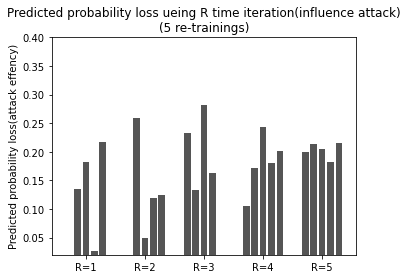

In [31]:
figure = plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
center_ixs_clean = []
for ix, block in enumerate(hit_prob_influ):
    x_ixs= np.arange(len(block)) + ix*(len(block)+2)
    center_ixs_clean.append(np.mean(x_ixs))
    color = '#555555'
    plt.bar(x_ixs, block, color=color)
ax=plt.gca()
plt.ylim((0.02, 0.4))
plt.ylabel("Predicted probability loss(attack effency)")
ax.set_xticks(center_ixs_clean)
ax.set_xticklabels([make_xlabel_R(k+1) for k in range(5)])
ax.set_title("Predicted probability loss ueing R time iteration(influence attack)\n({} re-trainings)".format(retrain_iters))

<BarContainer object of 5 artists>

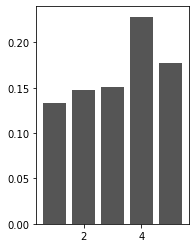

In [23]:
hit_prob_influ_sum = np.zeros(5)
for i in range(5):
    hit_prob_influ_sum[i] = hit_prob_influ[i].sum()/5
n = [1,2,3,4,5]
plt.subplot(1,2,2)
plt.bar(n,hit_prob_influ_sum,color='#555555')